In [ ]:
# goal of this analysis is to get an idea of whether SST cells are being driven by the VIP-halo stim.
# In particular, what is the differential degree of drive?

In [72]:
import pyute as ut
import matplotlib.pyplot as plt
import h5py
import skimage.segmentation as sks
import skimage.morphology as skm
import numpy as np
import pdb
import os
import size_contrast_analysis as sca
import sklearn
import sklearn.linear_model as sklm
from importlib import reload
import size_contrast_opto_analysis as scoa
import scipy.interpolate as sip
import scipy.stats as sst
import naka_rushton_analysis as nra
import scipy.spatial.distance as ssd
import sim_utils
import weibull_analysis as wa
reload(ut)
%matplotlib notebook

In [2]:
dsfile = '../shared_data/pyr_l23_data_struct.hdf5'

In [3]:
nbefore = 8
nafter = 8

In [4]:
import pandas as pd
def select_trials(trial_info,selector,training_frac,include_all=False):
    # dict saying what to do with each trial type. If a function, apply that function to the trial info column to
    # obtain a boolean indexing variable
    # if 0, then the tuning output should be indexed by that variable
    # if 1, then that variable will be marginalized over in the tuning output
    def gen_train_test_exptwise(ti):
        ntrials = ti[params[0]].size
        gd = np.ones((ntrials,),dtype='bool')
        for param in params:
            if callable(selector[param]): # all the values of selector that are functions, ignore trials where that function evaluates to False
                exclude = ~selector[param](ti[param])
                gd[exclude] = False
        condition_list = gen_condition_list(ti,selector) # automatically, separated out such that each half of the data gets an equivalent fraction of trials with each condition type
        condition_list = [c[gd] for c in condition_list]
        in_training_set = np.zeros((ntrials,),dtype='bool')
        in_test_set = np.zeros((ntrials,),dtype='bool')
        to_keep = output_training_test(condition_list,training_frac)
        in_training_set[gd] = to_keep
        in_test_set[gd] = ~to_keep
        if include_all:
            train_test = [in_training_set,in_test_set,np.logical_or(in_training_set,in_test_set)]
        else:
            train_test = [in_training_set,in_test_set]
        return train_test,ntrials

    params = list(selector.keys())
    keylist = list(trial_info.keys())
    if isinstance(trial_info[keylist[0]],dict):
        ntrials = {}
        train_test = {}
        for key in trial_info.keys():
            ti = trial_info[key]
            train_test[key],ntrials[key] = gen_train_test_exptwise(ti)
    else:
        ti = trial_info
        train_test,ntrials = gen_train_test_exptwise(ti)

    return train_test

def gen_condition_list(ti,selector,filter_selector=lambda x:True):
# ti: trial_info generated by ut.compute_tavg_dataframe
# selector: dict where each key is a param in ti.keys(), and each value is either a callable returning a boolean,
# to be applied to ti[param], or an input to the function filter_selector
# filter selector: if filter_selector(selector[param]), the tuning curve will be separated into the unique elements of ti[param].
    params = list(selector.keys())
    condition_list = []
    for param in params:
        if not callable(selector[param]) and filter_selector(selector[param]):
            condition_list.append(ti[param])
    return condition_list

def output_training_test(condition_list,training_frac):
    # output training and test sets balanced for conditions
    # condition list, generated by gen_condition_list, has a row for each condition that should be equally assorted
    if not isinstance(condition_list,list):
        condition_list = [condition_list.copy()]
    iconds,uconds = zip(*[pd.factorize(c,sort=True) for c in condition_list])
    #uconds = [np.sort(u) for u in uconds]
    nconds = np.array([u.size for u in uconds])
    in_training_set = np.zeros(condition_list[0].shape,dtype='bool')
    for iflat in range(np.prod(nconds)):
        coords = np.unravel_index(iflat,tuple(nconds))
        lkat = np.where(ut.k_and(*[iconds[ic] == coords[ic] for ic in range(len(condition_list))]))[0]
        n_train = int(np.round(training_frac*len(lkat)))
        to_train = np.random.choice(lkat,n_train,replace=False)
        in_training_set[to_train] = True
    #assert(True==False)
    return in_training_set

In [5]:
df,roi_info,trial_info = ut.compute_tavg_dataframe(dsfile,expttype='size_contrast_0')


<HDF5 group "/session_181205_M10130" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/session_181209_M8536" (9 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'figure_ground_0', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/session_181213_M8536" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/session_181214_M10130" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/session_190102_M10130" (8 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'mouse_id', 'retinotopy_0', 'size_contrast_0']
<HDF5 group "/session_190128_M8982" (9 members)>
['cell_center', 'cell_depth', 'cell_id', 'cell_mask', 'cell_type', 'figure_ground_0', 'mouse_id', 'retinotopy_0', 

In [6]:
tuning,uparam,displacement,pval = sim_utils.compute_tuning(dsfile,datafield='decon',running=False,expttype='size_contrast_0')

<HDF5 group "/session_181205_M10130" (8 members)>
decon
0.7321428571428571
<HDF5 group "/session_181209_M8536" (9 members)>
decon
0.8307142857142857
<HDF5 group "/session_181213_M8536" (8 members)>
decon
0.03857142857142857
<HDF5 group "/session_181214_M10130" (8 members)>
decon
0.4142857142857143


/Users/dan/Documents/code/adesnal/pyute.py:1229: RuntimeWarning: Mean of empty slice
  tuning[:,itype] = np.nanmean(data[cell_criteria][:,these_trials],1)


<HDF5 group "/session_190102_M10130" (8 members)>
decon
0.44916666666666666
<HDF5 group "/session_190128_M8982" (9 members)>
decon
0.9472222222222222
<HDF5 group "/session_190130_M9667" (9 members)>
decon
0.19027777777777777
<HDF5 group "/session_190131_M9355" (9 members)>
decon
0.9340277777777778
<HDF5 group "/session_190208_M9355" (9 members)>
decon
0.9506944444444444
<HDF5 group "/session_190212_M8536" (9 members)>
decon
0.2465277777777778
<HDF5 group "/session_191002_M0293" (12 members)>
decon
0.8462301587301587
<HDF5 group "/session_191108_M0403" (12 members)>
decon
0.9970238095238095
<HDF5 group "/session_200822_M0771" (13 members)>
decon
0.9151785714285714


In [31]:
modal_uparam = [np.array([ 5.        ,  8.21865442, 13.50925609, 22.20558144, 36.5       , 60.        ]),
                np.array([0.  , 0.03, 0.06, 0.12, 0.25, 0.5 , 1.  ])]
usize,ucontrast = modal_uparam
usize0 = np.concatenate(((0,),usize))
nangle = 4

In [7]:
npyfile = np.load('../behavior/size_contrast_behavior_summary.npy',allow_pickle=True)[()]
lick_rate,size,contrast,animal_id = [npyfile[key] for key in ['lick_rate','size','contrast','animal_id']]
fa = np.nanmean(lick_rate[contrast==0])

In [8]:
fa_id = np.zeros((len(np.unique(animal_id)),))
lapse_id = np.zeros((len(np.unique(animal_id)),))
size_id = np.zeros((len(np.unique(animal_id)),))
for this_id in range(len(fa_id)):
    fa_id[this_id] = lick_rate[(animal_id == this_id) & (contrast == 0)]
    lapse_id[this_id] = 1-lick_rate[(animal_id == this_id)][-1]
    size_id[this_id] = size[(animal_id == this_id) & (contrast == 0)]

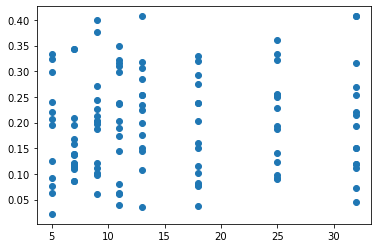

In [9]:
plt.figure()
plt.scatter(size_id,fa_id)

In [10]:
def gen_sc_selector():
    selector = {}
    selector['running'] = lambda x: np.logical_not(x)
    selector['stimulus_size_deg'] = 0
    selector['stimulus_contrast'] = 0
    selector['stimulus_direction_deg'] = 1
    return selector
selector = gen_sc_selector()


In [11]:
reload(ut)
nreps = 5
train_test = [None for irep in range(nreps)]
for irep in range(nreps):
    train_test[irep] = ut.select_trials(trial_info,selector,0.5,seed=irep)

In [12]:
keylist = list(train_test[0].keys())

In [13]:
reload(sca)
equate_ori = True
auroc,reg,proc,top_score = [[None for irep in range(nreps)] for _ in range(4)]
for irep in range(nreps):
    print(irep)
    # compute encoding axes based on training set trials
    reg[irep],proc[irep],top_score[irep] = sca.compute_encoding_axes(dsfile,expttype='size_contrast_0',training_set=train_test[irep],running_trials=False,equate_ori=equate_ori)
    reg_same = reg[irep].copy()
    for r in reg_same:
        if not r is None:
            for rr in r:
                if not rr is None:
                    rr[1] = rr[0].copy()
    # compute auroc based on test set trials: take population activity vectors for 0 and target contrast, use regression
    # trained on training set to predict contrast for both sets of population activity vectors, compute AUROC of predicted contrasts for both
    auroc[irep] = sca.compute_encoding_axis_auroc(reg_same,proc[irep])

0


/Users/dan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


1


/Users/dan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


2


/Users/dan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


3


/Users/dan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


4


/Users/dan/.local/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [14]:
reload(sca)
projections = [None for irep in range(nreps)]
projections_train = [None for irep in range(nreps)]
for irep in range(nreps):
    print(irep)
    projections[irep] = sca.compute_encoding_axis_projections(reg[irep],proc[irep],training_data=False,project_all=True)
    projections_train[irep] = sca.compute_encoding_axis_projections(reg[irep],proc[irep],training_data=True,project_all=True)

0
1
2
3
4


In [44]:
def resh_(arr):
    return arr.transpose((2,0,1)).reshape((arr.shape[2],-1))

reload(sca)
reg_indiv,reg_score_indiv,reg_score_mean_indiv = [[None for irep in range(nreps)] for _ in range(3)]
for irep in range(nreps):
    print(irep)
    proj_dict_test,proj_dict_train = [{} for _ in range(2)]
    for key in projections[irep]:
        proj_dict_train[key] = resh_(projections_train[irep][key])
        proj_dict_test[key] = resh_(projections[irep][key])
    # compute encoding axes based on training set trials
    reg_indiv[irep],reg_score_indiv[irep],reg_score_mean_indiv[irep] \
            = sca.compute_indiv_orth_detector_axes(proc=proc[irep],l2_penalty=1e3,orth_penalty=1e5)#,\
#                                                                                                        Xtrain_extra=proj_dict_train,\
#                                                                                                       Xtest_extra=proj_dict_test)
#     reg_same = reg[irep].copy()
#     for r in reg_same:
#         if not r is None:
#             for rr in r:
#                 if not rr is None:
#                     rr[1] = rr[0].copy()
    # compute auroc based on test set trials: take population activity vectors for 0 and target contrast, use regression
    # trained on training set to predict contrast for both sets of population activity vectors, compute AUROC of predicted contrasts for both
#     auroc[irep] = sca.compute_encoding_axis_auroc(reg_same,proc[irep])

0
1
2
3
4


In [43]:
# def resh_(arr):
#     return arr.transpose((2,0,1)).reshape((arr.shape[2],-1))

# reload(sca)
# reg_indiv,reg_score_indiv,reg_score_mean_indiv = [[None for irep in range(nreps)] for _ in range(3)]
# for irep in range(nreps):
#     print(irep)
#     proj_dict_test,proj_dict_train = [{} for _ in range(2)]
#     for key in projections[irep]:
#         proj_dict_train[key] = resh_(projections_train[irep][key])
#         proj_dict_test[key] = resh_(projections[irep][key])
#     # compute encoding axes based on training set trials
#     reg_indiv[irep],reg_score_indiv[irep],reg_score_mean_indiv[irep] = sca.compute_indiv_detector_axes(proc=proc[irep])#,\
# #                                                                                                        Xtrain_extra=proj_dict_train,\
# #                                                                                                       Xtest_extra=proj_dict_test)
# #     reg_same = reg[irep].copy()
# #     for r in reg_same:
# #         if not r is None:
# #             for rr in r:
# #                 if not rr is None:
# #                     rr[1] = rr[0].copy()
#     # compute auroc based on test set trials: take population activity vectors for 0 and target contrast, use regression
#     # trained on training set to predict contrast for both sets of population activity vectors, compute AUROC of predicted contrasts for both
# #     auroc[irep] = sca.compute_encoding_axis_auroc(reg_same,proc[irep])

/Users/dan/Documents/code/adesnal/pyute.py:1723: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  big_ind = big_ind*iit[slc]
/Users/dan/Documents/code/adesnal/pyute.py:1714: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a[[slice(None) for iind in range(ignore_first)]+[a_bool]] = b[[slice(None) for iind in range(ignore_first)]+[b_bool]]


ValueError: 'x' and 'y' must have the same size

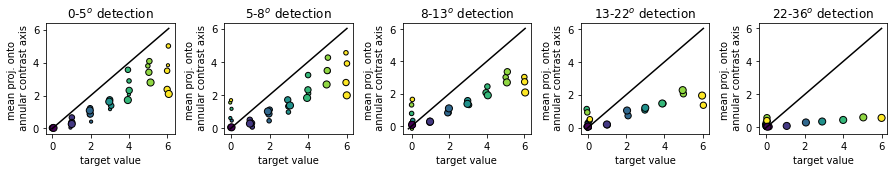

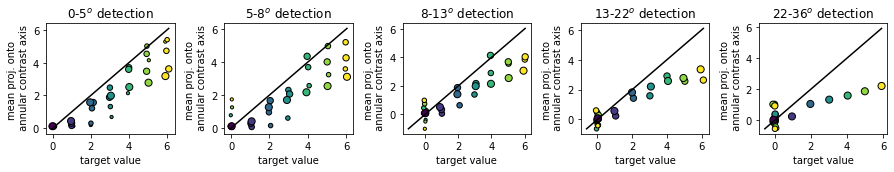

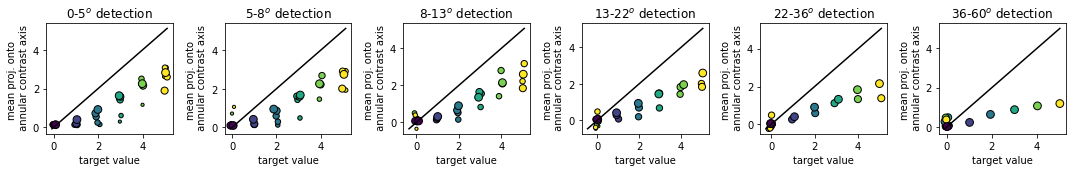

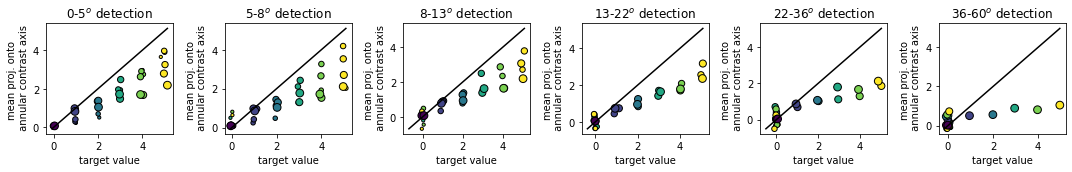

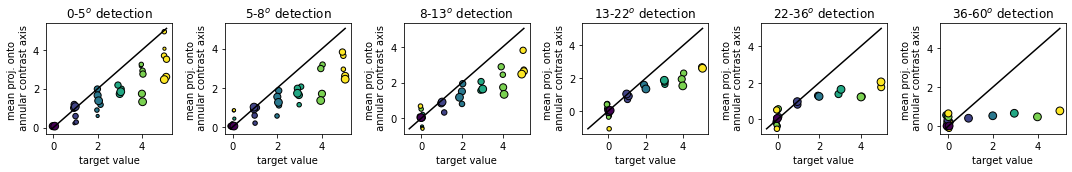

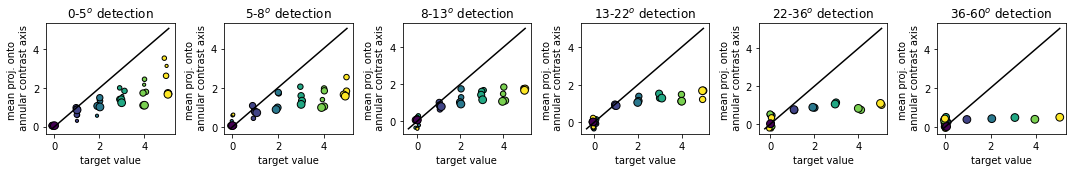

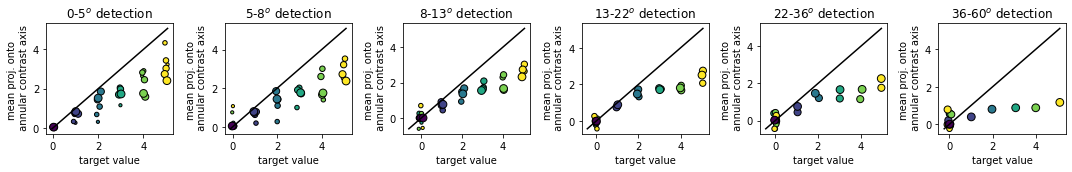

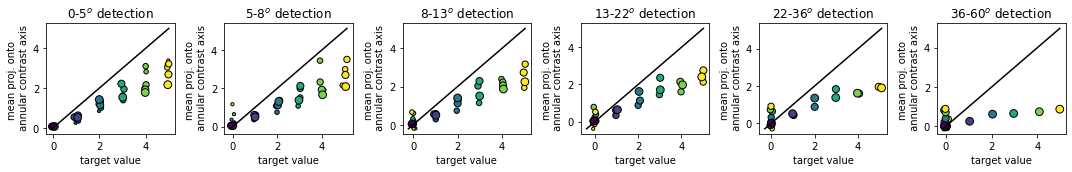

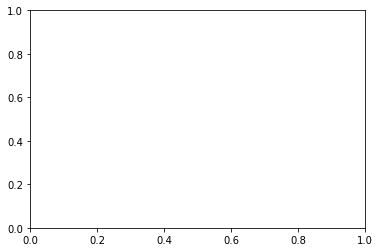

In [45]:
save_fig = False
nexpt = len(reg_score_mean_indiv[irep])
nsize,ncontrast = [len(x) for x in modal_uparam]
these_scores = np.zeros((nexpt,nsize,nsize,ncontrast))
for iexpt in range(nexpt):
    if not reg_score_mean_indiv[irep][iexpt] is None:
#         plt.figure()
        plt.figure(figsize=(15,2.5))
        this_usize = proc[irep][iexpt]['usize']
        this_ucontrast = proc[irep][iexpt]['ucontrast']#*100
        this_uparam = (this_usize,this_ucontrast)
        this_nsize = reg_score_mean_indiv[irep][iexpt].shape[0]
        for isize in range(this_nsize):
#             plt.subplot(2,3,isize+1)
            plt.subplot(1,6,isize+1)
            nsize,ncontrast = reg_score_mean_indiv[irep][iexpt][isize].shape[:2]
            target = np.zeros((nsize,ncontrast))
            target[isize:] = np.stack([np.arange(ncontrast) for _ in range(nsize-isize)])
            this_data = (reg_score_mean_indiv[irep][iexpt][isize]).mean(-1)
            ut.assign_from_uparam(these_scores[iexpt,isize],modal_uparam,this_data,this_uparam,ignore_first=0)
            sca.scatter_size_contrast(target+0.05*np.random.randn(*target.shape),(reg_score_mean_indiv[irep][iexpt][isize]).mean(-1),nsize=nsize,ncontrast=ncontrast)
            plt.title('%d-%d$^o$ detection'%(usize0[isize],usize0[isize+1]))
            plt.xlabel('target value')
            plt.ylabel('mean proj. onto \n annular contrast axis')
        plt.tight_layout()
#         for isize in range(reg_score_mean_indiv[irep][iexpt].shape[0]):
#             plt.subplot(2,3,isize+1)
# #             sca.show_size_contrast((reg_score_indiv[irep][(iexpt,isize,icontrast,iangle)]>0.5).mean(-1),vmin=0,vmax=1,flipud=True,usize=usize,ucontrast=ucontrast)
#             sca.show_size_contrast((reg_score_mean_indiv[irep][iexpt][isize]).mean(-1),vmin=0,vmax=reg_score_mean_indiv[irep][iexpt].shape[2]-1,flipud=True,usize=usize,ucontrast=ucontrast)
#             plt.title('%d$^o$+ detection'%usize[isize])
#         plt.tight_layout()
        if save_fig:
            plt.savefig('figures/annular_detection_performance_validation_expt_%d.eps'%iexpt)

plt.figure()
for isize in range(nsize):
    target = np.zeros((nsize,ncontrast))
    target[isize:] = np.stack([np.arange(ncontrast) for _ in range(nsize-isize)])
    sca.scatter_size_contrast_errorbar(target+0.05*np.random.randn(*target.shape),these_scores[:,isize],nsize=nsize,ncontrast=ncontrast)



In [46]:
gray_screen = np.max(np.stack([reg_score_indiv[irep][(iexpt,jsize,0,0,0)] for jsize in range(nsize)]),axis=0)


In [47]:
fa_thresh = np.nanpercentile(gray_screen,100*(1-fa))

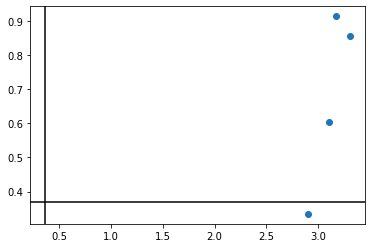

In [48]:
irep = 0
iexpt = 0

nsize,ncontrast = reg_score_mean_indiv[irep][iexpt][0].shape[:2]

jsize1,jsize2 = 0,4
isize,icontrast,iangle = 4,5,0

gray_screen = np.max(np.stack([reg_score_indiv[irep][(iexpt,jsize,0,0,0)] for jsize in range(nsize)]),axis=0)
fa_thresh = np.nanpercentile(gray_screen,100*(1-fa))

x,y = [reg_score_indiv[irep][(iexpt,jsize,isize,icontrast,iangle)] for jsize in [jsize1,jsize2]]
plt.figure()
plt.scatter(x,y)
plt.axvline(fa_thresh,c='k')
plt.axhline(fa_thresh,c='k')

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/dan/Documents/code/adesnal/pyute.py:2156: RuntimeWarning: All-NaN slice encountered
  mx = np.nanmax(np.abs(arr))


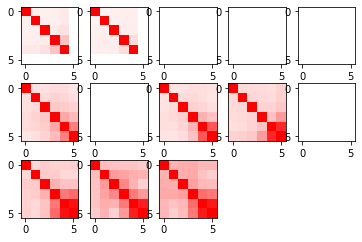

In [49]:
ax_cos = np.nan*np.ones((nreps,nexpt,6,6,4))
for iexpt in range(nexpt):
    if (iexpt,0,0,0,0) in reg_score_indiv[irep]:
        for isize1 in range(len(proc[irep][iexpt]['usize'])):
            for isize2 in range(len(proc[irep][iexpt]['usize'])):
                for iangle in range(nangle):
                    vec1 = reg_indiv[irep][(iexpt,iangle)].W[:,isize1]
                    vec1 = vec1/np.linalg.norm(vec1)
                    vec2 = reg_indiv[irep][(iexpt,iangle)].W[:,isize2]
                    vec2 = vec2/np.linalg.norm(vec2)
                    ax_cos[irep,iexpt,isize1,isize2,iangle] = vec1.dot(vec2)
                    
plt.figure()
for iexpt in range(nexpt):
    plt.subplot(3,5,iexpt+1)
    ut.imshow_hot_cold(np.nanmean(np.nanmean(ax_cos[:,iexpt,:,:,:],-1),0))

In [50]:
iexpt = 0
this_isize = 4
this_icontrast = 4
cc = np.nan*np.ones((nreps,nexpt,6,7,4,6,6))
plt.figure()
for iexpt in range(nexpt):
    if (iexpt,0,0,0,0) in reg_score_indiv[irep]:
        for isize in range(len(proc[irep][iexpt]['usize'])):
            for iangle in range(nangle):
                for icontrast in range(len(proc[irep][iexpt]['ucontrast'])):
                    for jsize1 in range(len(proc[irep][iexpt]['usize'])):
                        for jsize2 in range(len(proc[irep][iexpt]['usize'])):
                            x,y = [reg_score_indiv[irep][(iexpt,jsize,isize,icontrast,iangle)] for jsize in [jsize1,jsize2]]
                            cc[irep,iexpt,isize,icontrast,iangle,jsize1,jsize2] = np.corrcoef(x,y)[0,1]
#                 plt.scatter(x,y)
#                 plt.xlim((-2,10))
#                 plt.ylim((-2,10))
# plt.axhline(0,c='k')
# plt.axvline(0,c='k')

<Figure size 432x288 with 0 Axes>

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice


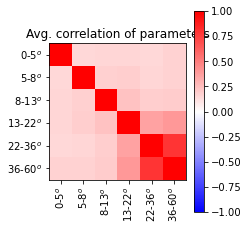

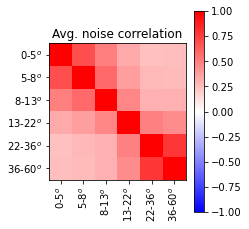

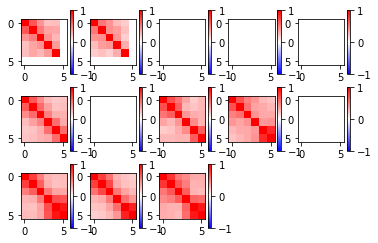

In [51]:
plt.figure(figsize=(3.5,3.5))
# ax_cos[irep,iexpt,isize1,isize2,iangle]
# plt.imshow(np.nanmean(np.nanmean(np.nanmean(np.nanmean(np.nanmean(cc,0),0),0),0),0),vmin=0,vmax=1)
ut.imshow_hot_cold(np.nanmean(np.nanmean(np.nanmean(ax_cos,0),0),-1),mx=1)
plt.xticks(np.arange(6),['%d-%d$^o$'%(u1,u2) for u1,u2 in zip(usize0[:-1],usize0[1:])],rotation=90)
plt.yticks(np.arange(6),['%d-%d$^o$'%(u1,u2) for u1,u2 in zip(usize0[:-1],usize0[1:])])
plt.colorbar()
plt.title('Avg. correlation of parameters')
plt.tight_layout()
if save_fig:
    plt.savefig('figures/ind_detector_axis_cos.eps')

plt.figure(figsize=(3.5,3.5))
# plt.imshow(np.nanmean(np.nanmean(np.nanmean(np.nanmean(np.nanmean(cc,0),0),0),0),0),vmin=0,vmax=1)
ut.imshow_hot_cold(np.nanmean(np.nanmean(np.nanmean(np.nanmean(np.nanmean(cc,0),0),0),0),0),mx=1)
plt.xticks(np.arange(6),['%d-%d$^o$'%(u1,u2) for u1,u2 in zip(usize0[:-1],usize0[1:])],rotation=90)
plt.yticks(np.arange(6),['%d-%d$^o$'%(u1,u2) for u1,u2 in zip(usize0[:-1],usize0[1:])])
plt.colorbar()
plt.title('Avg. noise correlation')
plt.tight_layout()
if save_fig:
    plt.savefig('figures/ind_detector_corrcoefs.eps')

plt.figure()
for iexpt in range(nexpt):
    plt.subplot(3,5,iexpt+1)
    # plt.imshow(np.nanmean(np.nanmean(np.nanmean(np.nanmean(np.nanmean(cc,0),0),0),0),0),vmin=0,vmax=1)
    ut.imshow_hot_cold(np.nanmean(np.nanmean(np.nanmean(np.nanmean(cc[:,iexpt],0),0),0),0),mx=1)
    plt.colorbar()

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


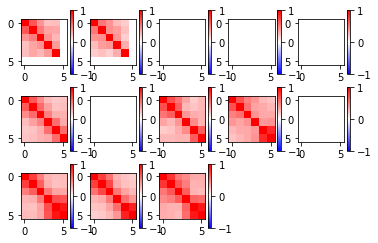

In [52]:
plt.figure()
for iexpt in range(nexpt):
    plt.subplot(3,5,iexpt+1)
    # plt.imshow(np.nanmean(np.nanmean(np.nanmean(np.nanmean(np.nanmean(cc,0),0),0),0),0),vmin=0,vmax=1)
    ut.imshow_hot_cold(np.nanmean(np.nanmean(np.nanmean(np.nanmean(cc[:,iexpt],0),0),0),0),mx=1)
    plt.colorbar()

In [55]:
for irep in range(nreps):
    for iexpt in range(len(proc[irep])):
        proc[irep][iexpt]['uangle'] = proc[irep][iexpt]['uangle'][:4]

In [56]:
tuning_tavg = [np.nanmean(t[:,:,:,:,8:-8],4) if not t is None else None for t in tuning]

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [57]:
keys = ['proc','auroc','reg','top_score','tuning_tavg']
values = [proc,auroc,reg,top_score,tuning_tavg]
processed_dicti = {k:v for k,v in zip(keys,values)}
if save_fig:
    np.save('contrast_decoding_variables.npy',processed_dicti,allow_pickle=True)

In [58]:
reload(sca)
# auroc[irep] = sca.compute_encoding_axis_auroc(reg_same,proc)
hit = [None for irep in range(nreps)]
for irep in range(nreps):
    hit[irep] = sca.compute_encoding_axis_hit_from_fa(reg[irep],proc[irep],fa=fa)

In [17]:
processed_dicti = np.load('contrast_decoding_variables.npy',allow_pickle=True)[()]
keys = ['proc','auroc','reg','top_score','tuning_tavg']
proc,auroc,reg,top_score,tuning_tavg = [processed_dicti[key] for key in keys]

<IPython.core.display.Javascript object>


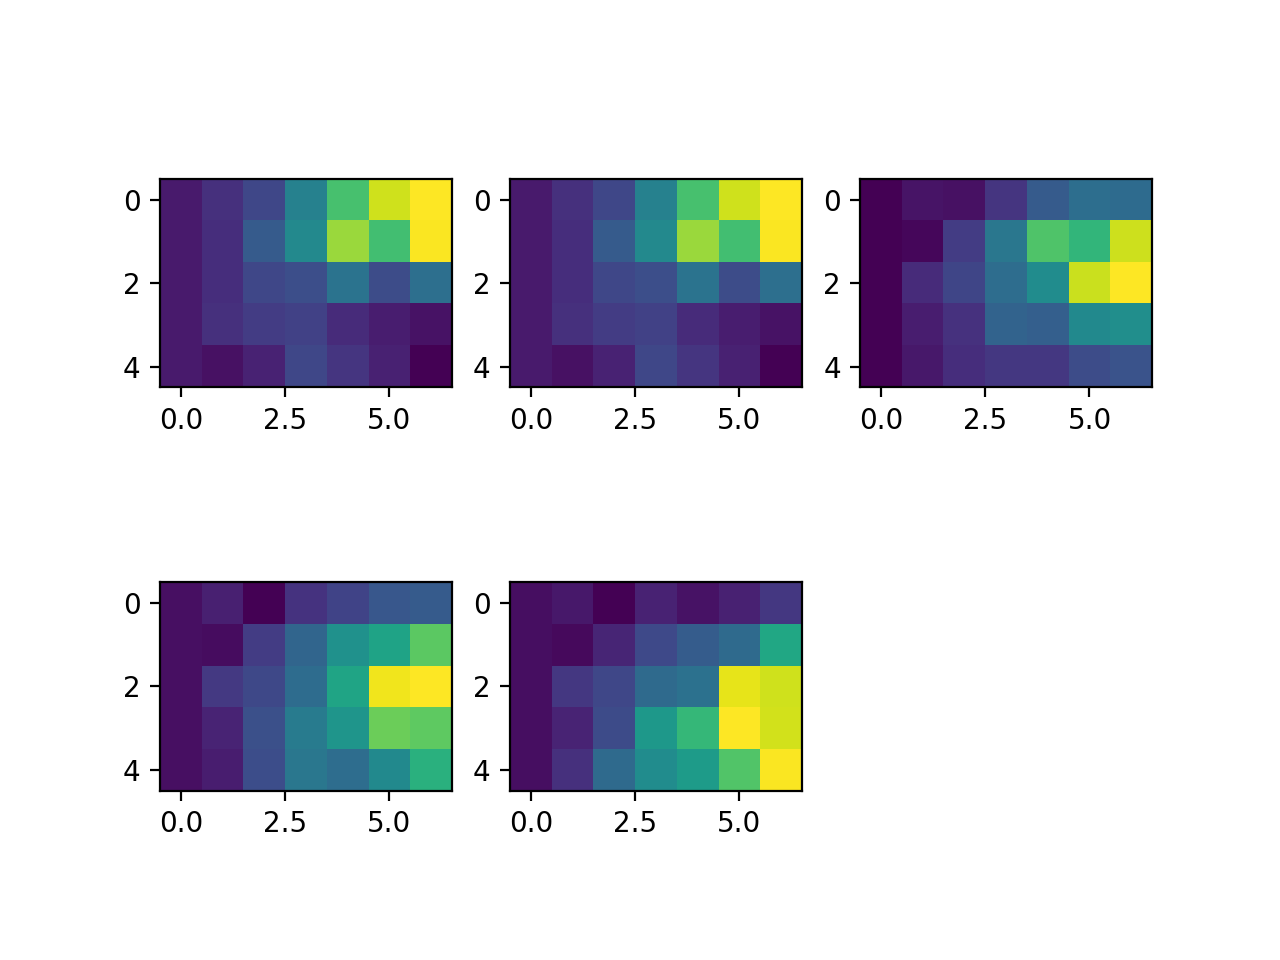

In [54]:
irep = 0
iexpt = 0
nsize = len(proc[irep][iexpt]['usize'])
ncontrast = len(proc[irep][iexpt]['ucontrast'])
nangle = len(proc[irep][iexpt]['uangle'])
proj_mean = np.zeros((nsize,nsize,ncontrast,nangle))
for jsize in range(nsize):
    for isize in range(nsize):
        for icontrast in range(ncontrast):
            for iangle in range(nangle):
                proj_mean[jsize,isize,icontrast,iangle] = projections_train[irep][(iexpt,isize,icontrast,iangle)][jsize,:,:].mean()
plt.figure()
for jsize in range(nsize):
    plt.subplot(2,3,jsize+1)
    plt.imshow(proj_mean[jsize].mean(2))

<IPython.core.display.Javascript object>


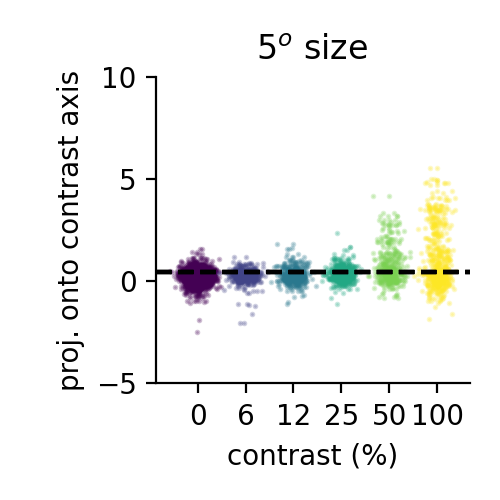

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


<IPython.core.display.Javascript object>


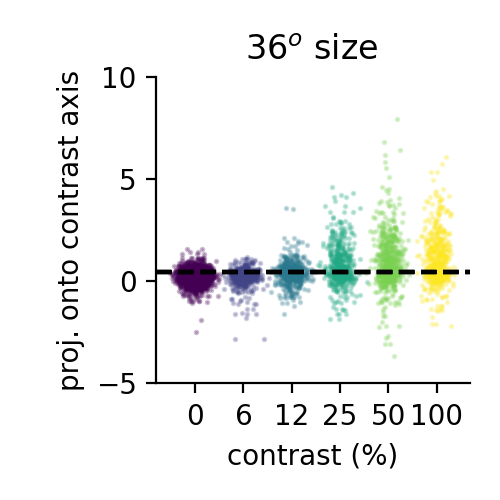

In [843]:
irep = 0
iexpt = 5
isize = 0
iangle = 0
alpha = 0.25
ncontrast = len(proc[irep][iexpt]['ucontrast'])
usize = proc[irep][iexpt]['usize']
colors = plt.cm.viridis(np.linspace(0,1,ncontrast))
for isize in [0,4]:
    plt.figure(figsize=(2.5,2.5))
    for irep in range(1):
        for icontrast in range(ncontrast):
            if icontrast == 0:
                to_plot = projections[irep][(iexpt,isize,icontrast,0)]
                plt.scatter(icontrast*np.ones_like(to_plot)+0.15*np.random.randn(*(to_plot.shape)),to_plot,s=1,c=colors[icontrast:icontrast+1],alpha=alpha)#,edgecolor='k'
            else:
                for iangle in range(4):
                    to_plot = projections[irep][(iexpt,isize,icontrast,iangle)]
                    plt.scatter(icontrast*np.ones_like(to_plot)+0.15*np.random.randn(*(to_plot.shape)),to_plot,s=1,c=colors[icontrast:icontrast+1],alpha=alpha)#,edgecolor='k'
            plt.axhline(np.nanpercentile(projections[irep][(iexpt,isize,0,iangle)],100-100*fa),c='k',linestyle='dashed')
    ut.erase_top_right()
    plt.xticks(np.arange(ncontrast),(100*proc[irep][iexpt]['ucontrast']).astype('int'))
    plt.xlabel('contrast (%)')
    plt.ylabel('proj. onto contrast axis')
    plt.title('%d$^o$ size '%usize[isize])
    plt.ylim((-5,10))
    plt.tight_layout()
#     plt.savefig('figures/distribution_vs_contrast_at_size_%d_example_mouse.eps'%isize)

In [64]:
def compute_regression(X,y):
    logreg = sklearn.linear_model.LogisticRegression()
    reg = logreg.fit(X,y)
    return reg

def compute_score(X,y,reg=None):
    return reg.score(X,y)

# def compute_single_detector_scores

In [62]:
nangle = 4
reg = {}
reg_score = {}
reg_score_mean = [None for _ in range(nexpt)]
for iexpt in range(nexpt):
    if (iexpt,0,0,0) in projections_train[irep]:
        nsize = len(proc[irep][iexpt]['usize'])
        ncontrast = len(proc[irep][iexpt]['ucontrast'])
        reg_score_mean[iexpt] = np.zeros((nsize,nsize,ncontrast,nangle))
        all_gray_screen = np.zeros((nsize,nangle,0))
        for iangle in range(nangle):
            for isize in range(nsize):
                all_gray_screen = np.concatenate((all_gray_screen,projections_train[irep][(iexpt,isize,0,iangle)]),axis=2)
        # this might be messed up-- will have to look back and make sure I am doing the right things with angles
        for iangle in range(nangle):
            for isize in range(nsize):
                this_gray_screen = all_gray_screen.copy()
                for jsize in range(isize):
                    for icontrast in range(1,ncontrast):
                        this_gray_screen = np.concatenate((this_gray_screen,\
                                            projections_train[irep][(iexpt,jsize,icontrast,iangle)]),axis=2)
                y = np.zeros((this_gray_screen.shape[2],))
                contrast_present = np.zeros((nsize,nangle,0))
                for jsize in range(isize,nsize):
                    for icontrast in range(1,ncontrast):
                        this_data = projections_train[irep][(iexpt,jsize,icontrast,iangle)]
                        ntrials = this_data.shape[2]
                        contrast_present = np.concatenate((contrast_present,this_data),axis=2)
                        y = np.concatenate((y,icontrast*np.ones((ntrials,))),axis=0)
#                 y = np.concatenate((np.zeros((this_gray_screen.shape[2],)),np.ones((contrast_present.shape[2],))),axis=0)
                X = np.concatenate((this_gray_screen.reshape((nsize*nangle,-1)).T,contrast_present.reshape((nsize*nangle,-1)).T),axis=0)
                logreg = sklearn.linear_model.LogisticRegression()
                reg[(iexpt,isize,iangle)] = logreg.fit(X,y>0)
        
        all_gray_screen = np.zeros((nsize,nangle,0))
        for iangle in range(nangle):
            for isize in range(nsize):
                all_gray_screen = np.concatenate((all_gray_screen,projections[irep][(iexpt,isize,0,iangle)]),axis=2)
        for iangle in range(nangle):
            for isize in range(nsize):
                for icontrast in range(ncontrast):
                    if icontrast == 0:
                        contrast_present = all_gray_screen.copy()
                    else:
                        contrast_present = projections[irep][(iexpt,isize,icontrast,iangle)].copy()
                    X = contrast_present.reshape((nsize*nangle,-1)).T
                    for jsize in range(nsize):
                        reg_score[(iexpt,jsize,isize,icontrast,iangle)] = reg[(iexpt,jsize,iangle)].predict_proba(X)[:,1]
                        reg_score_mean[iexpt][jsize,isize,icontrast,iangle] = reg_score[(iexpt,jsize,isize,icontrast,iangle)].mean()

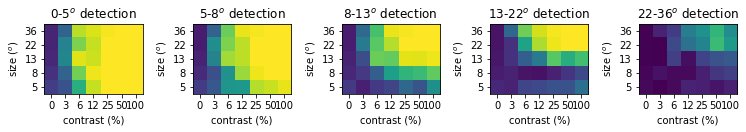

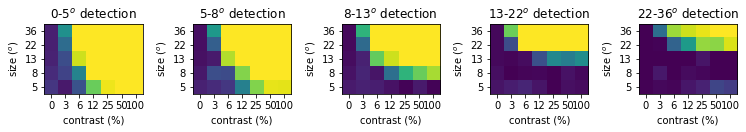

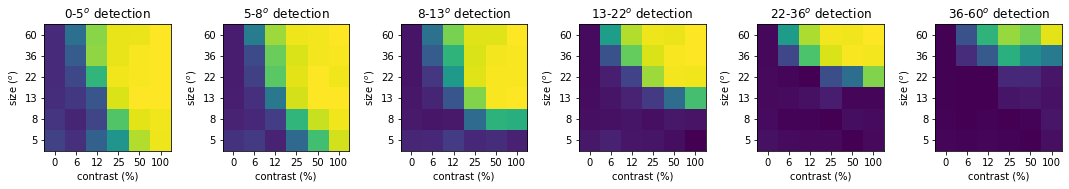

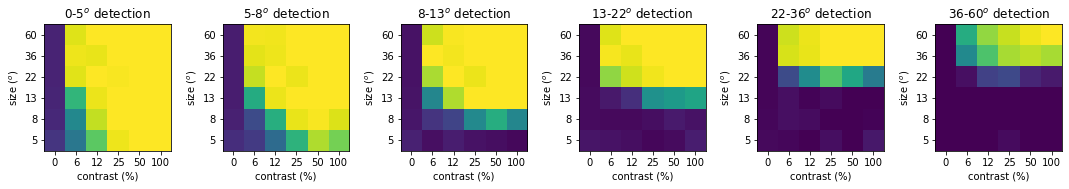

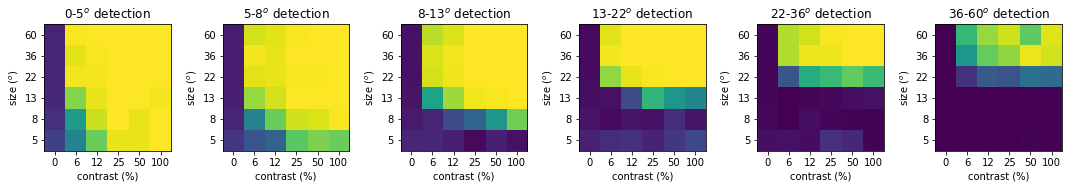

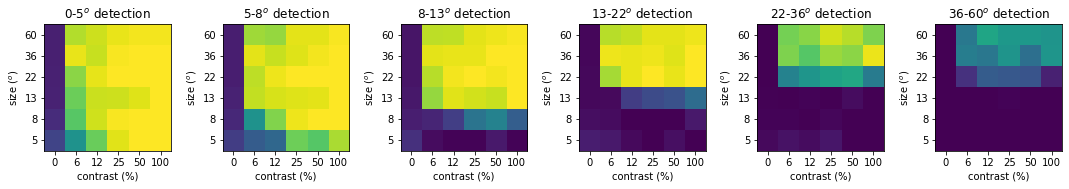

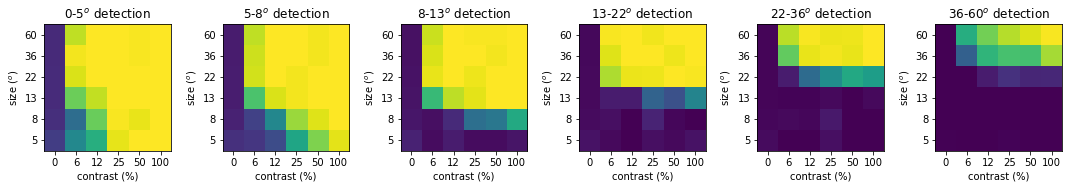

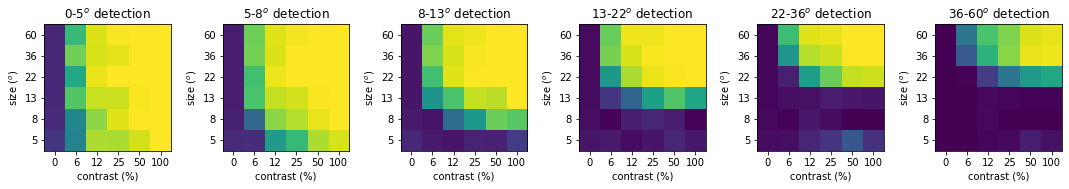

In [64]:
irep = 0
nexpt = len(reg_score_mean_indiv[irep])
ind_detector_hit = [None for iexpt in range(nexpt)]
for iexpt in range(nexpt):
    if not reg_score_mean_indiv[irep][iexpt] is None:
#         plt.figure()
        plt.figure(figsize=(2.5*reg_score_mean[iexpt].shape[0],2.5))
        usize = proc[irep][iexpt]['usize']
        ucontrast = proc[irep][iexpt]['ucontrast']*100
#         for isize in range(reg_score_mean_indiv[irep][iexpt].shape[0]):
#             plt.subplot(2,3,isize+1)
#             nsize,ncontrast = reg_score_mean_indiv[irep][iexpt][isize].shape[:2]
#             target = np.zeros((nsize,ncontrast))
#             target[isize:] = np.stack([np.arange(ncontrast) for _ in range(nsize-isize)])
#             sca.scatter_size_contrast(target,(reg_score_mean_indiv[irep][iexpt][isize]).mean(-1),nsize=nsize,ncontrast=ncontrast)
#             plt.title('%d$^o$+ detection'%usize[isize])
#         plt.tight_layout()
        nsize,ncontrast = reg_score_mean_indiv[irep][iexpt][0].shape[:2]
        ind_detector_hit[iexpt] = np.zeros((nreps,nsize,nsize,ncontrast,nangle))
        
        for jsize in range(nsize):
            for irep in range(nreps):
                for isize in range(nsize):
                    gray_screen_vals = np.stack([reg_score_indiv[irep][(iexpt,jjsize,0,0,0)] for jjsize in range(isize+1)])
                    gray_screen = np.max(gray_screen_vals,axis=0)
#                     print('%d,%0.02f'%(isize,(np.argmax(gray_screen_vals,axis=0)==0).mean()))
                    fa_thresh = np.nanpercentile(gray_screen,100*(1-fa))
                    for icontrast in range(ncontrast):
                        for iangle in range(nangle):
                            ind_detector_hit[iexpt][irep,jsize,isize,icontrast,iangle] = (reg_score_indiv[irep][(iexpt,jsize,isize,icontrast,iangle)]>fa_thresh).mean()
#             plt.subplot(2,3,jsize+1)
            plt.subplot(1,6,jsize+1)

            irep = 0
            sca.show_size_contrast(ind_detector_hit[iexpt][:,jsize,:,:,:].mean(0).mean(-1),vmin=0,vmax=1,flipud=True,usize=usize,ucontrast=ucontrast)
            plt.title('%d-%d$^o$ detection'%(usize0[jsize],usize0[jsize+1]))
        plt.tight_layout()
        if save_fig:
            plt.savefig('figures/annular_detection_performance_expt_%d.eps'%iexpt)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
0.5833333333333333
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
0.9333333333333333
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

0.9448333333333333
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
0.93
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
0.555
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
0.975
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o


1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

0.9583333333333334
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


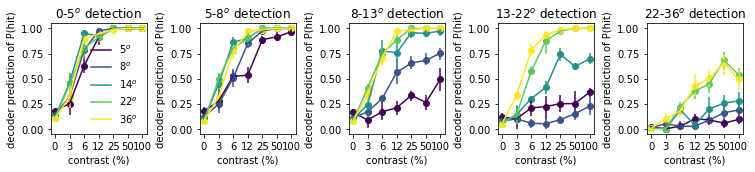

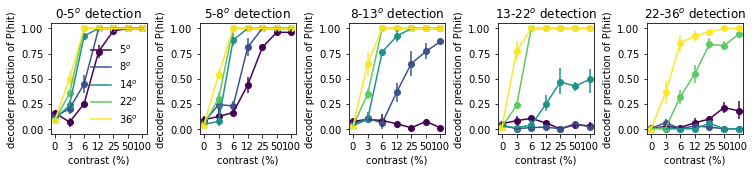

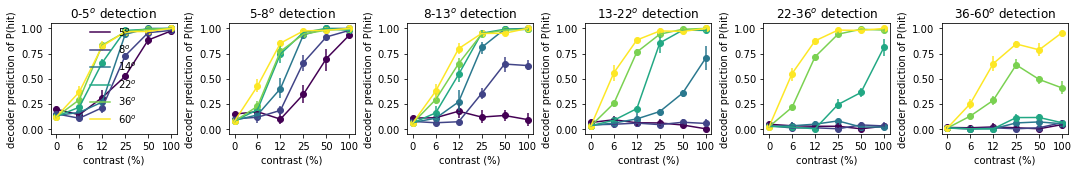

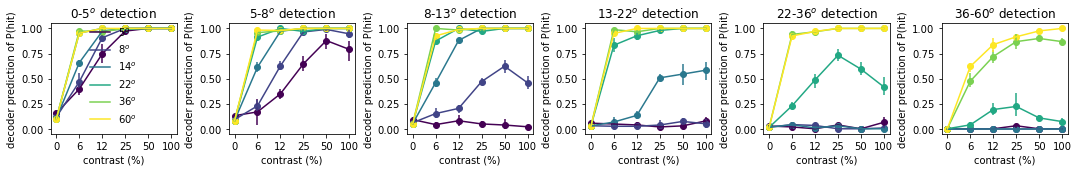

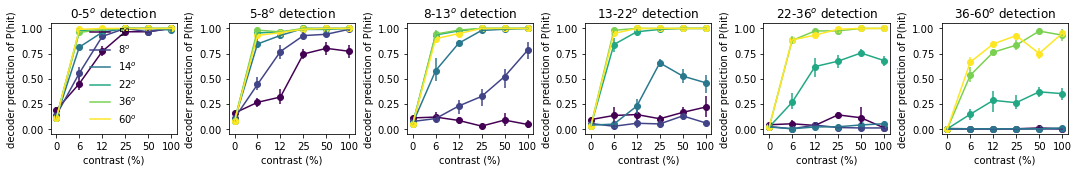

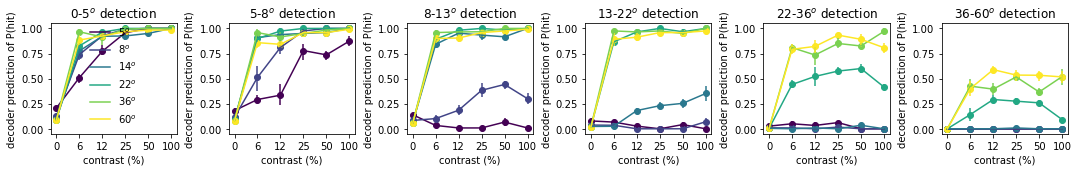

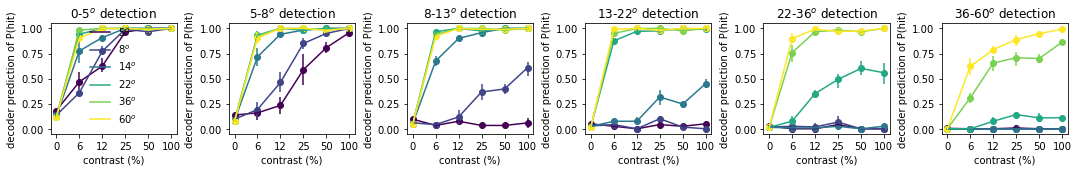

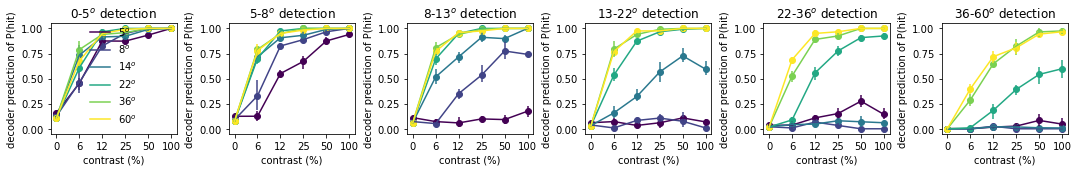

In [65]:
irep = 0
nexpt = len(reg_score_mean_indiv[irep])
ind_detector_hit = [None for iexpt in range(nexpt)]
for iexpt in range(nexpt):
    if not reg_score_mean_indiv[irep][iexpt] is None:
#         plt.figure()
        plt.figure(figsize=(2.5*reg_score_mean[iexpt].shape[0],2.5))
        usize = proc[irep][iexpt]['usize']
        ucontrast = proc[irep][iexpt]['ucontrast']*100
#         for isize in range(reg_score_mean_indiv[irep][iexpt].shape[0]):
#             plt.subplot(2,3,isize+1)
#             nsize,ncontrast = reg_score_mean_indiv[irep][iexpt][isize].shape[:2]
#             target = np.zeros((nsize,ncontrast))
#             target[isize:] = np.stack([np.arange(ncontrast) for _ in range(nsize-isize)])
#             sca.scatter_size_contrast(target,(reg_score_mean_indiv[irep][iexpt][isize]).mean(-1),nsize=nsize,ncontrast=ncontrast)
#             plt.title('%d$^o$+ detection'%usize[isize])
#         plt.tight_layout()
        nsize,ncontrast = reg_score_mean_indiv[irep][iexpt][0].shape[:2]
        ind_detector_hit[iexpt] = np.zeros((nreps,nsize,nsize,ncontrast,nangle))
        
        for jsize in range(nsize):
            for irep in range(nreps):
                for isize in range(nsize):
                    gray_screen_vals = np.stack([reg_score_indiv[irep][(iexpt,jjsize,0,0,0)] for jjsize in range(isize+1)])
                    gray_screen = np.max(gray_screen_vals,axis=0)
#                     print('%d,%0.02f'%(isize,(np.argmax(gray_screen_vals,axis=0)==0).mean()))
                    fa_thresh = np.nanpercentile(gray_screen,100*(1-fa))
                    for icontrast in range(ncontrast):
                        for iangle in range(nangle):
                            ind_detector_hit[iexpt][irep,jsize,isize,icontrast,iangle] = (reg_score_indiv[irep][(iexpt,jsize,isize,icontrast,iangle)]>fa_thresh).mean()
#             plt.subplot(2,3,jsize+1)
            plt.subplot(1,6,jsize+1)

            irep = 0
            ut.plot_bootstrapped_errorbars_hillel(np.arange(len(ucontrast)),ind_detector_hit[iexpt][:,jsize,:,:,:].mean(-1))
            if jsize == 0:
                plt.legend(['%d$^o$'%u for u in np.round(usize).astype('int')],frameon=False)
            plt.xticks(np.arange(len(ucontrast)),ucontrast.astype('int'))
            plt.xlabel('contrast (%)')
            plt.ylabel('decoder prediction of P(hit)')
            plt.title('%d-%d$^o$ detection'%(usize0[jsize],usize0[jsize+1]))
            plt.ylim((-0.05,1.05))
        plt.tight_layout()
        if save_fig:
            plt.savefig('figures/annular_detection_performance_expt_%d.eps'%iexpt)

In [69]:
popt_all = np.load('../behavior/popt_all.npy')[()]

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>


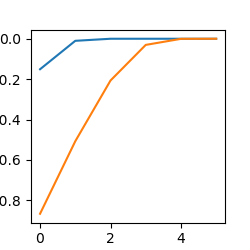

<IPython.core.display.Javascript object>


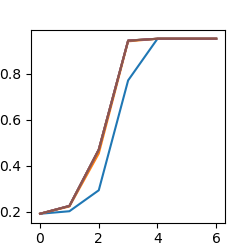

<IPython.core.display.Javascript object>


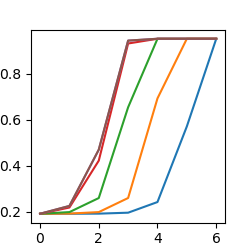

In [198]:
import scipy.integrate as sin
import scipy.special as ssp
# d0,d1,s
def compute_sq_integral(d0,d1,s,epsrel=1e-8):
    if d1 == 0 or d0 == 0:
        return 0
    elif s == 0:
        return np.minimum(d0**2,d1**2)
    else:
        def f(x,y):
            return ((1.25331*s*ssp.erf((0.353553*d1 - 0.707107*x)/s) +
                 1.25331*s*ssp.erf((0.353553*d1 + 0.707107*x)/
                   s))*(0.199471*(1.*d1 - 2.*y)*np.sqrt((1.*d1**2 + 4.*d1*y + 4.*y**2)/
                  s**2)*ssp.erf(0.353553*np.sqrt((1.*d1 - 2.*y)**2/s**2)) +
                 0.199471*(1.*d1 + 2.*y)*np.sqrt((1.*d1**2 - 4.*d1*y + 4.*y**2)/s**2)
                    *ssp.erf(0.353553*np.sqrt((1.*d1 + 2.*y)**2/s**2))))/(s**2*np.sqrt((1.*d1 -
                 2.*y)**2/s**2)*np.sqrt((1.*d1 + 2.*y)**2/s**2))
        opts = {'epsrel':epsrel}
        return sin.nquad(f, [[-d0/2, d0/2],[-d0/2, d0/2]],opts=opts)[0]
#         def f(x,y,xp,yp):
#             return 1/(2*np.pi*s**2)*np.exp(-0.5*((xp-x)/s)**2)*np.exp(-0.5*((yp-y)/s)**2)
#         opts = {'epsrel':epsrel}
#         return sin.nquad(f, [[-d0/2, d0/2],[-d0/2, d0/2],[-d1/2, d1/2],[-d1/2, d1/2]],opts=opts)[0]
def compute_multiplier(d0,d1in,d1out,s,epsrel=1e-2):
    return (compute_sq_integral(d0,d1out,s,epsrel=epsrel)-compute_sq_integral(d0,d1in,s,epsrel=epsrel))/(d1out**2-d1in**2)
usize = np.array((5,8,13,22,36,60))
plt.figure(figsize=(2.5,2.5))
d1in = 0
d1out = 5
sigma = 1
plt.plot([np.log10(compute_multiplier(d0,d1in,d1out,sigma)) for d0 in usize])
sigma = 5
plt.plot([np.log10(compute_multiplier(d0,d1in,d1out,sigma)) for d0 in usize])

for sigma in [1,5]:
    plt.figure(figsize=(2.5,2.5))
    for mult in [compute_multiplier(d0,d1in,d1out,sigma) for d0 in usize]:
#         this_c = np.logspace(0,2,100)*mult
        this_c = ucontrast*mult
        this_nnxx = np.concatenate(((d1out**2 - d1in**2)*np.ones((len(this_c),1)),this_c[:,np.newaxis]),axis=1)
        this_y = wa.weibull_function_n_one_arg(this_nnxx,*popt_all)
        plt.plot(this_y)
        

In [137]:
d0 = 5
%timeit compute_multiplier(d0,d1in,d1out,sigma)

5.36 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>


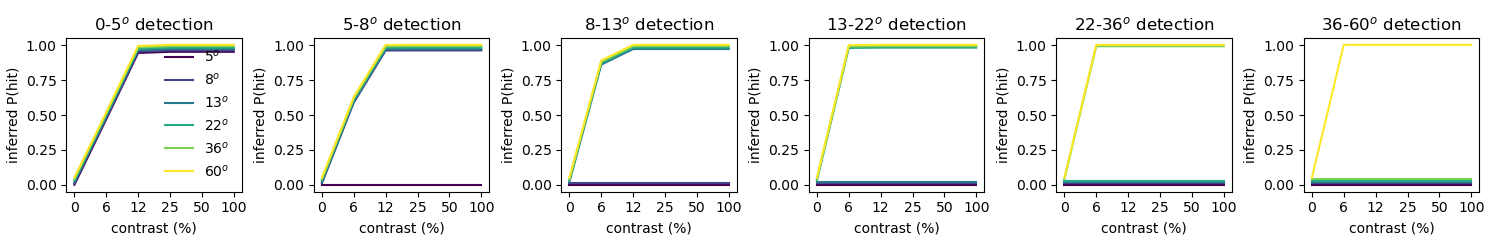

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


In [84]:
plt.figure(figsize=(15,2.5))
ucontrast = np.array((0,6,12,25,50,100))
for jsize in range(6):
    plt.subplot(1,6,jsize+1)
    offset = 0.01*np.arange(6)[np.newaxis,:,np.newaxis]
    ut.plot_bootstrapped_errorbars_hillel(np.arange(len(ucontrast)),Phit[jsize:jsize+1,:,[0,2,3,4,5,6]]+offset,markersize=0)
    if jsize == 0:
        plt.legend(['%d$^o$'%u for u in np.round(usize).astype('int')],frameon=False,loc='lower right')
    plt.xticks(np.arange(len(ucontrast)),ucontrast.astype('int'))
    plt.xlabel('contrast (%)')
    plt.ylabel('inferred P(hit)')
    plt.title('%d-%d$^o$ detection'%(usize0[jsize],usize0[jsize+1]))
    plt.ylim((-0.05,1.05))
plt.tight_layout()
if save_fig:
    plt.savefig('figures/inferred_annular_detection_p_hit.eps')

<IPython.core.display.Javascript object>


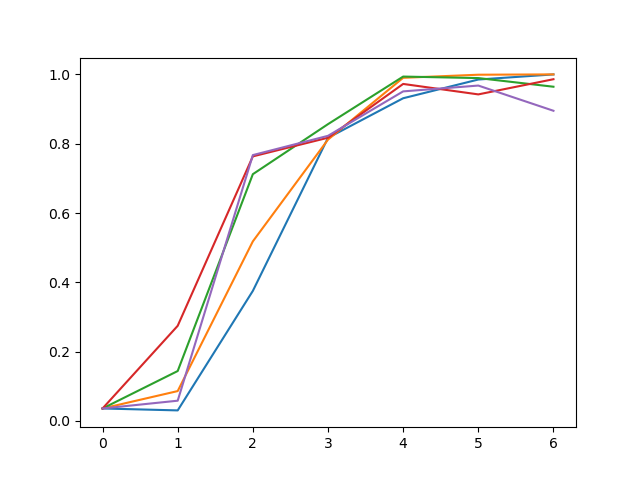

In [88]:
plt.figure()
plt.plot(reg_score_mean[0][0].mean(-1).T)

<IPython.core.display.Javascript object>


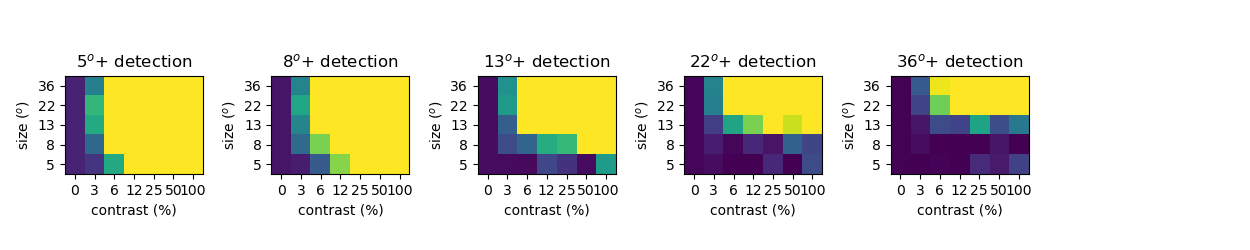

<IPython.core.display.Javascript object>


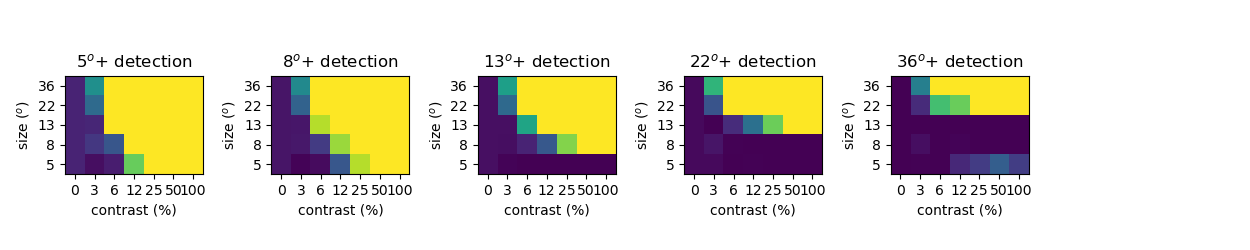

<IPython.core.display.Javascript object>


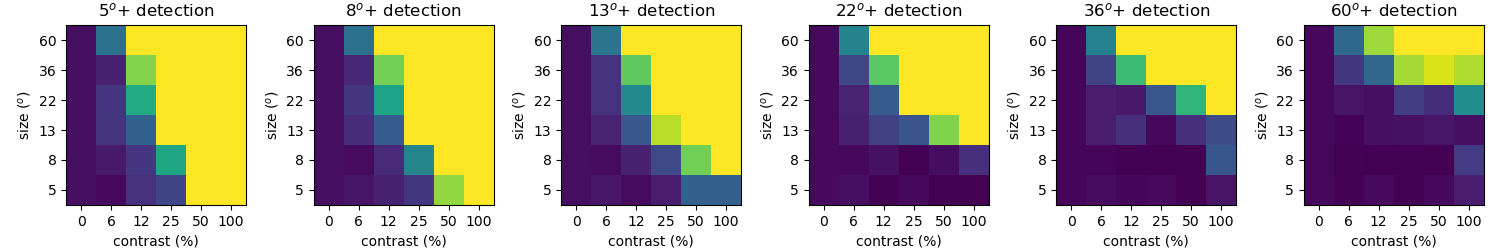

<IPython.core.display.Javascript object>


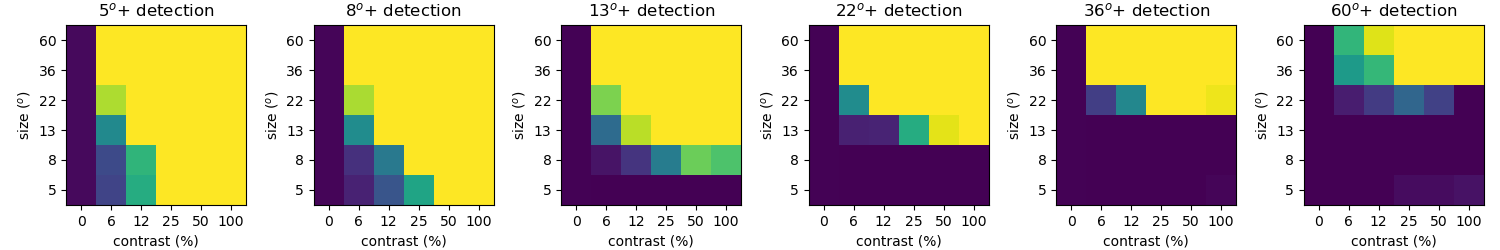

<IPython.core.display.Javascript object>


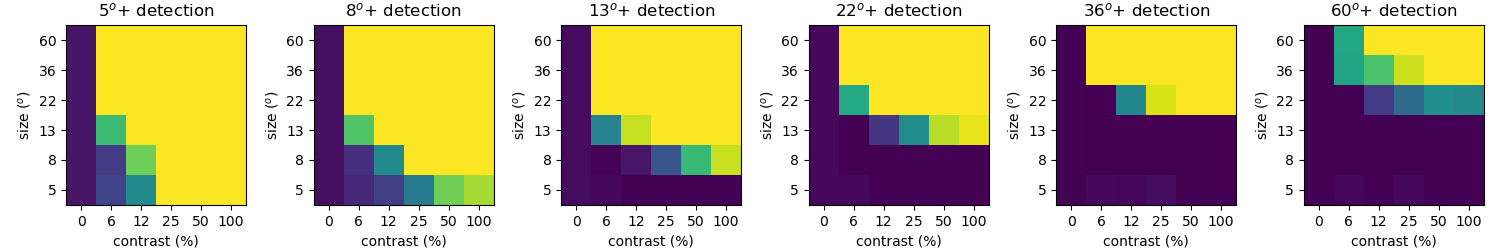

<IPython.core.display.Javascript object>


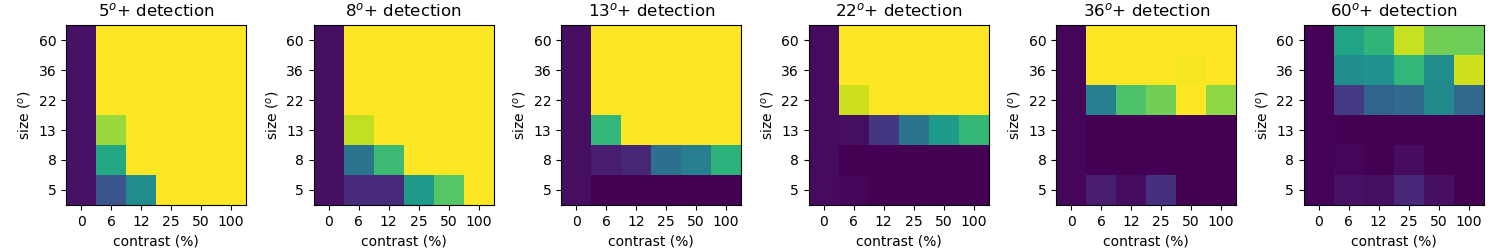

<IPython.core.display.Javascript object>


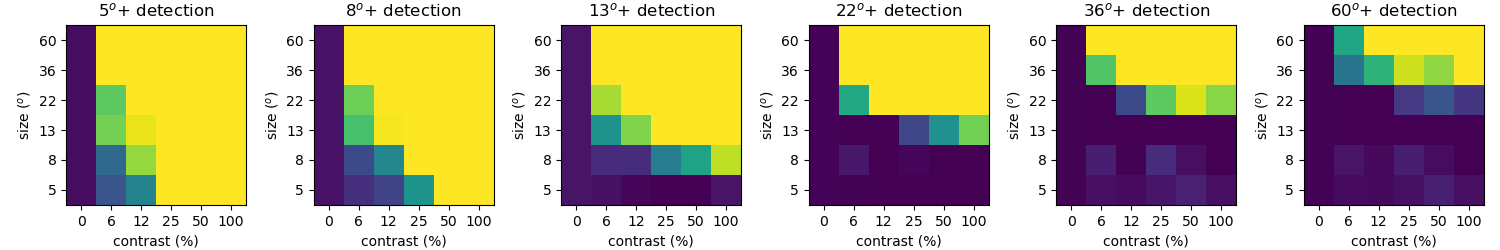

<IPython.core.display.Javascript object>


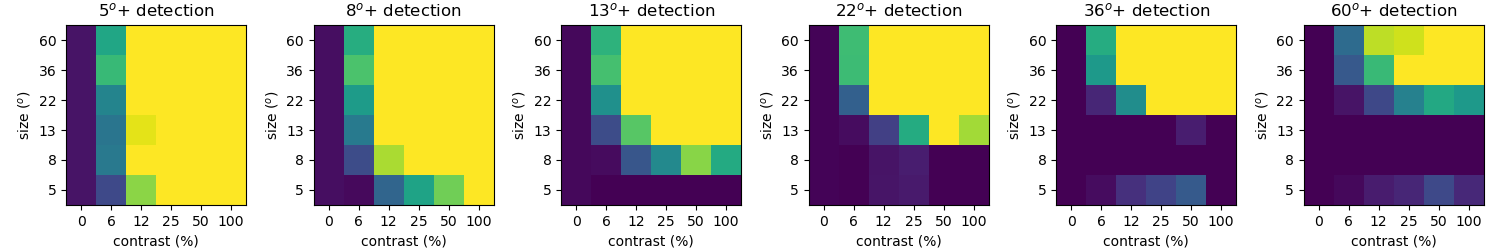

In [956]:
for iexpt in range(nexpt):
    if not reg_score_mean[iexpt] is None:
        usize = proc[irep][iexpt]['usize']
        ucontrast = proc[irep][iexpt]['ucontrast']*100
        plt.figure(figsize=(2.5*reg_score_mean[iexpt].shape[0],2.5))
        for isize in range(reg_score_mean[iexpt].shape[0]):
            plt.subplot(1,6,isize+1)
#         plt.figure()
#         for isize in range(reg_score_mean[iexpt].shape[0]):
#             plt.subplot(2,3,isize+1)
            sca.show_size_contrast(reg_score_mean[iexpt][isize].mean(-1),vmin=0,vmax=1,flipud=True,usize=usize,ucontrast=ucontrast)
            plt.title('%d$^o$+ detection'%usize[isize])
        plt.tight_layout()
#     plt.savefig('figures/annular_detection_performance_expt_%d.eps'%iexpt)

In [955]:
plt.close('all')

### The naive logistic regression approach on size axes does not yield response probabilities that look like independent detectors.

### Next, we will try running linear regression from size axis projections to contrast, and see if that produces something that looks like independent detectors.

In [991]:
def compute_XX_yy_indiv_detector(projections_train[irep],proc[irep]):
    nexpt = len(proc[irep])
    for iexpt in range(nexpt):
        if (iexpt,0,0,0) in projections_train[irep]:
            nsize = len(proc[irep][iexpt]['usize'])
            ncontrast = len(proc[irep][iexpt]['ucontrast'])
            reg_score_mean[iexpt] = np.zeros((nsize,nsize,ncontrast,nangle))
            all_gray_screen = np.zeros((nsize,nangle,0))
            for iangle in range(nangle):
                for isize in range(nsize):
                    all_gray_screen = np.concatenate((all_gray_screen,projections_train[irep][(iexpt,isize,0,iangle)]),axis=2)
            # this might be messed up-- will have to look back and make sure I am doing the right things with angles
            for iangle in range(nangle):
                for isize in range(nsize):
                    this_gray_screen = all_gray_screen.copy()
                    for jsize in range(isize):
                        for icontrast in range(1,ncontrast):
                            this_gray_screen = np.concatenate((this_gray_screen,\
                                                projections_train[irep][(iexpt,jsize,icontrast,iangle)]),axis=2)
                    y = np.zeros((this_gray_screen.shape[2],))
                    contrast_present = np.zeros((nsize,nangle,0))
                    for jsize in range(isize,nsize):
                        for icontrast in range(1,ncontrast):
                            this_data = projections_train[irep][(iexpt,jsize,icontrast,iangle)]
                            ntrials = this_data.shape[2]
                            contrast_present = np.concatenate((contrast_present,this_data),axis=2)
                            y = np.concatenate((y,icontrast*np.ones((ntrials,))),axis=0)
    #                 y = np.concatenate((np.zeros((this_gray_screen.shape[2],)),np.ones((contrast_present.shape[2],))),axis=0)
                    X = np.concatenate((this_gray_screen.reshape((nsize*nangle,-1)).T,contrast_present.reshape((nsize*nangle,-1)).T),axis=0)
                    XX[(iexpt,isize,iangle)] = X
                    yy[(iexpt,isize,iangle)] = y
    return XX,yy

SyntaxError: invalid syntax (<ipython-input-991-20e5a9548551>, line 1)

In [72]:
nangle = 4
reg = {}
reg_score = {}
reg_score_mean = [None for _ in range(nexpt)]
XX = {}
yy = {}
for iexpt in range(nexpt):
    if (iexpt,0,0,0) in projections_train[irep]:
        nsize = len(proc[irep][iexpt]['usize'])
        ncontrast = len(proc[irep][iexpt]['ucontrast'])
        reg_score_mean[iexpt] = np.zeros((nsize,nsize,ncontrast,nangle))
        all_gray_screen = np.zeros((nsize,nangle,0))
        for iangle in range(nangle):
            for isize in range(nsize):
                all_gray_screen = np.concatenate((all_gray_screen,projections_train[irep][(iexpt,isize,0,iangle)]),axis=2)
        # this might be messed up-- will have to look back and make sure I am doing the right things with angles
        for iangle in range(nangle):
            for isize in range(nsize):
                this_gray_screen = all_gray_screen.copy()
                for jsize in range(isize):
                    for icontrast in range(1,ncontrast):
                        this_gray_screen = np.concatenate((this_gray_screen,\
                                            projections_train[irep][(iexpt,jsize,icontrast,iangle)]),axis=2)
                y = np.zeros((this_gray_screen.shape[2],))
                contrast_present = np.zeros((nsize,nangle,0))
                for jsize in range(isize,nsize):
                    for icontrast in range(1,ncontrast):
                        this_data = projections_train[irep][(iexpt,jsize,icontrast,iangle)]
                        ntrials = this_data.shape[2]
                        contrast_present = np.concatenate((contrast_present,this_data),axis=2)
                        y = np.concatenate((y,icontrast*np.ones((ntrials,))),axis=0)
#                 y = np.concatenate((np.zeros((this_gray_screen.shape[2],)),np.ones((contrast_present.shape[2],))),axis=0)
                X = np.concatenate((this_gray_screen.reshape((nsize*nangle,-1)).T,contrast_present.reshape((nsize*nangle,-1)).T),axis=0)
                XX[(iexpt,isize,iangle)] = X
                yy[(iexpt,isize,iangle)] = y
for iexpt in range(nexpt):
    if (iexpt,0,0,0) in projections_train[irep]:
        nsize = len(proc[irep][iexpt]['usize'])
        ncontrast = len(proc[irep][iexpt]['ucontrast'])
        for isize in range(nsize):
            for iangle in range(nangle):
                X,y = XX[(iexpt,isize,iangle)],yy[(iexpt,isize,iangle)]
                linreg = sklearn.linear_model.LinearRegression()
                reg[(iexpt,isize,iangle)] = linreg.fit(X,y)
        
        all_gray_screen = np.zeros((nsize,nangle,0))
        for iangle in range(nangle):
            for isize in range(nsize):
                all_gray_screen = np.concatenate((all_gray_screen,projections[irep][(iexpt,isize,0,iangle)]),axis=2)
        for iangle in range(nangle):
            for isize in range(nsize):
                for icontrast in range(ncontrast):
                    if icontrast == 0:
                        contrast_present = all_gray_screen.copy()
                    else:
                        contrast_present = projections[irep][(iexpt,isize,icontrast,iangle)].copy()
                    X = contrast_present.reshape((nsize*nangle,-1)).T
                    for jsize in range(nsize):
                        reg_score[(iexpt,jsize,isize,icontrast,iangle)] = reg[(iexpt,jsize,iangle)].predict(X)
                        reg_score_mean[iexpt][jsize,isize,icontrast,iangle] = reg_score[(iexpt,jsize,isize,icontrast,iangle)].mean()

<IPython.core.display.Javascript object>


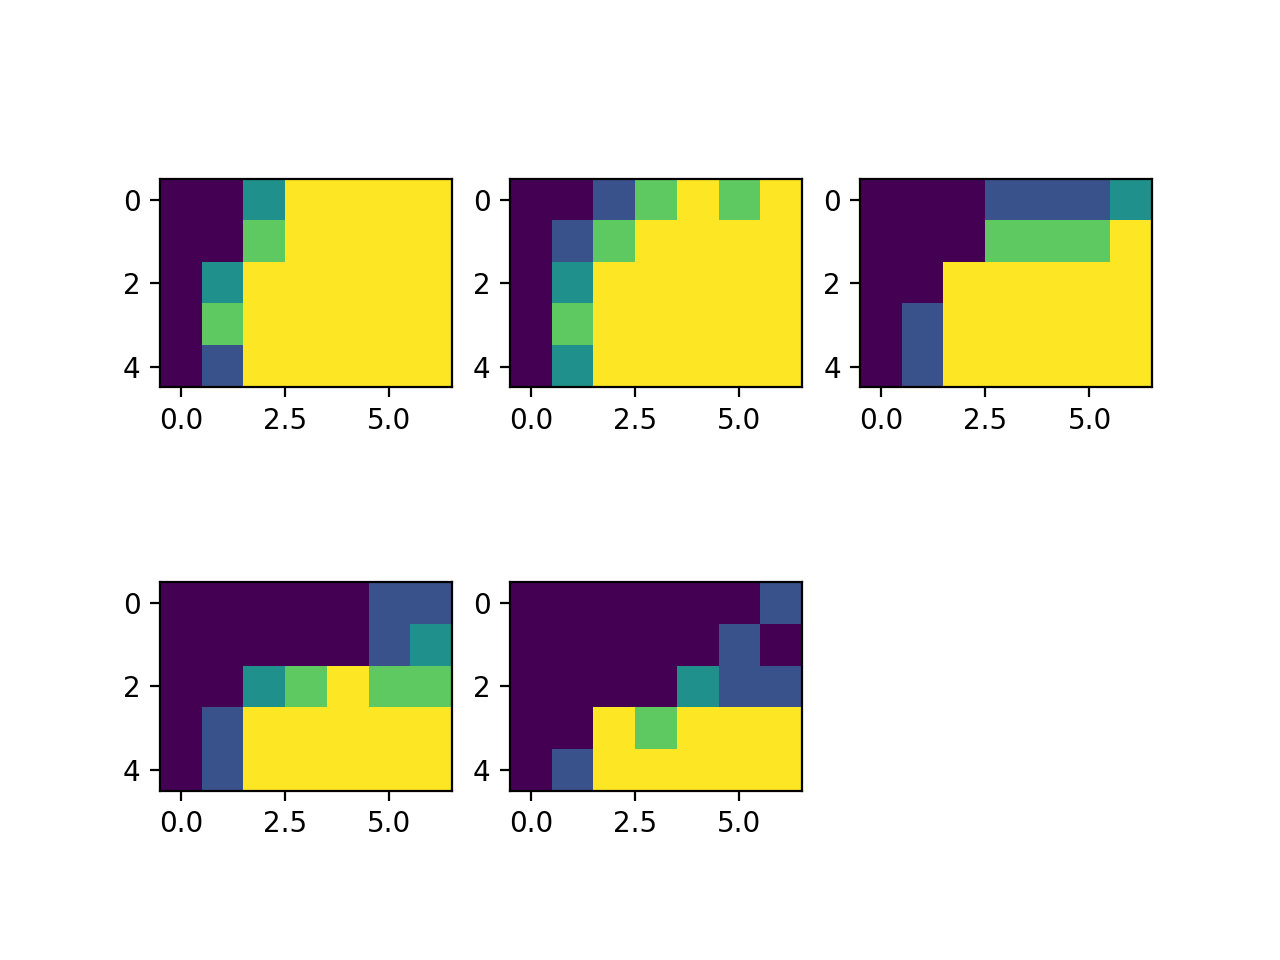

<IPython.core.display.Javascript object>


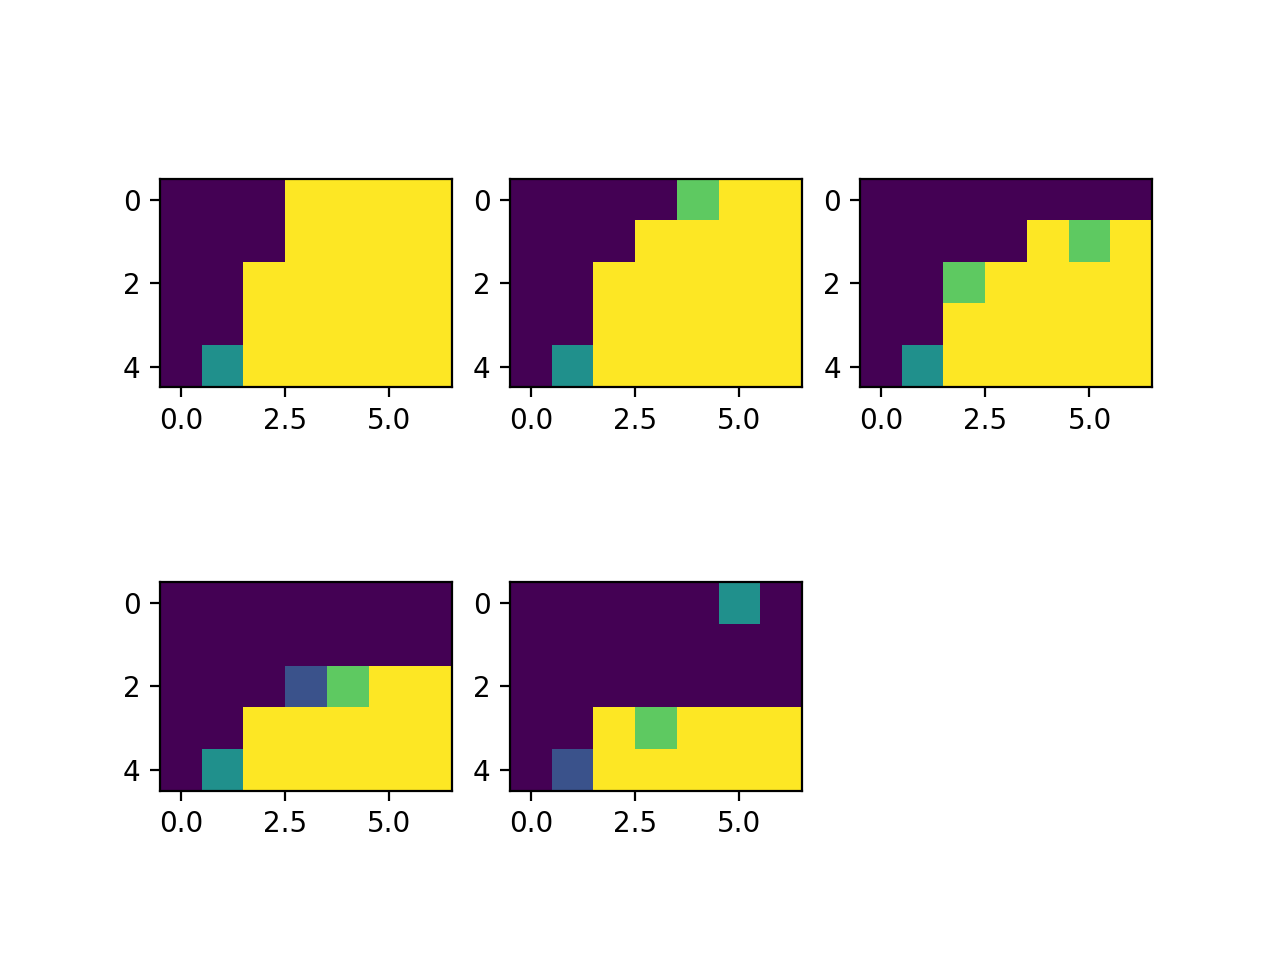

<IPython.core.display.Javascript object>


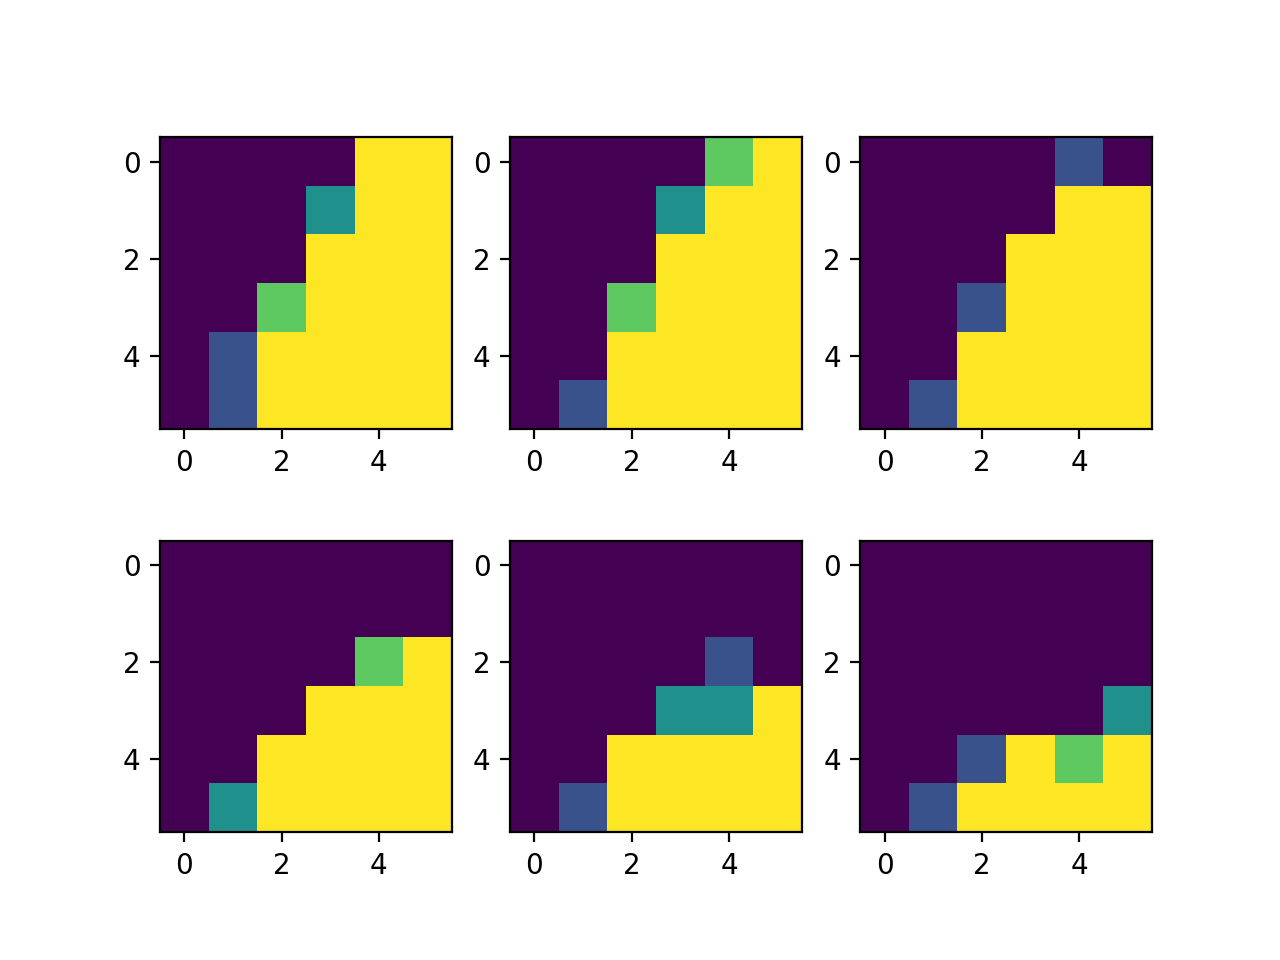

<IPython.core.display.Javascript object>


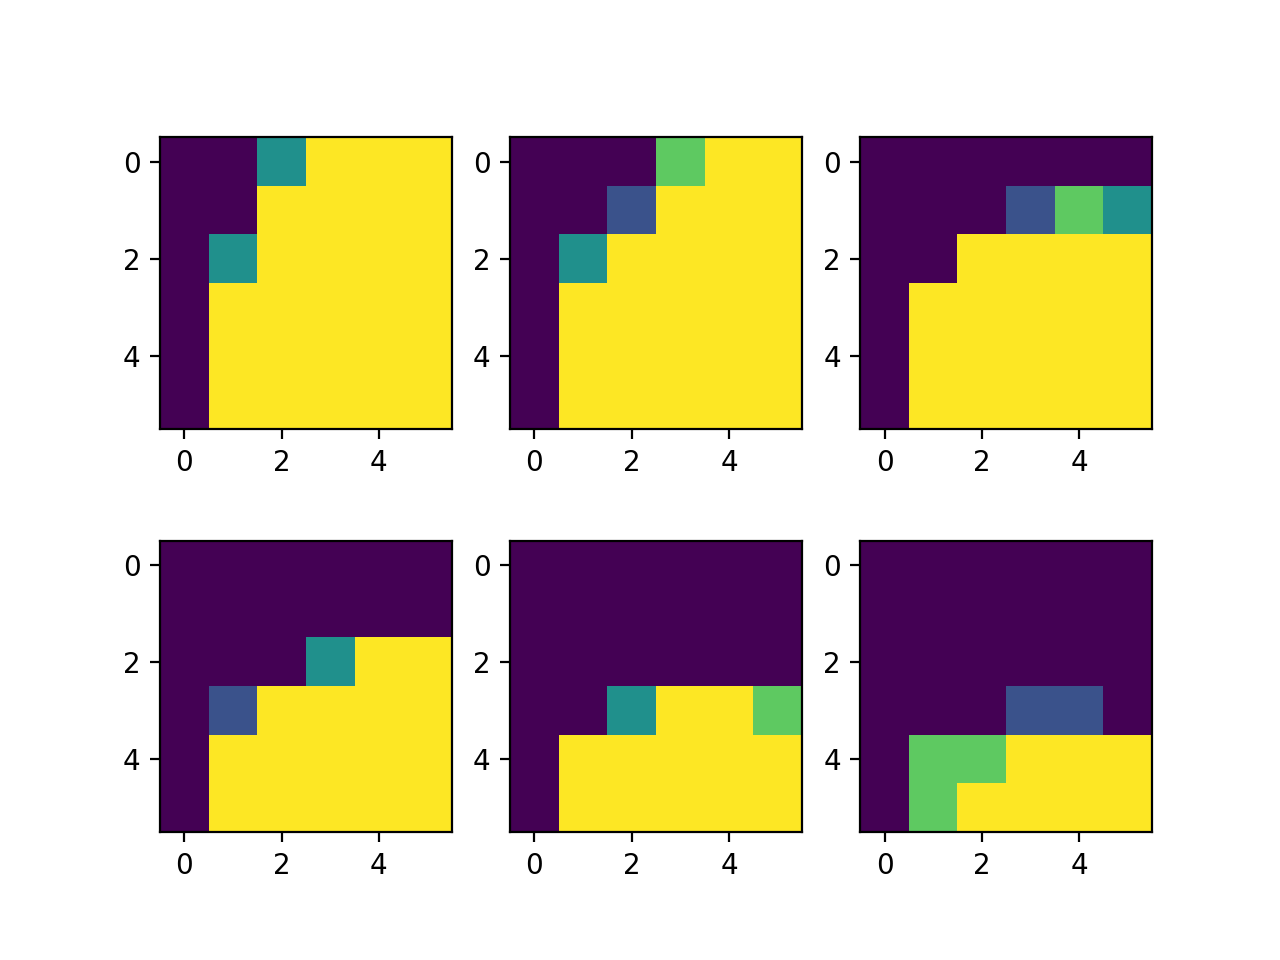

<IPython.core.display.Javascript object>


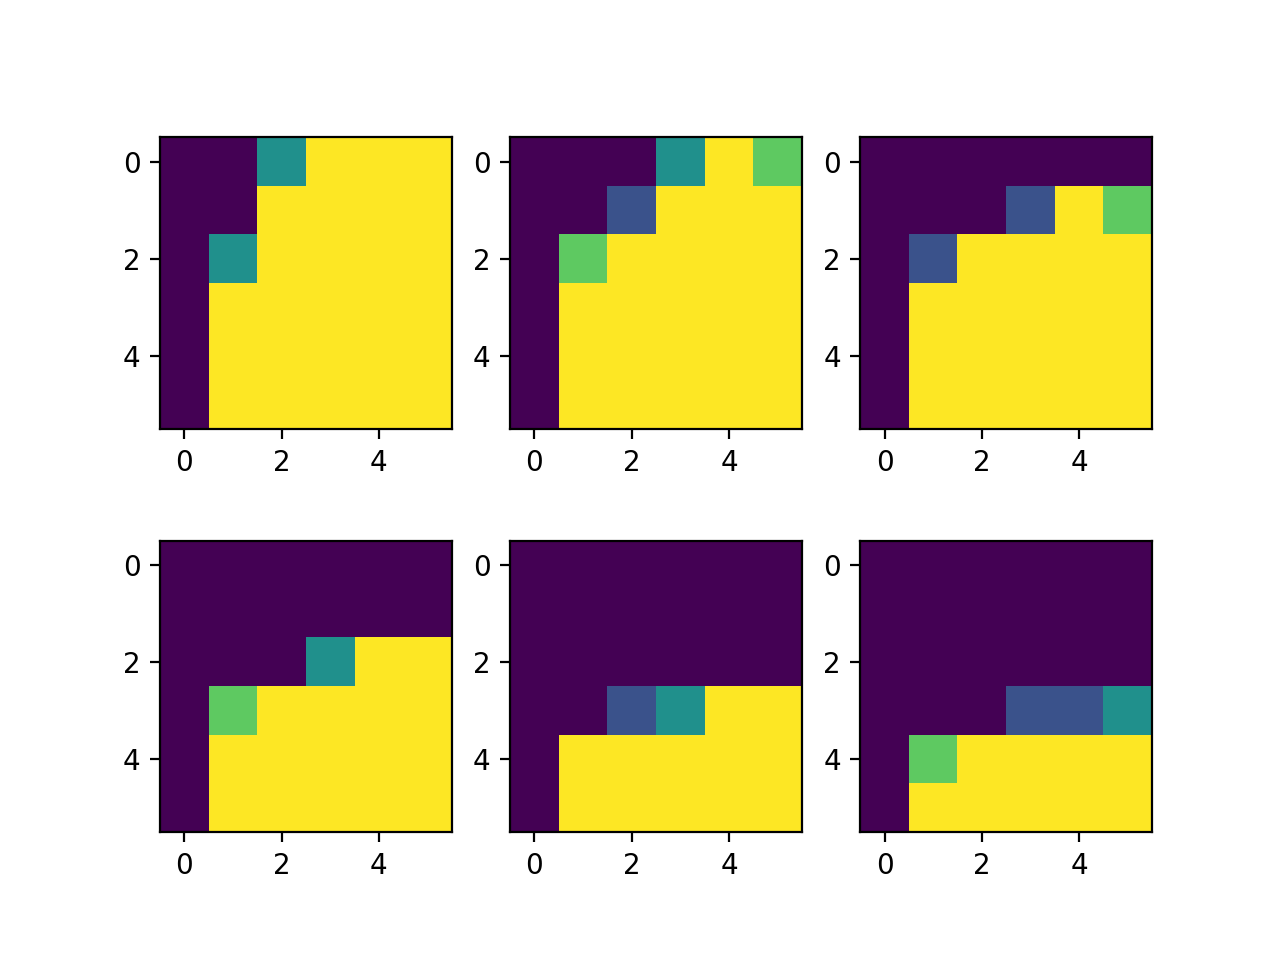

<IPython.core.display.Javascript object>


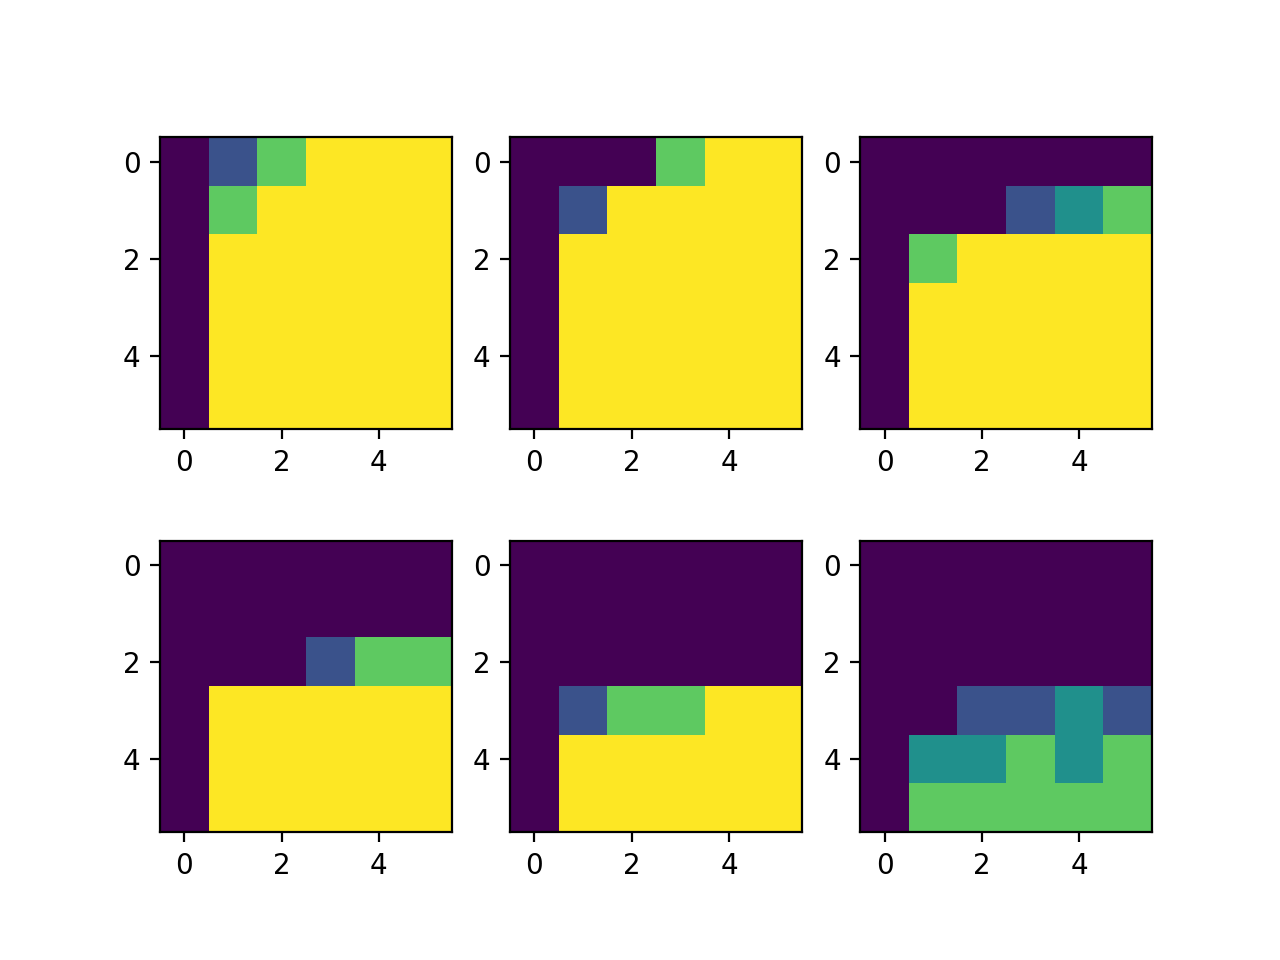

<IPython.core.display.Javascript object>


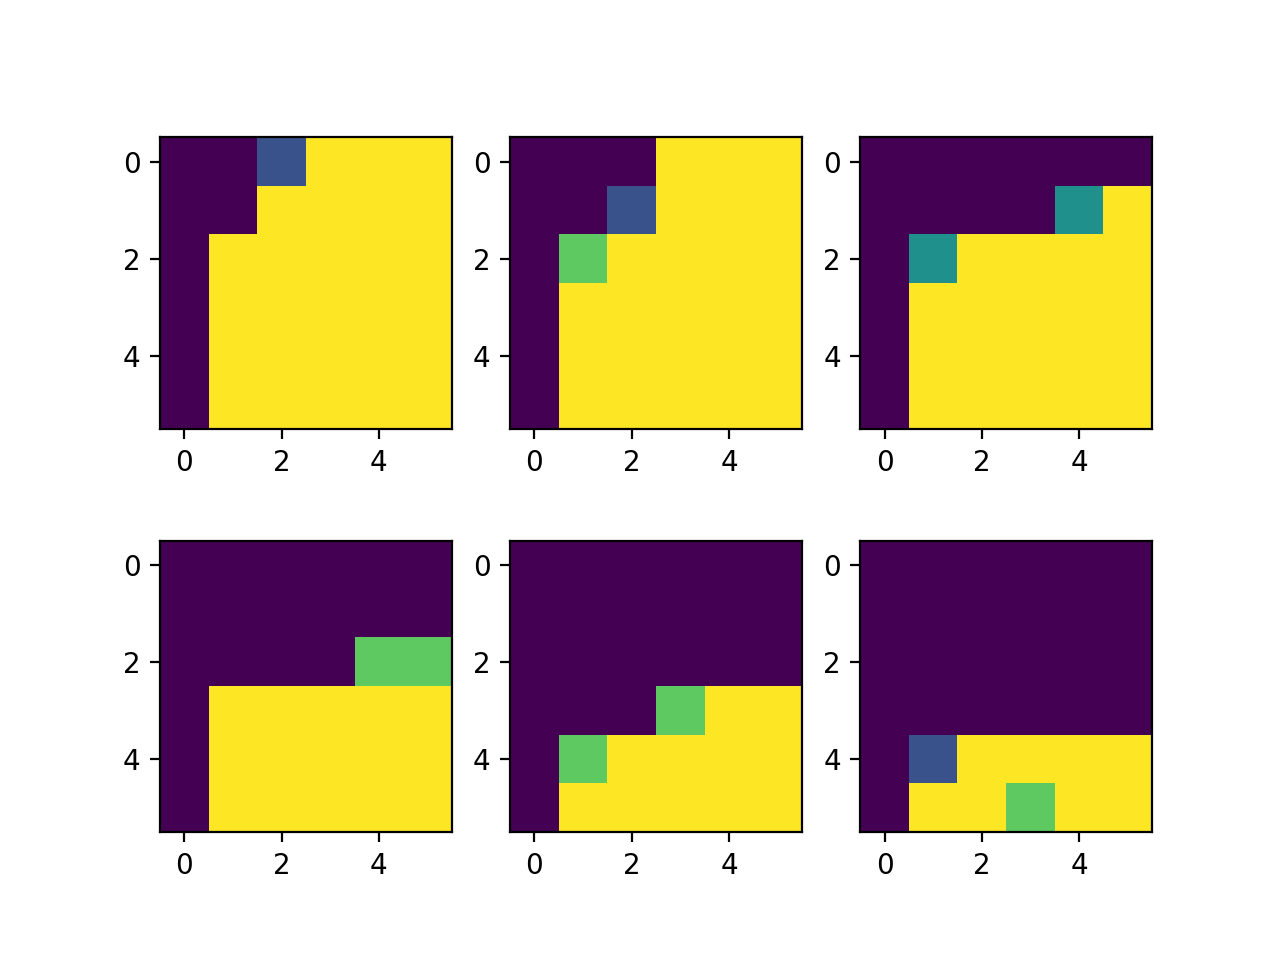

<IPython.core.display.Javascript object>


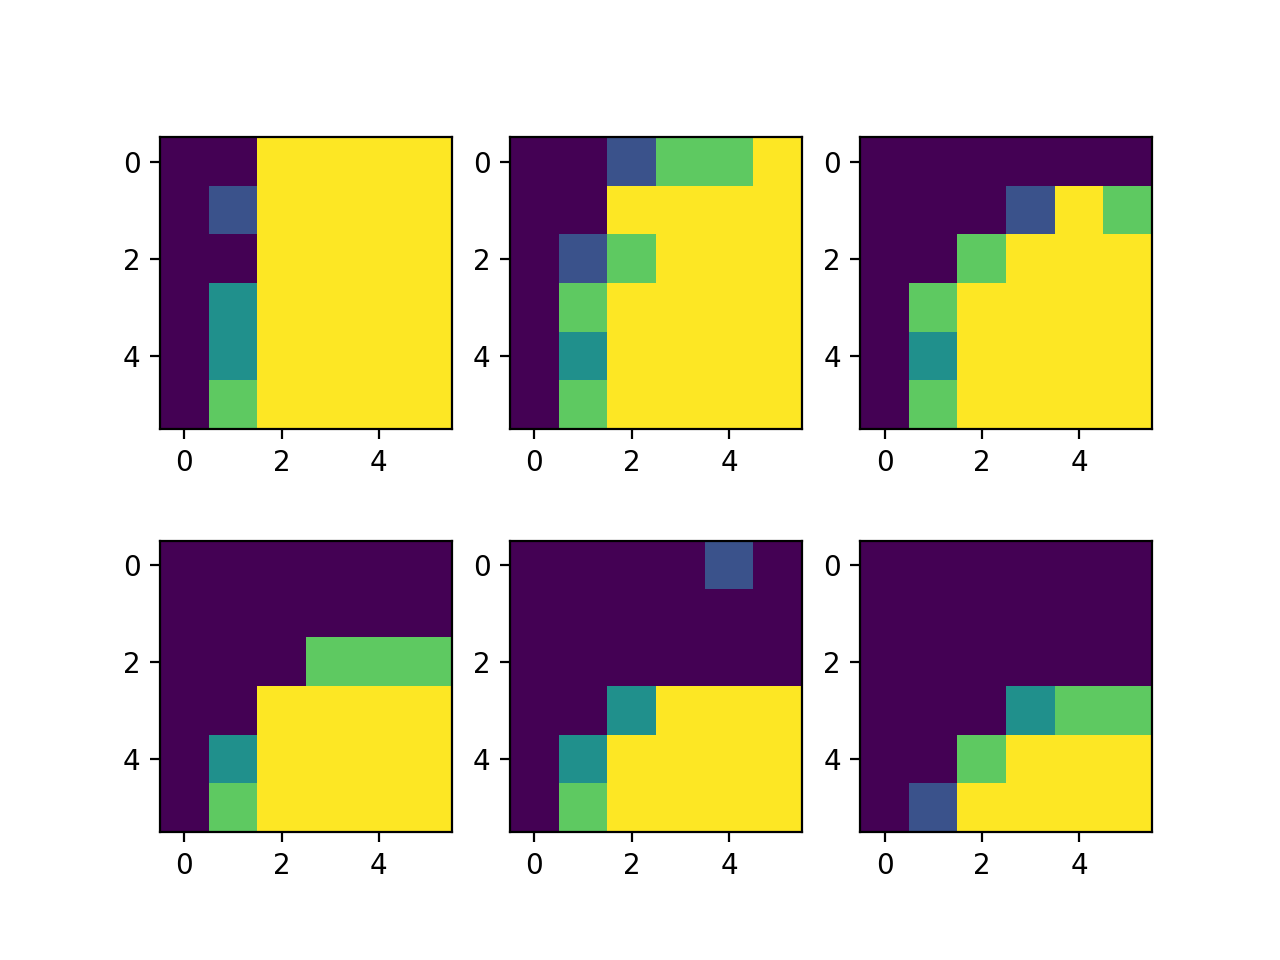

In [73]:
for iexpt in range(nexpt):
    if not reg_score_mean[iexpt] is None:
        plt.figure()
        for isize in range(reg_score_mean[iexpt].shape[0]):
            plt.subplot(2,3,isize+1)
            plt.imshow((reg_score_mean[iexpt][isize]>0.5).mean(-1),vmin=0,vmax=1)

In [74]:
irep = 0
iexpt = 0
icutoff = 0
isize = 0
iangle = 0

In [75]:
proc[irep][iexpt]['u'][:,:proc[irep][iexpt]['cutoffs'][icutoff]].shape

(1709, 20)

In [76]:
contrast_axis,contrast_axis_svd = [[[None for _ in p] for p in proc] for _ in range(2)]
for irep in range(nreps):
    for iexpt in range(len(proc[irep])):
        if not reg[irep][iexpt][icutoff] is None:
            contrast_axis[irep][iexpt],contrast_axis_svd[irep][iexpt] = [[None for _ in reg[irep][iexpt][icutoff]] for _ in range(2)]
            for isize in range(len(reg[irep][iexpt][icutoff])):
                contrast_axis[irep][iexpt][isize],contrast_axis_svd[irep][iexpt][isize] = [[None for _ in reg[irep][iexpt][icutoff][isize]] for _ in range(2)]
                for iangle in range(len(reg[irep][iexpt][icutoff][isize])):
                    contrast_axis[irep][iexpt][isize][iangle] = proc[irep][iexpt]['u'][:,:proc[irep][iexpt]['cutoffs'][icutoff]] @ reg[irep][iexpt][icutoff][isize][iangle].coef_
                    contrast_axis_svd[irep][iexpt][isize][iangle] = reg[irep][iexpt][icutoff][isize][iangle].coef_
                contrast_axis[irep][iexpt][isize] = np.concatenate([c[np.newaxis] for c in contrast_axis[irep][iexpt][isize]])
                contrast_axis_svd[irep][iexpt][isize] = np.concatenate([c[np.newaxis] for c in contrast_axis_svd[irep][iexpt][isize]])
            contrast_axis[irep][iexpt] = np.concatenate([c[np.newaxis] for c in contrast_axis[irep][iexpt]])
            contrast_axis_svd[irep][iexpt] = np.concatenate([c[np.newaxis] for c in contrast_axis_svd[irep][iexpt]])

KeyError: 0

In [77]:
for iexpt in range(len(contrast_axis)):
    if not contrast_axis[irep][iexpt] is None:
        plt.figure()
        for isize in range(contrast_axis_svd[irep][iexpt].shape[0]):
            plt.subplot(2,3,isize+1)
            plt.imshow(ssd.squareform(ssd.pdist(contrast_axis_svd[irep][iexpt][isize],metric='cosine')),vmin=0,vmax=2)

In [78]:
for iexpt in range(len(contrast_axis_svd)):
    if not contrast_axis_svd[irep][iexpt] is None:
        plt.figure()
        for iangle in range(contrast_axis_svd[irep][iexpt].shape[1]):
            plt.subplot(2,2,iangle+1)
            plt.imshow(ssd.squareform(ssd.pdist(contrast_axis_svd[irep][iexpt][:,iangle],metric='cosine')),vmin=0,vmax=2)

<IPython.core.display.Javascript object>


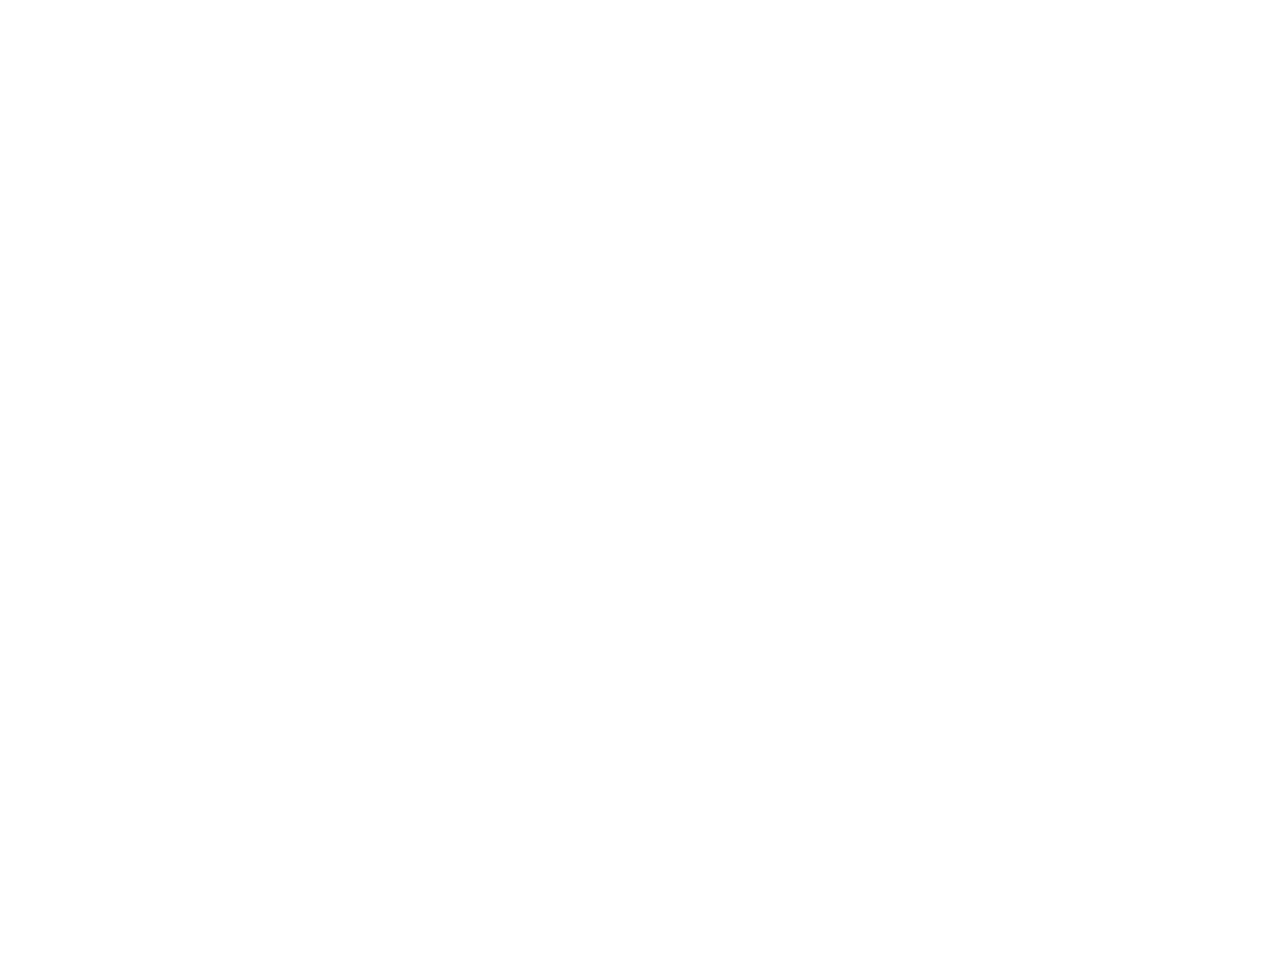

TypeError: 'NoneType' object is not subscriptable

In [79]:
plt.figure()
iexpt = 0
isize = 0
iangle1,iangle2 = 0,1
plt.scatter(contrast_axis[irep][iexpt][isize,iangle1],contrast_axis[irep][iexpt][isize,iangle2],s=1)

In [220]:
# for iexpt in range(len(tuning)):
#     if not tuning[iexpt] is None and not contrast_axis[irep][iexpt] is None:
#         data = np.nanmean(np.nanmean(tuning[iexpt][:,:,:,:,8:-8],4),3)
#         if contrast_axis[irep][iexpt] is None:
#             print(str((irep,iexpt)) + ' is None')
#         else:
#             print(iexpt)
#             if data.shape[1] == 5:
#                 usize = np.array((5,8,13,22,36))
#             else:
#                 usize = np.array((5,8,13,22,36,60))
#             if data.shape[2] == 6:
#                 ucontrast = np.array((0,6,12,25,50,100))
#             else:
#                 ucontrast = np.array((0,3,6,12,25,50,100))
#             plt.figure()
#             for isize in range(contrast_axis[irep][iexpt].shape[0]):
#                 plt.subplot(2,3,isize+1)
#                 top = [contrast_axis[irep][iexpt][isize,iangle]>np.percentile(contrast_axis[irep][iexpt][isize,iangle],95) \
#                        for iangle in range(contrast_axis[irep][iexpt].shape[1])]
                
#                 sca.show_size_contrast(np.nanmean(np.concatenate([data[t] for t in top]),0),flipud=True,usize=usize,ucontrast=ucontrast)
#                 plt.title('%d$^o$ axis'%usize[isize])
#             plt.tight_layout()
#             if iexpt == 5:
#                 plt.savefig('figures/example_mean_tuning_by_axis.eps')
#                 print('got here')
#             plt.figure()
#             for isize in range(contrast_axis[irep][iexpt].shape[0]):
#                 plt.subplot(2,3,isize+1)
#                 plt.hist(contrast_axis[irep][iexpt][isize,:].flatten(),bins=np.linspace(-0.075,0.075,41))
#                 plt.ylim((0,4000))
#             plt.tight_layout()

In [148]:
nrep,nexpt = len(contrast_axis),len(contrast_axis[0])
nsize_max = 6
wt_sd = np.nan*np.ones((nrep,nexpt,nsize_max))
for irep in range(nrep):
    for iexpt in range(nexpt):
        if not contrast_axis[irep][iexpt] is None:
            nsize = contrast_axis[irep][iexpt].shape[0]
            for isize in range(nsize):
                wt_sd[irep,iexpt,isize] = contrast_axis[irep][iexpt][isize,:].flatten().std()

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


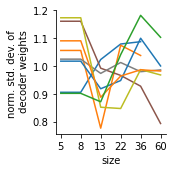

In [149]:
    plt.figure(figsize=(2.5,2.5))
    plt.plot((np.nanmean(wt_sd[:,:,:],0)/np.nanmean(np.nanmean(wt_sd[:,:,:],0),1)[:,np.newaxis]).T)
    plt.xlabel('size')
    plt.xticks(np.arange(6),usize)
    plt.ylabel('norm. std. dev. of \n decoder weights')
    ut.erase_top_right()
    plt.tight_layout()
    plt.savefig('figures/decoder_weight_distribution_vs_size.eps')

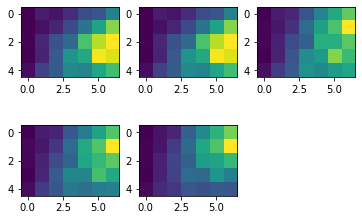

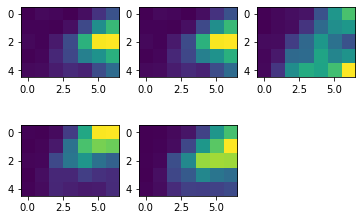

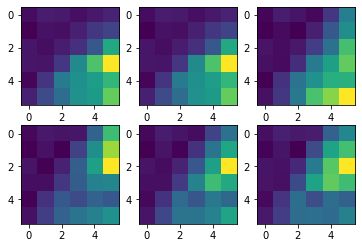

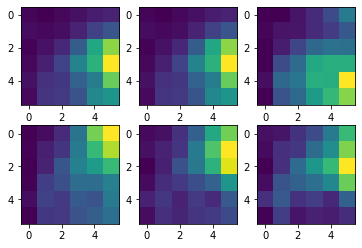

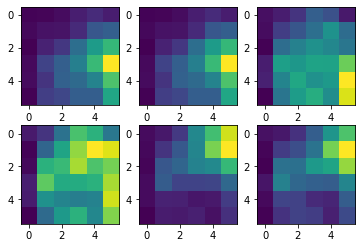

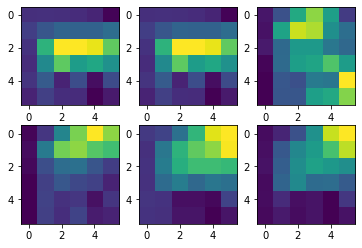

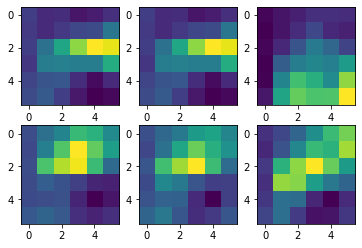

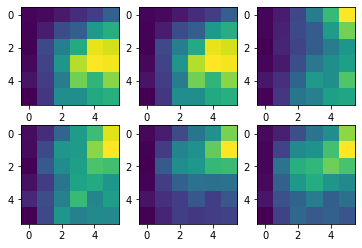

In [150]:
for iexpt in range(len(tuning)):
    if not tuning[iexpt] is None and not contrast_axis[irep][iexpt] is None:
        data = np.nanmean(np.nanmean(tuning[iexpt][:,:,:,:,8:-8],4),3)
        plt.figure()
        for isize in range(contrast_axis[irep][iexpt].shape[0]):
            plt.subplot(2,3,isize+1)
            top = [contrast_axis[irep][iexpt][isize,iangle]<np.percentile(contrast_axis[irep][iexpt][isize,iangle],5) \
                   for iangle in range(contrast_axis[irep][iexpt].shape[1])]
            plt.imshow(np.nanmean(np.concatenate([data[t] for t in top]),0))

In [91]:
hit_mean = [np.nan*np.ones((len(hit[irep]),modal_uparam[0].size,modal_uparam[1].size)) for irep in range(nreps)]
for irep in range(nreps):
    for iexpt in range(hit_mean[irep].shape[0]):
        if not hit[irep][iexpt] is None:
            this_data = np.nanmean(hit[irep][iexpt],axis=2)
            this_uparam = [proc[irep][iexpt]['usize'],proc[irep][iexpt]['ucontrast']]
            ut.assign_from_uparam(hit_mean[irep][iexpt],modal_uparam,this_data,this_uparam,ignore_first=0)
hit_mean = np.concatenate([h[np.newaxis] for h in hit_mean],axis=0)
hit_mean = np.nanmean(hit_mean,0)

/Users/dan/Documents/code/adesnal/pyute.py:1723: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  big_ind = big_ind*iit[slc]
/Users/dan/Documents/code/adesnal/pyute.py:1714: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a[[slice(None) for iind in range(ignore_first)]+[a_bool]] = b[[slice(None) for iind in range(ignore_first)]+[b_bool]]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


In [92]:
ind_detector_hit[0].shape

(5, 5, 5, 7, 4)

In [93]:
# nexpt = len(ind_detector_hit)
nsize = modal_uparam[0].size
ncontrast = modal_uparam[1].size
hit_mean_ind = [np.nan*np.ones((nexpt,nsize,nsize,ncontrast)) for irep in range(nreps)]
for irep in range(nreps):
    for iexpt in range(len(ind_detector_hit)):
        if not hit[irep][iexpt] is None:
            this_uparam = [proc[irep][iexpt]['usize'],proc[irep][iexpt]['ucontrast']]
            for jsize in range(ind_detector_hit[iexpt].shape[1]):
                this_data = np.nanmean(ind_detector_hit[iexpt][irep,jsize],axis=2)
                ut.assign_from_uparam(hit_mean_ind[irep][iexpt,jsize],modal_uparam,this_data,this_uparam,ignore_first=0)
hit_mean_ind = np.stack(hit_mean_ind)
hit_mean_ind = np.nanmean(hit_mean_ind,0)

/Users/dan/Documents/code/adesnal/pyute.py:1723: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  big_ind = big_ind*iit[slc]
/Users/dan/Documents/code/adesnal/pyute.py:1714: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  a[[slice(None) for iind in range(ignore_first)]+[a_bool]] = b[[slice(None) for iind in range(ignore_first)]+[b_bool]]
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [191]:
import scipy.optimize as sop
usize = np.array((5,8,13,22,36,60))
usize0 = np.concatenate(((0,),usize))
ucontrast = np.array((0,3,6,12,25,50,100))
# plt.figure(figsize=(2.5,2.5))
jsize = 2

# sigma = 1
# plt.plot([np.log10(compute_multiplier(d0,d1in,d1out,sigma)) for d0 in usize])
# sigma = 5
# plt.plot([np.log10(compute_multiplier(d0,d1in,d1out,sigma)) for d0 in usize])

all_sigma = np.zeros((len(usize),))
all_mults = np.zeros((len(usize),len(usize)))
all_ys = np.zeros((len(usize),len(usize),len(ucontrast)))

for jsize in range(len(usize)):
    print(jsize)
    d1in = usize0[jsize]
    d1out = usize0[jsize+1]
    tgt = np.nanmean(hit_mean_ind[:,jsize],0)
    msk = ~np.isnan(tgt)
    def cost(sigma):
        ys = np.zeros_like(tgt)
        this_nn = (d1out**2 - d1in**2)*np.ones((len(ucontrast),1))
        mults = np.zeros((len(usize),))
        for isize,d0 in enumerate(usize):
            mults[isize] = compute_multiplier(d0,d1in,d1out,sigma)
        for isize,mult in enumerate(mults):
            this_c = ucontrast*mult
            this_nnxx = np.concatenate((this_nn,this_c[:,np.newaxis]),axis=1)
            this_y = wa.weibull_function_n_one_arg(this_nnxx,*popt_all)
            ys[isize] = this_y
        return np.sum((tgt[msk]-ys[msk])**2)

    bds = sop.Bounds(0,np.inf)
    result = sop.minimize(cost,x0=(2,),bounds=bds)
    all_sigma[jsize] = result.x[0]
    for isize,d0 in enumerate(usize):
        all_mults[jsize,isize] = compute_multiplier(d0,d1in,d1out,all_sigma[jsize])
    for isize,mult in enumerate(all_mults[jsize]):
        this_c = ucontrast*mult
        this_nnxx = np.concatenate((this_nn,this_c[:,np.newaxis]),axis=1)
        this_y = wa.weibull_function_n_one_arg(this_nnxx,*popt_all)
        all_ys[jsize,isize] = this_y

# costs = [cost(n) for n in (0.5,)+tuple(np.arange(1,5))]
# plt.figure(figsize=(2.5,2.5))
# plt.plot(costs)

# for sigma in [1,5]:
#     plt.figure(figsize=(2.5,2.5))
#     for mult in [compute_multiplier(d0,d1in,d1out,sigma) for d0 in usize]:
# #         this_c = np.logspace(0,2,100)*mult
#         this_c = ucontrast*mult
#         this_nnxx = np.concatenate(((d1out**2 - d1in**2)*np.ones((len(this_c),1)),this_c[:,np.newaxis]),axis=1)
#         this_y = wa.weibull_function_n_one_arg(this_nnxx,*popt_all)
#         plt.plot(this_y)

0


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in multiply
  
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: 

1
2
3


/Users/dan/Documents/code/adesnal/weibull_analysis.py:18: RuntimeWarning: invalid value encountered in power
  return a0+(1-a0-a1)*(1-np.exp(-n*(c/b)**k))


4
5


In [185]:
import scipy.optimize as sop
usize = np.array((5,8,13,22,36,60))
usize0 = np.concatenate(((0,),usize))
ucontrast = np.array((0,3,6,12,25,50,100))
# plt.figure(figsize=(2.5,2.5))
jsize = 2

# sigma = 1
# plt.plot([np.log10(compute_multiplier(d0,d1in,d1out,sigma)) for d0 in usize])
# sigma = 5
# plt.plot([np.log10(compute_multiplier(d0,d1in,d1out,sigma)) for d0 in usize])

all_sigma = np.zeros((len(usize),))
all_fa = np.zeros((len(usize),))
all_mults = np.zeros((len(usize),len(usize)))
all_ys = np.zeros((len(usize),len(usize),len(ucontrast)))

for jsize in range(len(usize)):
    print(jsize)
    d1in = usize0[jsize]
    d1out = usize0[jsize+1]
    tgt = np.nanmean(hit_mean_ind[:,jsize],0)
    msk = ~np.isnan(tgt)
    def cost(x):
        sigma,fa = x
        ys = np.zeros_like(tgt)
        this_nn = (d1out**2 - d1in**2)*np.ones((len(ucontrast),1))
        mults = np.zeros((len(usize),))
        for isize,d0 in enumerate(usize):
            mults[isize] = compute_multiplier(d0,d1in,d1out,sigma)
        for isize,mult in enumerate(mults):
            this_c = ucontrast*mult
            this_nnxx = np.concatenate((this_nn,this_c[:,np.newaxis]),axis=1)
            this_y = wa.weibull_function_n_one_arg(this_nnxx,fa,*popt_all[1:])
            ys[isize] = this_y
        return np.sum((tgt[msk]-ys[msk])**2)

    bds = sop.Bounds(np.array((0,0)),np.array((np.inf,1)))
    result = sop.minimize(cost,x0=(2,0.2),bounds=bds)
    all_sigma[jsize] = result.x[0]
    all_fa[jsize] = result.x[1]
    for isize,d0 in enumerate(usize):
        all_mults[jsize,isize] = compute_multiplier(d0,d1in,d1out,all_sigma[jsize])
    for isize,mult in enumerate(all_mults[jsize]):
        this_c = ucontrast*mult
        this_nnxx = np.concatenate((this_nn,this_c[:,np.newaxis]),axis=1)
        this_y = wa.weibull_function_n_one_arg(this_nnxx,all_fa[jsize],*popt_all[1:])
        all_ys[jsize,isize] = this_y

# costs = [cost(n) for n in (0.5,)+tuple(np.arange(1,5))]
# plt.figure(figsize=(2.5,2.5))
# plt.plot(costs)

# for sigma in [1,5]:
#     plt.figure(figsize=(2.5,2.5))
#     for mult in [compute_multiplier(d0,d1in,d1out,sigma) for d0 in usize]:
# #         this_c = np.logspace(0,2,100)*mult
#         this_c = ucontrast*mult
#         this_nnxx = np.concatenate(((d1out**2 - d1in**2)*np.ones((len(this_c),1)),this_c[:,np.newaxis]),axis=1)
#         this_y = wa.weibull_function_n_one_arg(this_nnxx,*popt_all)
#         plt.plot(this_y)

0


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice


1
2


/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in double_scalars
  from ipykernel import kernelapp as app
/opt/anaco

3
4
5


In [210]:
all_mults = np.zeros((len(usize),len(usize)))
all_ys = np.zeros((len(usize),len(usize),len(ucontrast)))

for jsize in range(len(usize)):
    print(jsize)
    d1in = usize0[jsize]
    d1out = usize0[jsize+1]
    this_nn = (d1out**2 - d1in**2)*np.ones((len(ucontrast),1))
    for isize,d0 in enumerate(usize):
        all_mults[jsize,isize] = compute_multiplier(d0,d1in,d1out,all_sigma[jsize])
    for isize,mult in enumerate(all_mults[jsize]):
        this_c = ucontrast*mult
        this_nnxx = np.concatenate((this_nn,this_c[:,np.newaxis]),axis=1)
        this_y = wa.weibull_function_n_one_arg(this_nnxx,all_fa[jsize],*popt_all[1:])
        all_ys[jsize,isize] = this_y

0
1
2
3
4
5


<IPython.core.display.Javascript object>


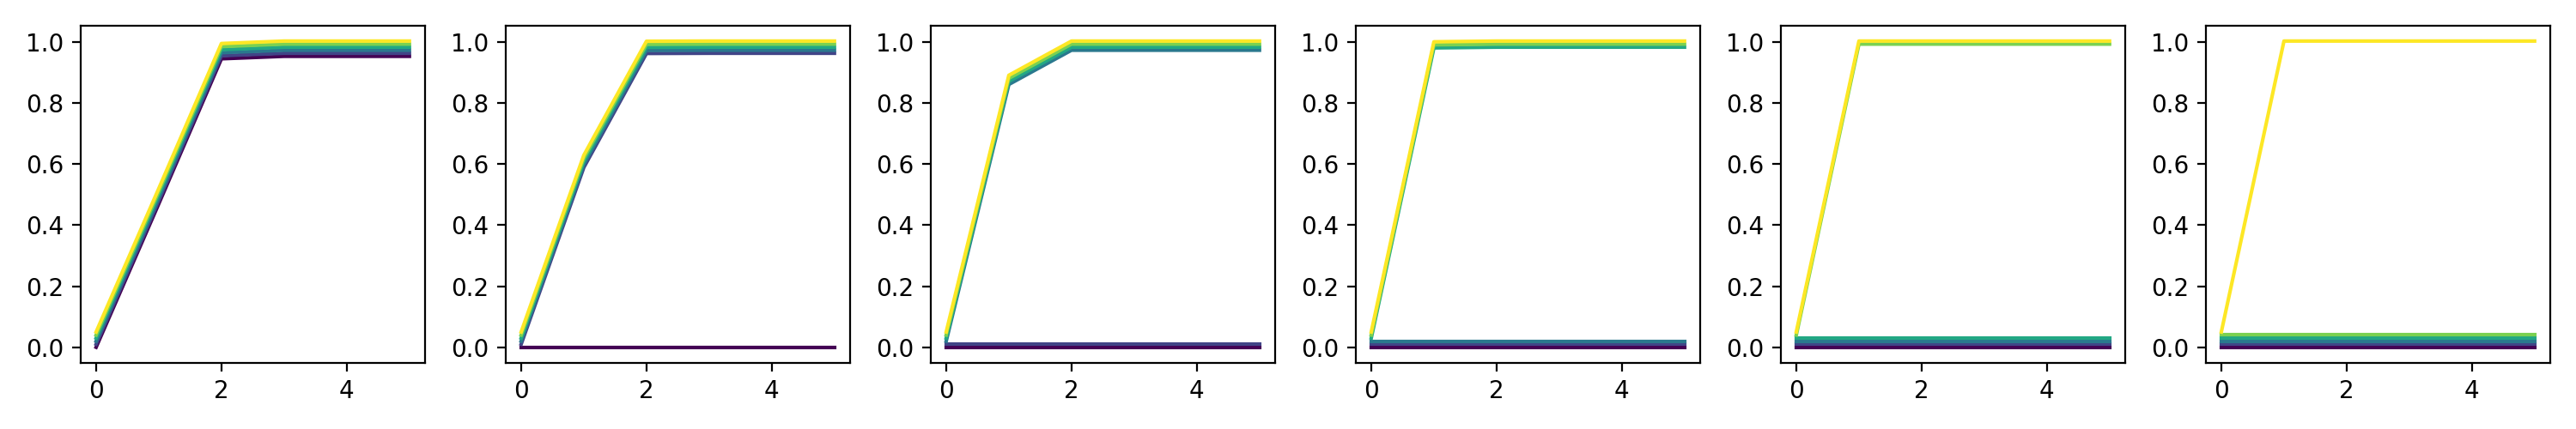

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

linewidth: 1
plotting
1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
1.0033583181229366
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


<IPython.core.display.Javascript object>


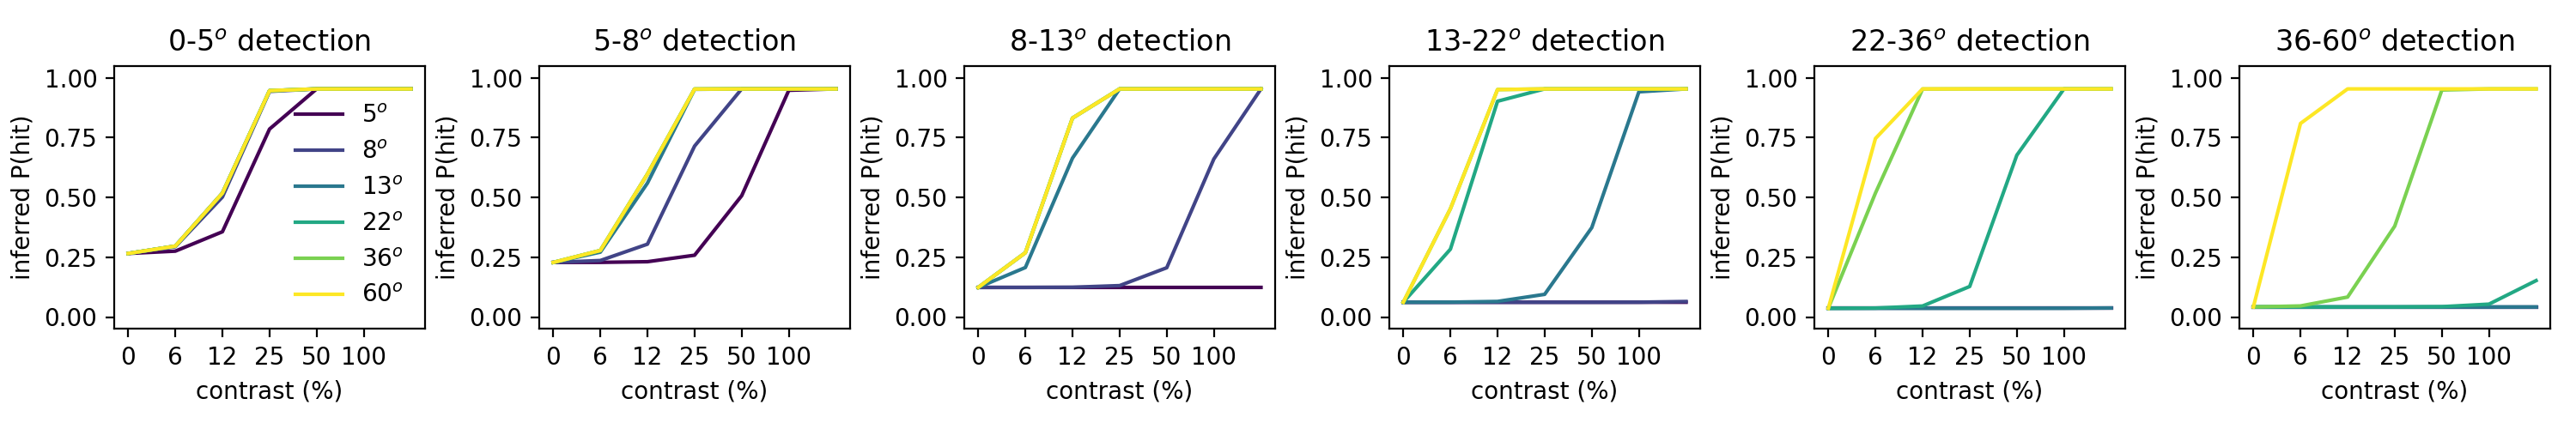

In [250]:
plt.figure(figsize=(15,2.5))
ucontrast = np.array((0,6,12,25,50,100))
for jsize in range(6):
    plt.subplot(1,6,jsize+1)
    offset = 0.01*np.arange(6)[np.newaxis,:,np.newaxis]
    ut.plot_bootstrapped_errorbars_hillel(np.arange(len(ucontrast)),Phit[jsize:jsize+1,:,[0,2,3,4,5,6]]+offset,markersize=0)

plt.tight_layout()
if save_fig:
    plt.savefig('figures/inferred_annular_detection_p_hit.eps')

colors = plt.cm.viridis(np.linspace(0,1,hit_mean_ind.shape[1]))
plt.figure(figsize=(15,2.5))
for jsize in range(6):
    plt.subplot(1,6,jsize+1)
    for isize in range(hit_mean_ind.shape[1]):
#         plt.plot(np.nanmean(hit_mean_ind[:,jsize,isize],0).T,c=colors[isize])
        plt.plot(all_ys[jsize,isize],c=colors[isize])#,linestyle='dashed')
    if jsize == 0:
        plt.legend(['%d$^o$'%u for u in np.round(usize).astype('int')],frameon=False,loc='lower right')
    plt.xticks(np.arange(len(ucontrast)),ucontrast.astype('int'))
    plt.xlabel('contrast (%)')
    plt.ylabel('inferred P(hit)')
    plt.title('%d-%d$^o$ detection'%(usize0[jsize],usize0[jsize+1]))
    plt.ylim((-0.05,1.05))
plt.tight_layout()
plt.savefig('figures/smeared_inferred_phit.eps')

In [251]:
pwd

'/Users/dan/Documents/notebooks/mossing-PC/size_contrast'

<IPython.core.display.Javascript object>


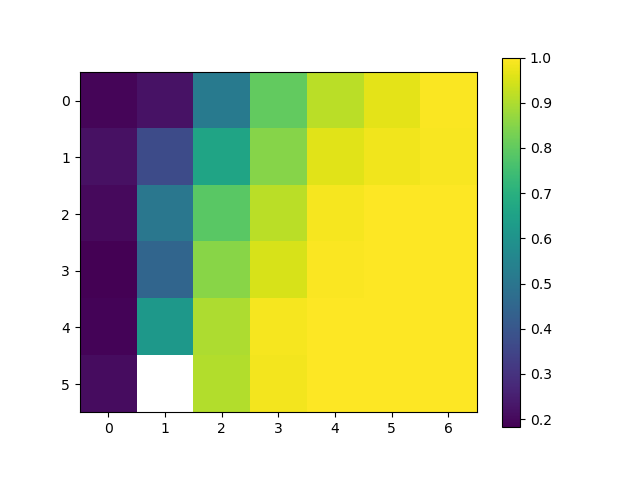

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


In [187]:
plt.figure()
plt.imshow(np.nanmean(hit_mean,0))
plt.colorbar()

In [218]:
usize = np.array((5,8,13,22,36,60))
ucontrast = np.array((0,3,6,12,25,50,100))/100
contrast_bdy = 100*np.concatenate(((0,),0.5*(ucontrast[:-1]+ucontrast[1:]),(1.01,)))
size_bdy = np.concatenate(((0,),0.5*(usize[:-1]+usize[1:]),(60,)))
def nansem(arr):
    return np.nanstd(arr)/np.sqrt(arr.size)
def boot_pct(arr,pct):
    return ut.bootstrap(arr,fn=np.nanmean,axis=0,pct=(pct,))[0]
lick_rate_interp = sst.binned_statistic_2d(size,contrast,lick_rate,bins=(size_bdy,contrast_bdy),statistic=np.nanmean).statistic
lick_rate_interp_lb = sst.binned_statistic_2d(size,contrast,lick_rate,bins=(size_bdy,contrast_bdy),statistic=lambda x: boot_pct(x,16)).statistic
lick_rate_interp_ub = sst.binned_statistic_2d(size,contrast,lick_rate,bins=(size_bdy,contrast_bdy),statistic=lambda x: boot_pct(x,84)).statistic

In [219]:
# scale = 13
# detector_miss = np.minimum(((1-lick_rate)/(1-fa))**(scale**2/size**2),1)
scale = np.nan
fa_rate = fa_id[animal_id.astype('int')]
lapse_rate = 0*lapse_id[animal_id.astype('int')]
detector_miss = (1-(lick_rate-fa_rate)/(1-lapse_rate-fa_rate))
# detector_miss = np.minimum((1-(lick_rate-fa_rate)/(1-lapse_rate-fa_rate)),1)
# detector_miss = np.minimum((1-lick_rate)/(1-fa_id[animal_id.astype('int')]),1)
# detector_miss = np.minimum((1-lick_rate)/(1-fa),1)
detector_miss_interp = sst.binned_statistic_2d(size,contrast,detector_miss,bins=(size_bdy,contrast_bdy),statistic=np.nanmean).statistic
detector_miss_interp_lb = sst.binned_statistic_2d(size,contrast,detector_miss,bins=(size_bdy,contrast_bdy),statistic=lambda x: boot_pct(x,16)).statistic
detector_miss_interp_ub = sst.binned_statistic_2d(size,contrast,detector_miss,bins=(size_bdy,contrast_bdy),statistic=lambda x: boot_pct(x,84)).statistic

<IPython.core.display.Javascript object>


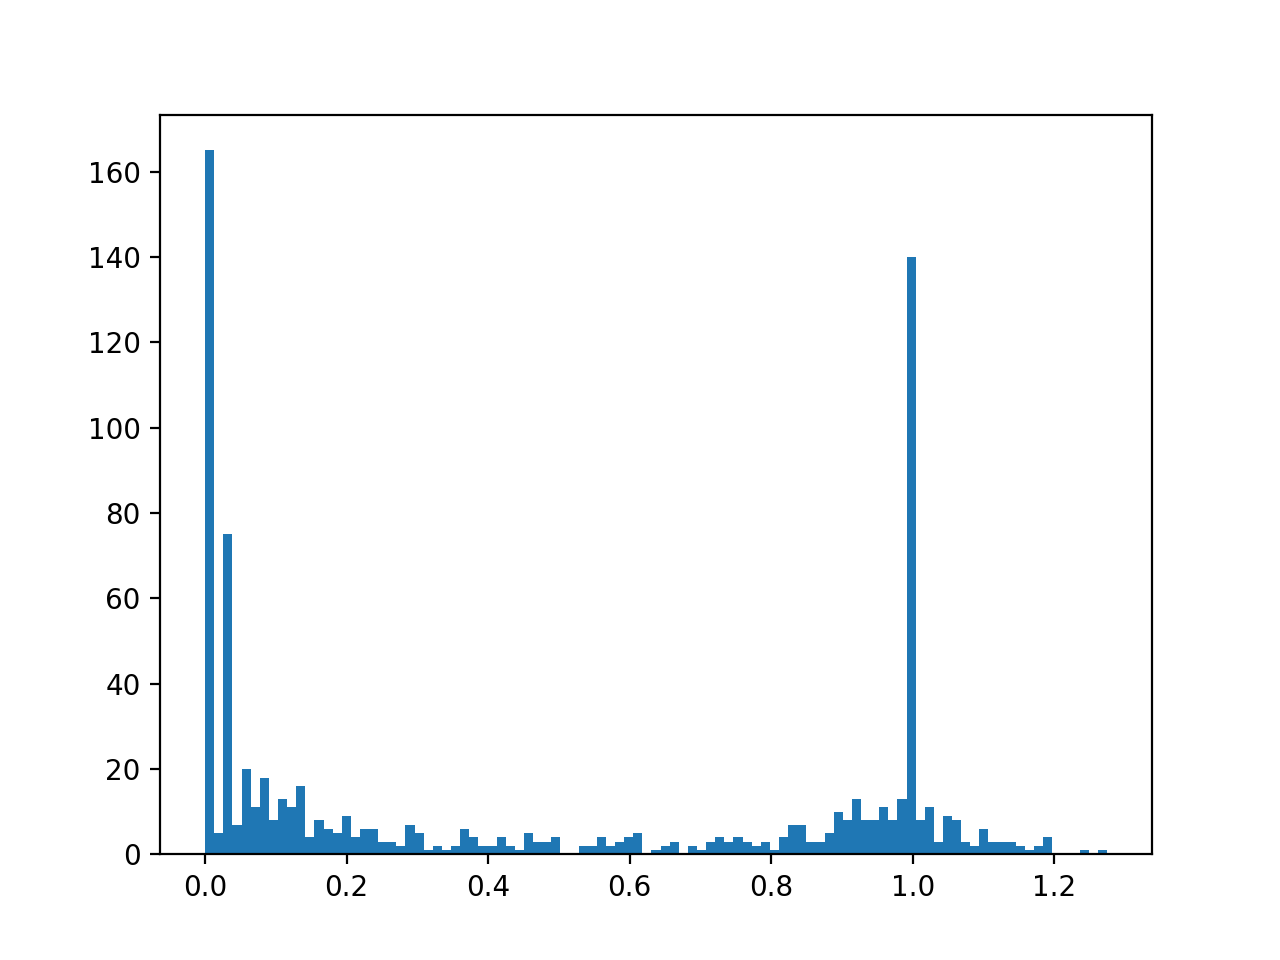

(array([165.,   5.,  75.,   7.,  20.,  11.,  18.,   8.,  13.,  11.,  16.,
          4.,   8.,   6.,   5.,   9.,   4.,   6.,   6.,   3.,   3.,   2.,
          7.,   5.,   1.,   2.,   1.,   2.,   6.,   4.,   2.,   2.,   4.,
          2.,   1.,   5.,   3.,   3.,   4.,   0.,   0.,   2.,   2.,   4.,
          2.,   3.,   4.,   5.,   0.,   1.,   2.,   3.,   0.,   2.,   1.,
          3.,   4.,   3.,   4.,   3.,   2.,   3.,   1.,   4.,   7.,   7.,
          3.,   3.,   5.,  10.,   8.,  13.,   8.,   8.,  11.,   8.,  13.,
        140.,   8.,  11.,   3.,   9.,   8.,   3.,   2.,   6.,   3.,   3.,
          3.,   2.,   1.,   2.,   4.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([0.        , 0.01287547, 0.02575093, 0.0386264 , 0.05150186,
        0.06437733, 0.07725279, 0.09012826, 0.10300372, 0.11587919,
        0.12875465, 0.14163012, 0.15450558, 0.16738105, 0.18025651,
        0.19313198, 0.20600744, 0.21888291, 0.23175837, 0.24463384,
        0.2575093 , 0.27038477, 0.28326023, 0.2961357 , 0.30

In [104]:
plt.figure()
plt.hist(detector_miss,bins=np.linspace(0,detector_miss.max(),100))

<IPython.core.display.Javascript object>


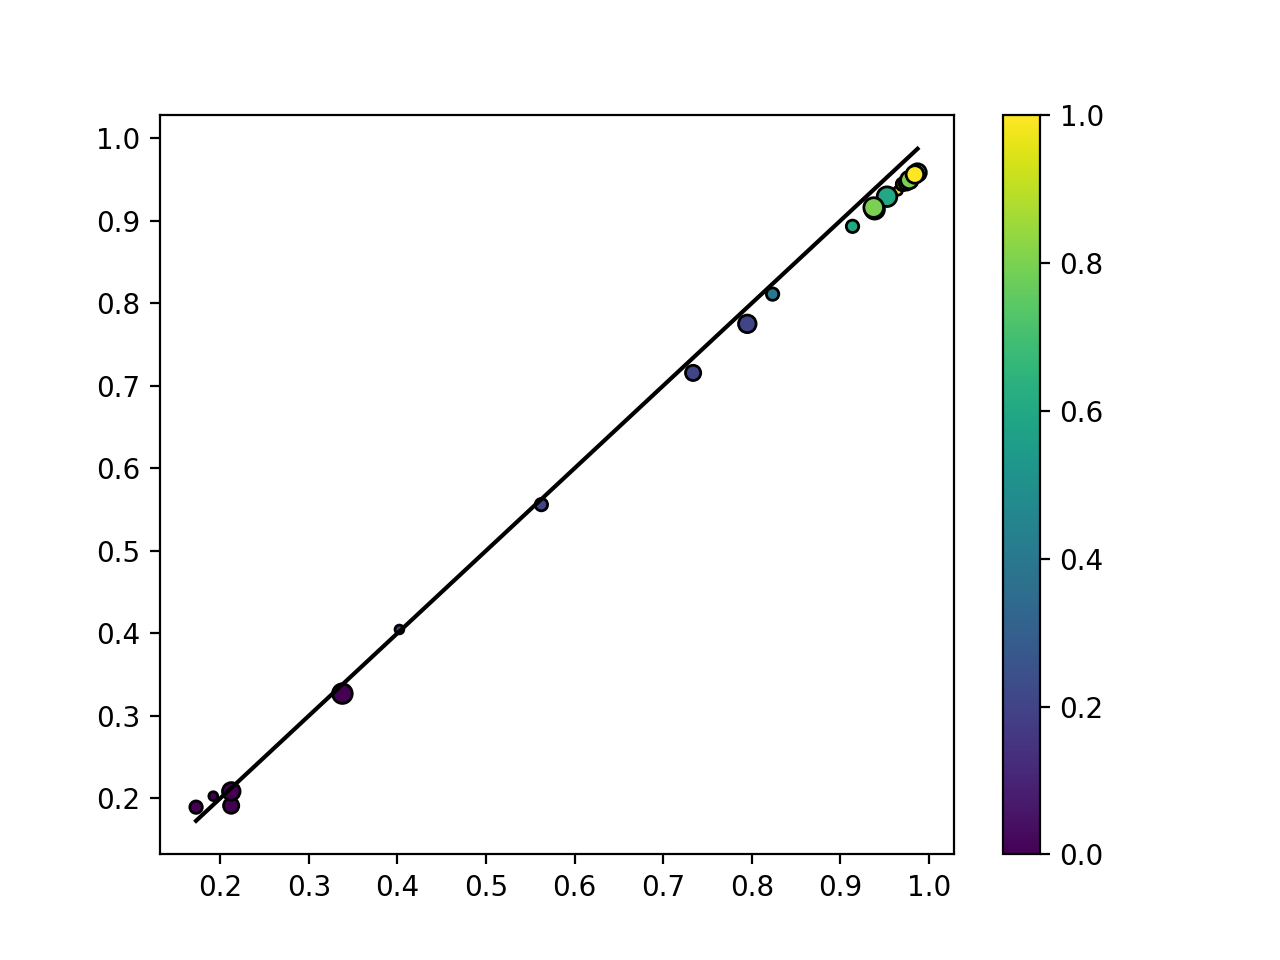

In [105]:
plt.figure()
# sca.scatter_size_contrast(lick_rate_interp,1-(1-fa)*detector_miss_interp**(usize[:,np.newaxis]**2/scale**2))
# sca.scatter_size_contrast(lick_rate_interp,1-(1-fa)*detector_miss_interp)
sca.scatter_size_contrast(lick_rate_interp,(1-detector_miss_interp)*(1-fa-lapse_id.mean())+fa)
plt.colorbar()

### below: still need to figure out what to do with the false alarm rate, which is a part of the decoder scores below, for comparison to the hypothetical animal detectors

In [106]:
jsize = 0
((usize0[jsize+1]**2-usize0[jsize]**2)/usize[:,np.newaxis]**2)

array([[1.        ],
       [0.37011661],
       [0.1369863 ],
       [0.0507009 ],
       [0.01876525],
       [0.00694444]])

In [833]:
detector_miss_interp.shape

(6, 7)

<IPython.core.display.Javascript object>


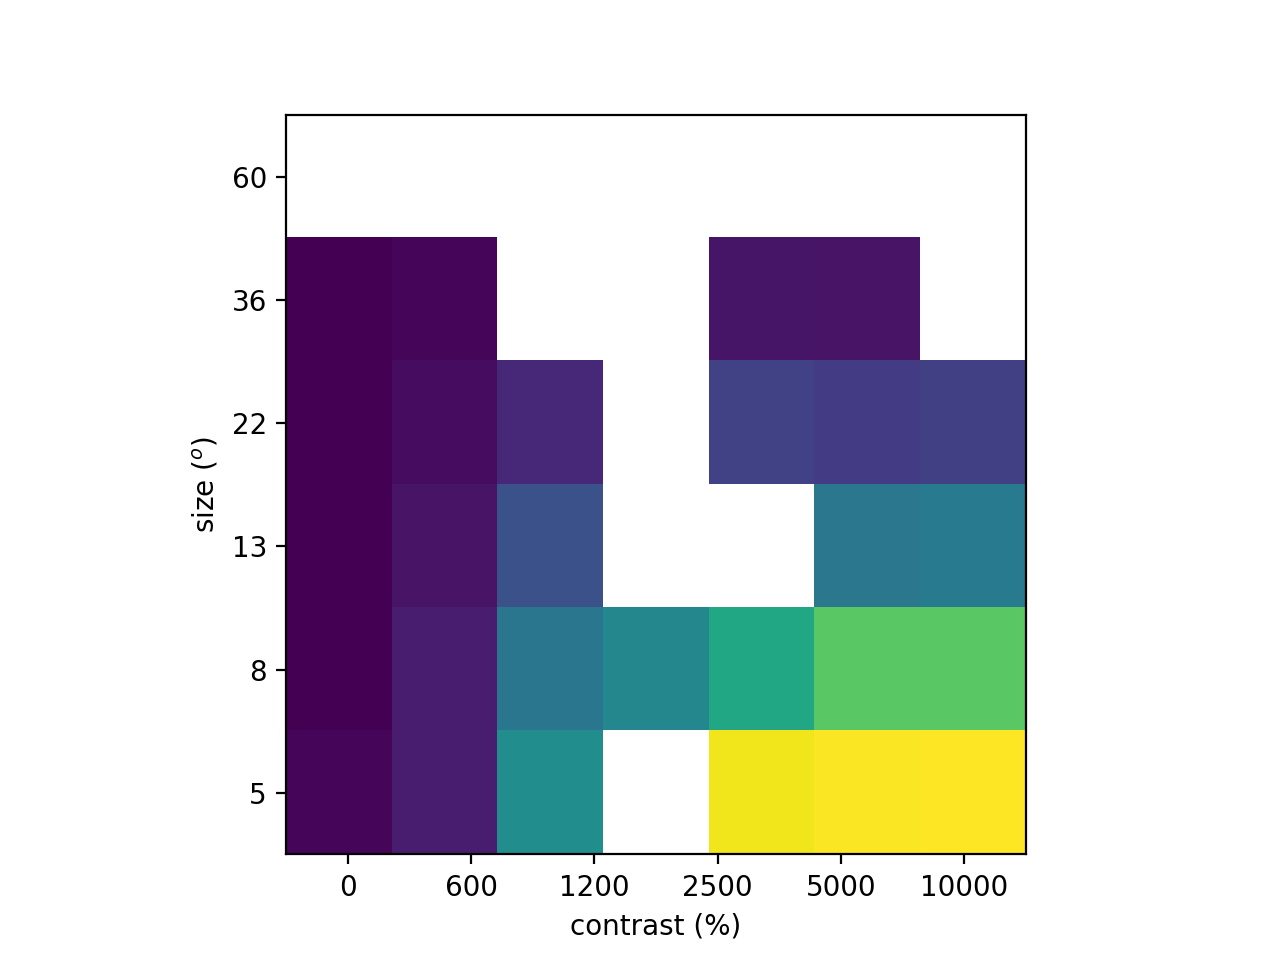

<IPython.core.display.Javascript object>


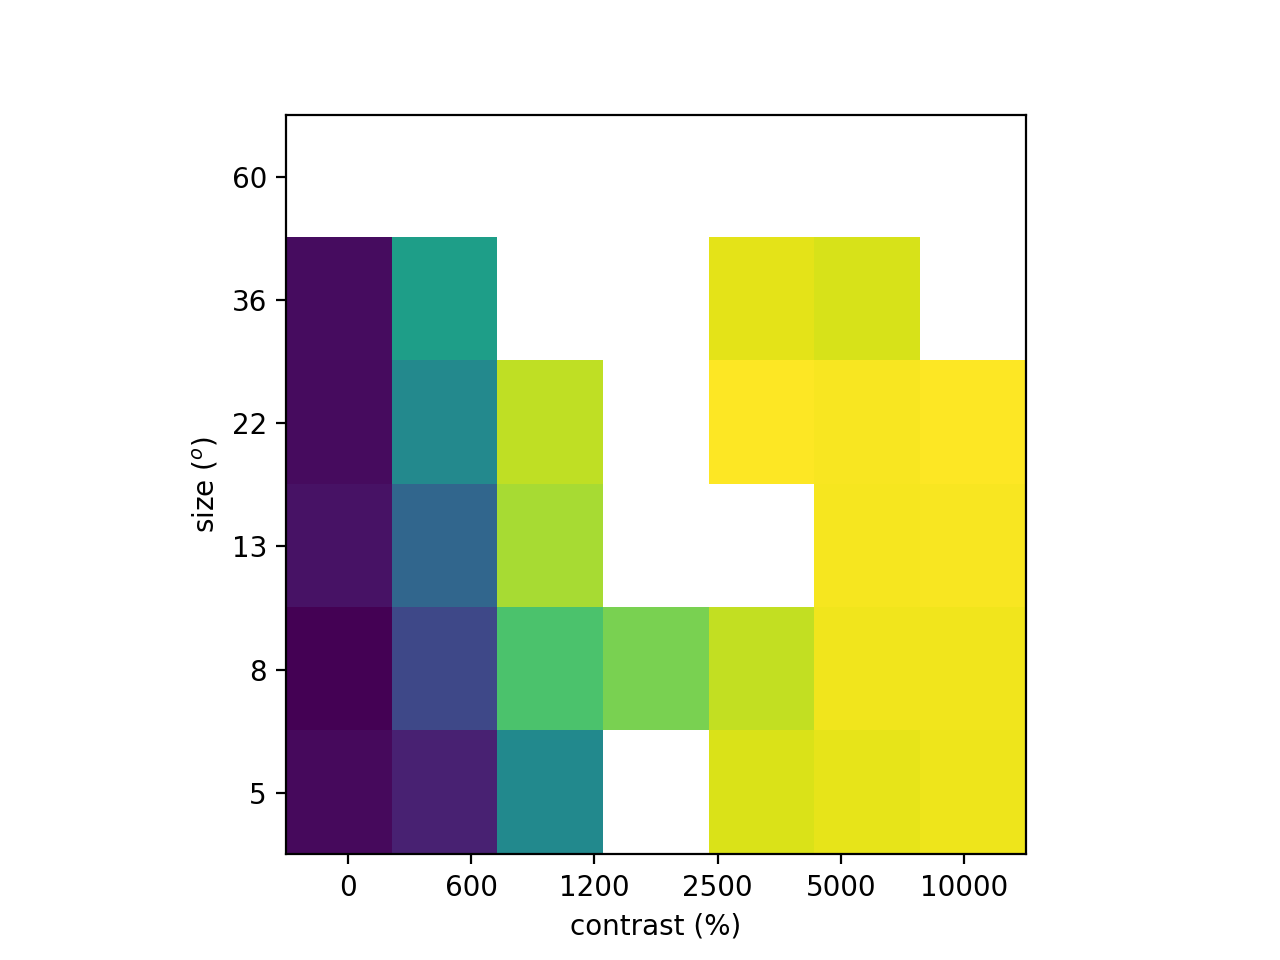

<IPython.core.display.Javascript object>


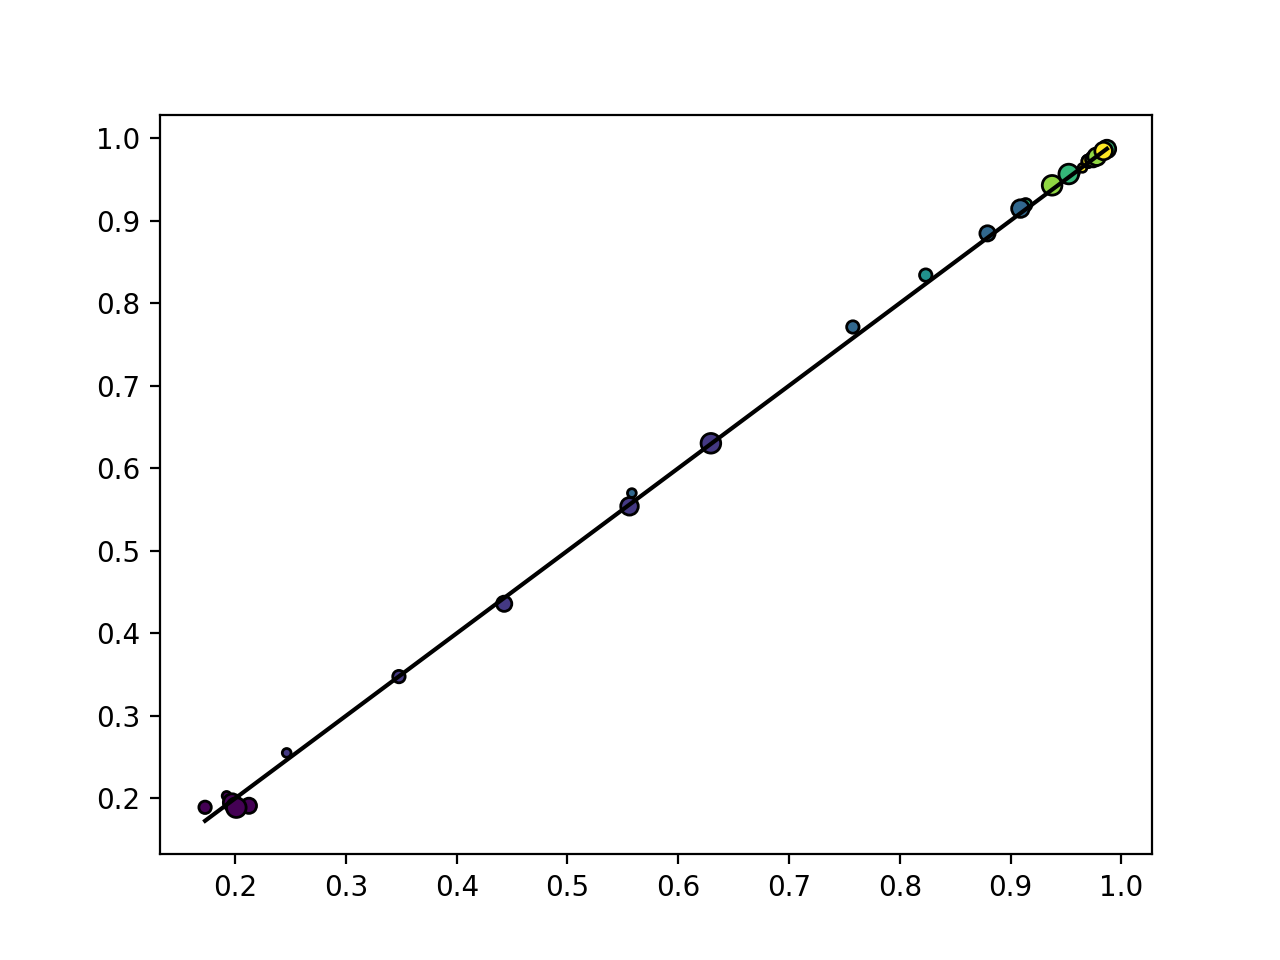

In [834]:
jsize = 0
mn, = [(1-arr**((usize0[jsize+1]**2-usize0[jsize]**2)/usize[:,np.newaxis]**2)) for arr in [detector_miss_interp]]
plt.figure()
sca.show_size_contrast(mn,usize=usize,ucontrast=ucontrast*100,flipud=True)
plt.figure()
sca.show_size_contrast(lick_rate_interp,usize=usize,ucontrast=ucontrast*100,flipud=True)
plt.figure()
sca.scatter_size_contrast(lick_rate_interp,1-detector_miss_interp*(1-fa))

<IPython.core.display.Javascript object>


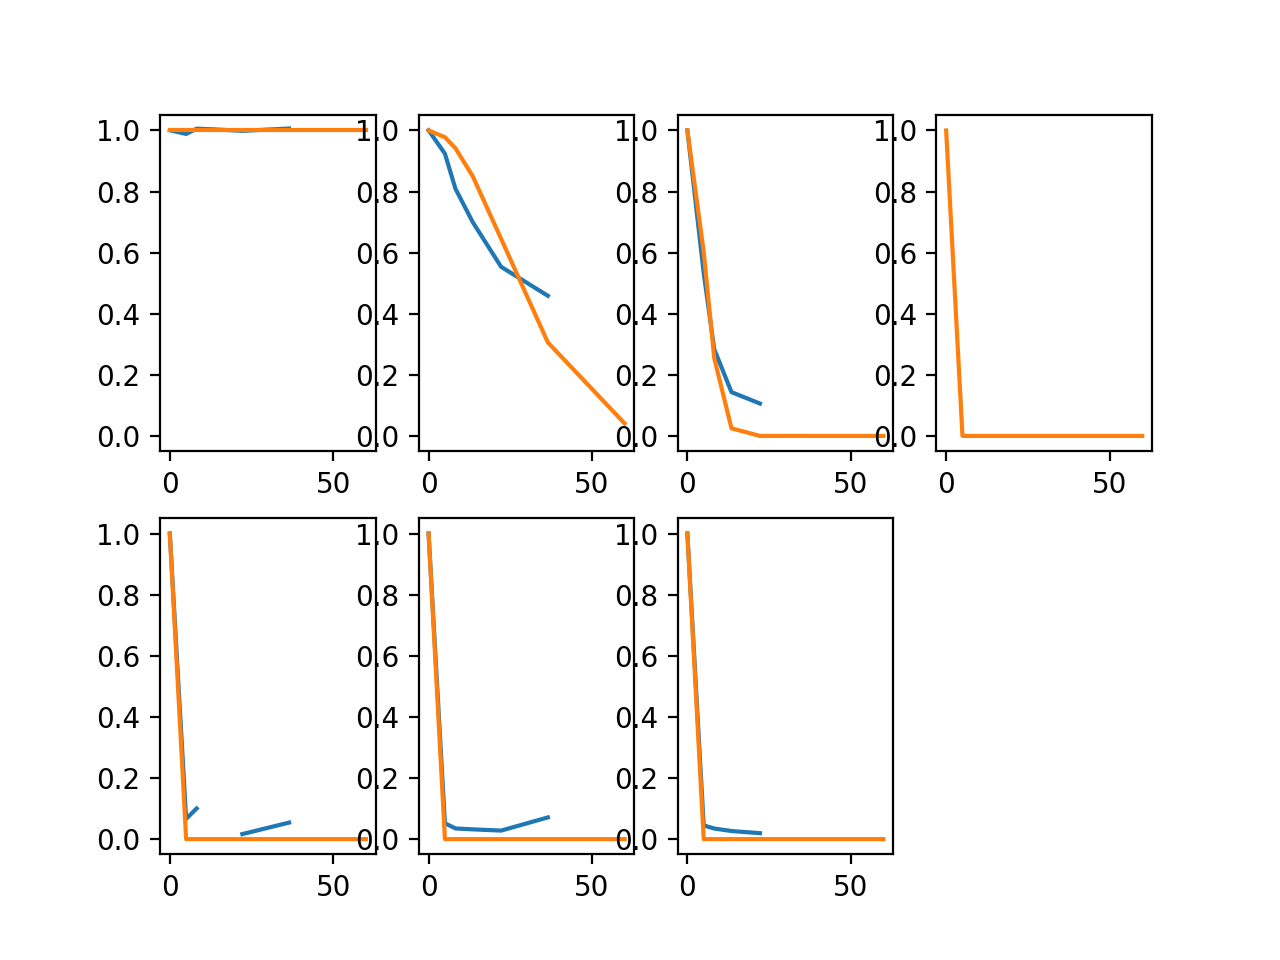

(1, 7, 7)


<IPython.core.display.Javascript object>


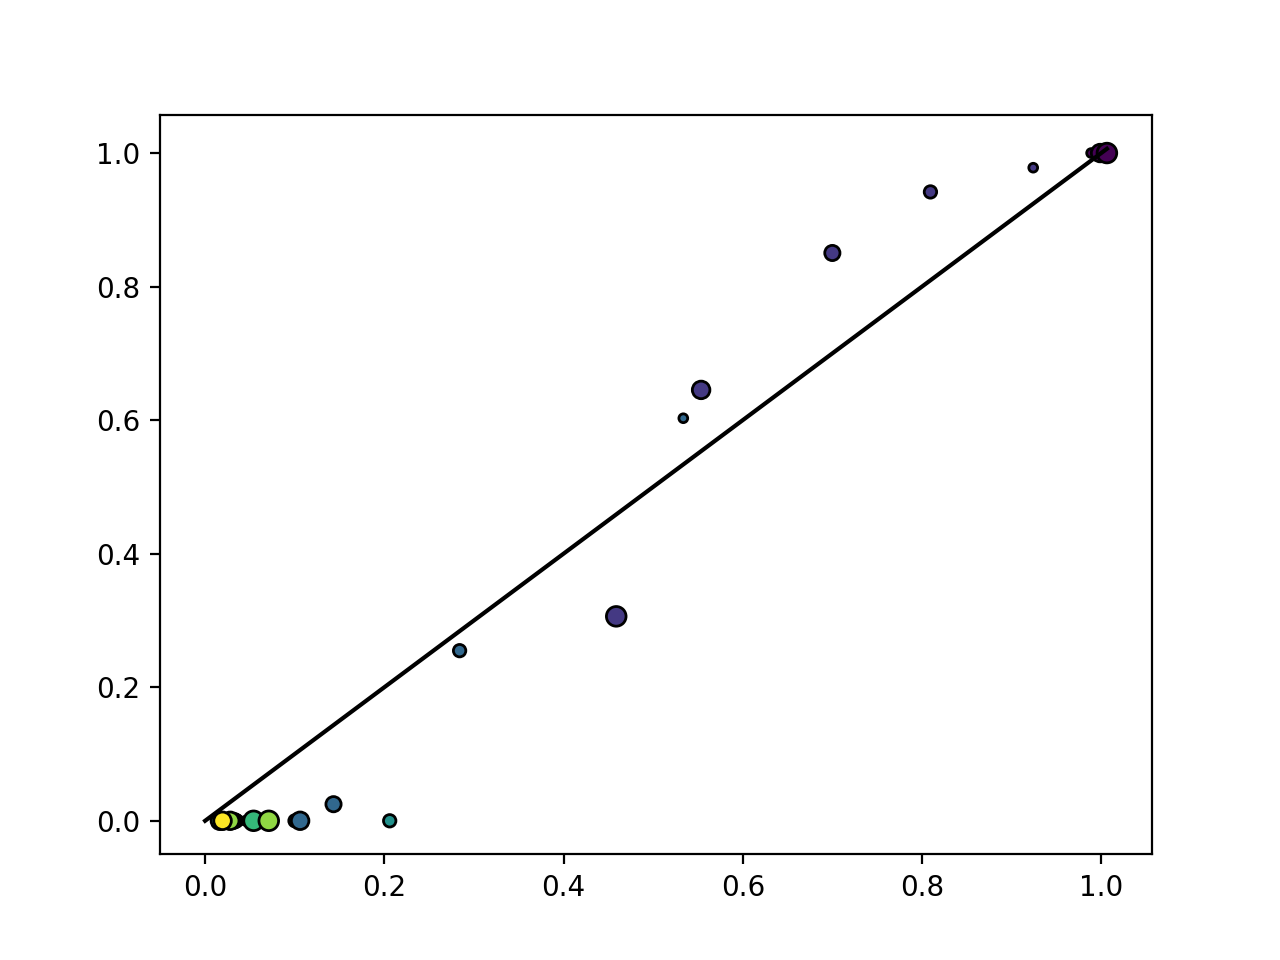

In [835]:
import scipy.optimize as sop
plt.figure()
isize = 3
size_tuning = sim_utils.gen_size_tuning(detector_miss_interp[np.newaxis])[0]
miss_rate_by_contrast = np.zeros((7,))
synthetic_miss_rate = np.zeros((7,7))
for icontrast in range(7):
    plt.subplot(2,4,icontrast+1)
    plt.plot(usize0,size_tuning[:,icontrast])
    def cost(a):
        return np.nansum((size_tuning[:,icontrast] - a[0]**(usize0**2))**2)
    a0 = (0.99,)
    bds = sop.Bounds((0,),(1,))
    result = sop.minimize(cost,a0,bounds=bds)
    miss_rate_by_contrast[icontrast] = result.x
    synthetic_miss_rate[:,icontrast] = miss_rate_by_contrast[icontrast]**(usize0**2)
    plt.plot(usize0,synthetic_miss_rate[:,icontrast])
    plt.ylim((-0.05,1.05))
plt.figure()
synthetic_miss_rate = synthetic_miss_rate[1:,:]
sca.scatter_size_contrast(detector_miss_interp,synthetic_miss_rate)
synthetic_detector_miss_rate = np.ones((6,6,7))
for jsize in range(nsize):
    for isize in range(jsize,nsize):
        synthetic_detector_miss_rate[jsize,isize,:] \
            = miss_rate_by_contrast[np.newaxis,:]**((usize0[jsize+1]**2-usize0[jsize]**2))

<IPython.core.display.Javascript object>


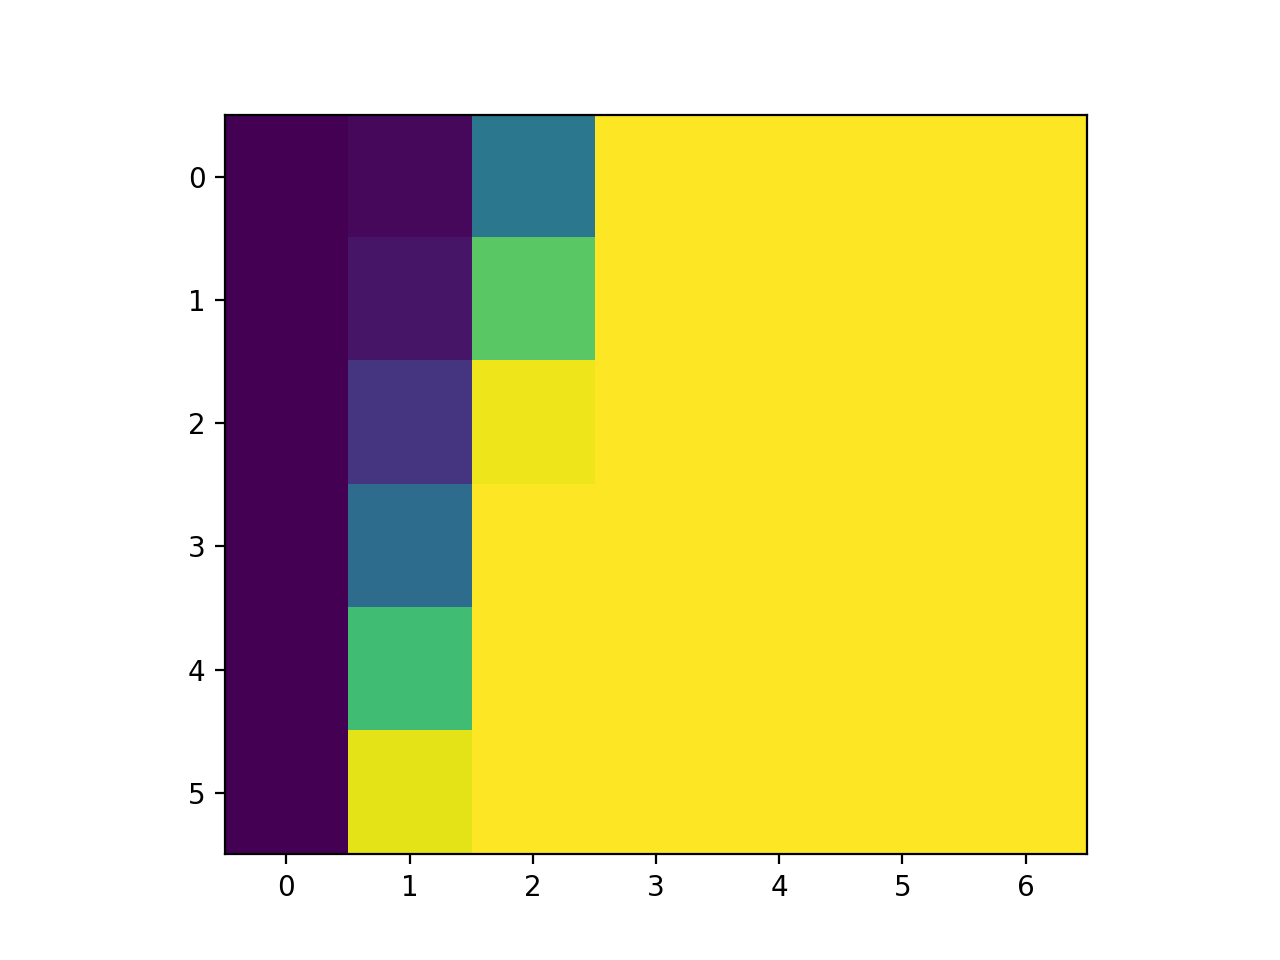

In [836]:
plt.figure()
plt.imshow(1-np.prod(synthetic_detector_miss_rate,axis=0))

<IPython.core.display.Javascript object>


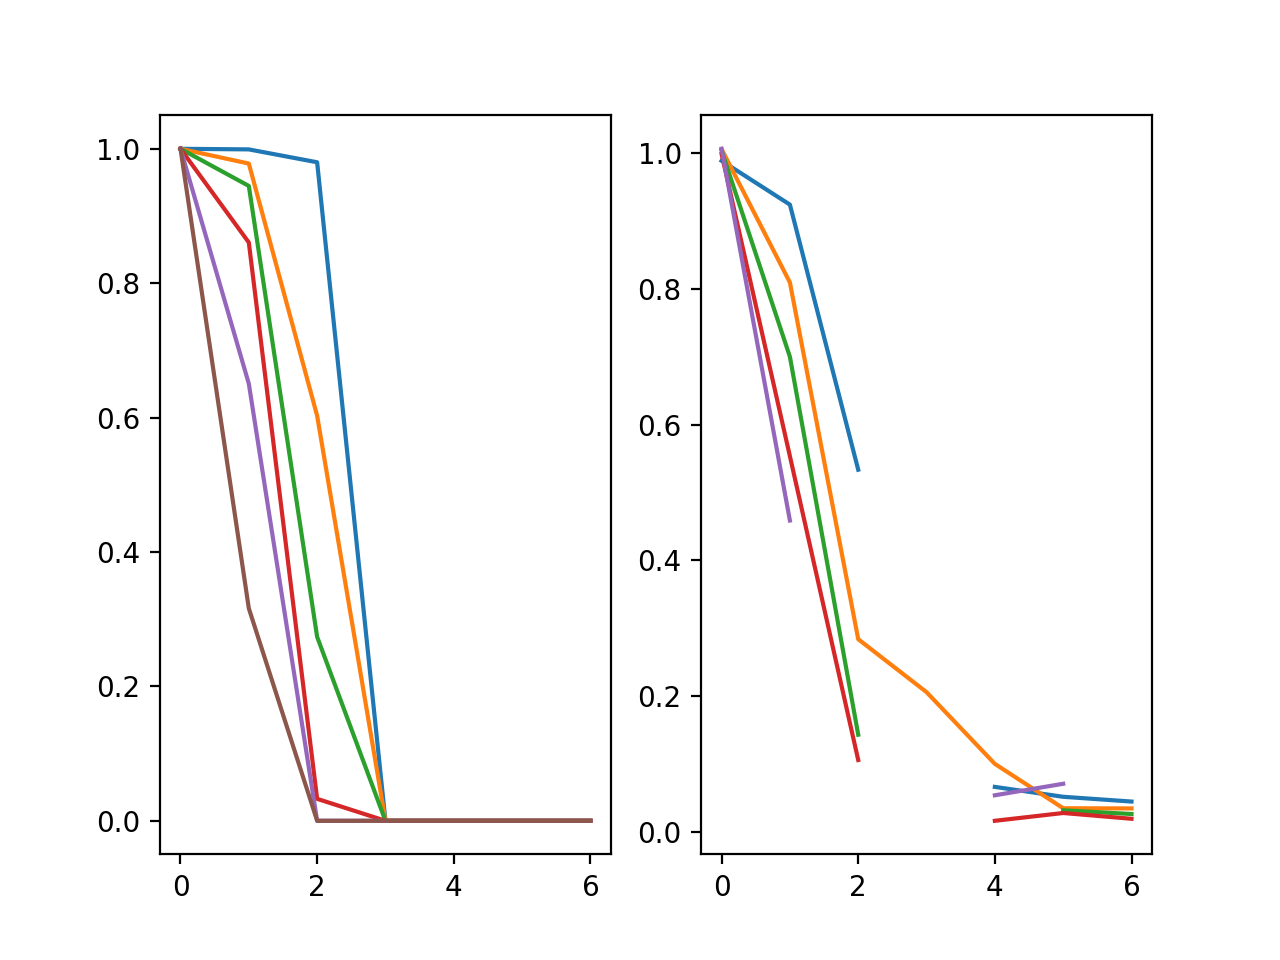

In [837]:
plt.figure()
plt.subplot(1,2,1)
x = np.arange(7) #np.array((0,3,6,12,25,50,100))
plt.plot(x,miss_rate_by_contrast)
plt.plot(x,miss_rate_by_contrast**(5**2))
plt.plot(x,miss_rate_by_contrast**(8**2))
plt.plot(x,miss_rate_by_contrast**(13**2))
plt.plot(x,miss_rate_by_contrast**(22**2))
plt.plot(x,miss_rate_by_contrast**(36**2))
plt.subplot(1,2,2)
plt.plot(detector_miss_interp.T)

In [838]:
result

      fun: 0.004303065071411028
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([0.])

In [839]:
detector_miss_interp**((usize0[jsize+1]**2-usize0[jsize]**2)/usize[:,np.newaxis]**2)

array([[3.56397983e-001, 7.77745132e-004, 1.81335174e-025,
                    nan, 1.54313027e-107, 2.72178309e-117,
        5.16186480e-123],
       [1.21723147e+000, 8.26356913e-004, 4.43440934e-019,
        9.22736366e-024, 2.99125462e-034, 1.34275200e-049,
        1.02410170e-049],
       [1.04542093e+000, 1.18836330e-002, 3.28108542e-011,
                    nan,             nan, 2.62108023e-019,
        2.57190531e-020],
       [9.94403449e-001, 6.58610006e-002, 3.29725641e-005,
                    nan, 6.36260801e-009, 7.21893879e-008,
        1.36585199e-008],
       [1.01082502e+000, 2.65466289e-001,             nan,
                    nan, 6.97818957e-003, 1.10971255e-002,
                    nan],
       [            nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan]])

<IPython.core.display.Javascript object>


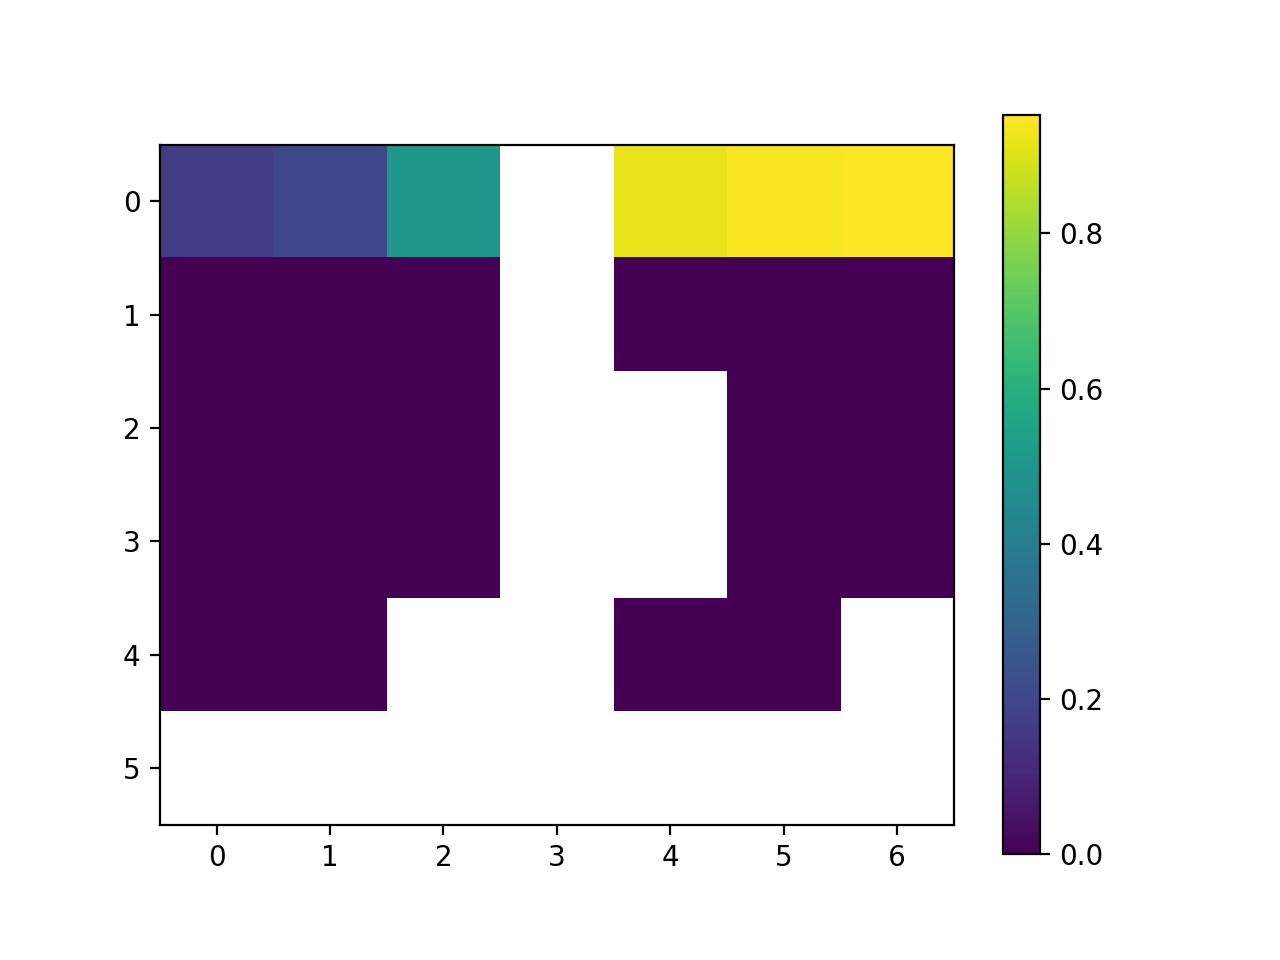

In [871]:
def infer_hit(arr,lick_rate_interp):
    inferred_hit = np.concatenate((arr[0:1],\
                               (arr[1:] - lick_rate_interp[:-1])/(1 - lick_rate_interp[:-1])),axis=0)
    inferred_hit = np.maximum(np.minimum(inferred_hit,1),0)
    return inferred_hit
inferred_hit = infer_hit(lb,lick_rate_interp)
plt.figure()
plt.imshow(inferred_hit)#,vmin=0,vmax=1)
plt.colorbar()

### new angle: the axes that are supposed to correspond to independent detectors end up highly dependent, and thus "independent detectors" still look like whole animal behavior

<IPython.core.display.Javascript object>


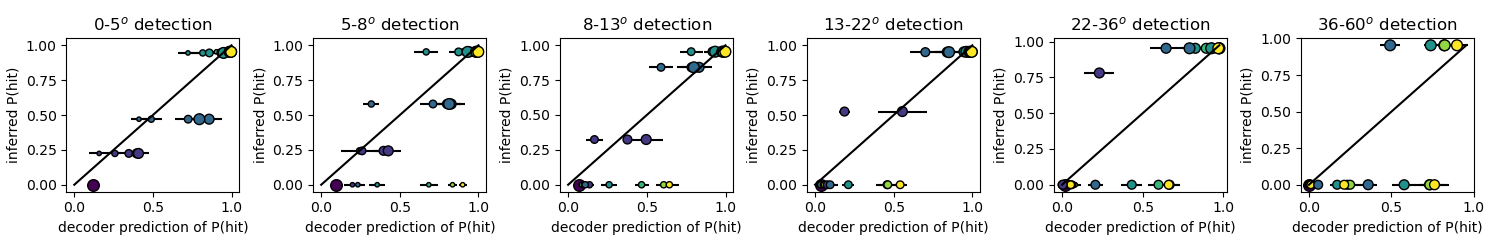

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/

In [222]:
# jsize = 0
# plt.figure()
# for jsize in range(5):
#     plt.subplot(2,3,jsize+1)
# #     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize]**(scale**2/(usize0[jsize+1]**2-usize0[jsize]**2)))
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])
# #     scaled_animal_hit = (1-detector_miss_interp)[np.newaxis]
#     scaled_animal_hit = (1-detector_miss_interp**((usize0[jsize+1]**2-usize0[jsize]**2)/scale**2))[np.newaxis]
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = np.nan
#     sca.scatter_size_contrast_errorbar(scaled_decoder_hit,scaled_animal_hit,equate_0=True)
#     plt.xlabel('decoder prediction')
#     plt.ylabel('inferred detection rate')
# plt.tight_layout()

# jsize = 0
# plt.figure()
# for jsize in range(5):
#     plt.subplot(2,3,jsize+1)
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])**(scale**2/(usize0[jsize+1]**2-usize0[jsize]**2))
# #     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])
#     scaled_animal_hit = (1-detector_miss_interp)[np.newaxis]
# #     scaled_animal_hit = (1-detector_miss_interp**((usize0[jsize+1]**2-usize0[jsize]**2)/scale**2))[np.newaxis]
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = np.nan
#     sca.scatter_size_contrast_errorbar(scaled_decoder_hit,scaled_animal_hit,equate_0=True)
#     plt.xlabel('decoder prediction')
#     plt.ylabel('inferred detection rate')
# plt.tight_layout()
Phit = np.load('../behavior/fit_detector_p_hit.npy')

delta = 0.05
jsize = 0
inferred_detector_corr = np.zeros((nexpt,6))
# plt.figure()
# for jsize in range(6):
#     plt.subplot(2,3,jsize+1)
plt.figure(figsize=(15,2.5))
for jsize in range(6):
    plt.subplot(1,6,jsize+1)
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize]**(scale**2/(usize0[jsize+1]**2-usize0[jsize]**2)))
#     scaled_decoder_hit = hit_mean_ind[:,jsize]
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])/(1-hit_mean_ind[:,jsize,:,0:1])
    scaled_decoder_hit = hit_mean_ind[:,jsize]
#     scaled_animal_hit = (1-detector_miss_interp)[np.newaxis]
#     lb,ub = [(1-arr**((usize0[jsize+1]**2-usize0[jsize]**2)/usize[:,np.newaxis]**2)) for arr in [detector_miss_interp_lb,detector_miss_interp_ub]]
#     lb,ub = [1-arr for arr in [detector_miss_interp_lb,detector_miss_interp_ub]]
#     lb,ub = [lick_rate_interp_lb,lick_rate_interp_ub]
#     lb,ub = [infer_hit(x,lick_rate_interp) for x in [lb,ub]]
#     lb,ub = [np.stack([x[jsize] for _ in range(nsize)]) for x in [lb,ub]]
#     scaled_animal_hit = np.concatenate((lb[np.newaxis],ub[np.newaxis]))
    scaled_animal_hit = Phit[jsize:jsize+1]
#     scaled_animal_hit = (1-detector_miss_interp**((usize0[jsize+1]**2-usize0[jsize]**2)/usize[jsize]**2))[np.newaxis]
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = np.nan
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = 0
    for iexpt in range(nexpt):
        ok = ~np.isnan(scaled_decoder_hit[iexpt].flatten()) & ~np.isnan(scaled_animal_hit[0].flatten())
        inferred_detector_corr[iexpt,jsize] = np.corrcoef(scaled_decoder_hit[iexpt].flatten()[ok],\
                                                    scaled_animal_hit[0].flatten()[ok])[0,1]
    
#     sca.scatter_size_contrast_errorbar(scaled_decoder_hit,1-synthetic_detector_miss_rate[jsize:jsize+1],equate_0=True)
    try:
        sca.scatter_size_contrast_errorbar(scaled_decoder_hit,scaled_animal_hit,equate_0=True)
    except:
        pass
    plt.xlabel('decoder prediction of P(hit)')
#     plt.ylabel('P(lick)')
    plt.ylabel('inferred P(hit)')
    plt.title('%d-%d$^o$ detection'%(usize0[jsize],usize0[jsize+1]))
#     plt.xlim((-delta,1+delta))
#     plt.ylim((-delta,1+delta))
plt.tight_layout()
if save_fig:
    plt.savefig('figures/inferred_hit_rate_and_ind_detector.eps')


<IPython.core.display.Javascript object>


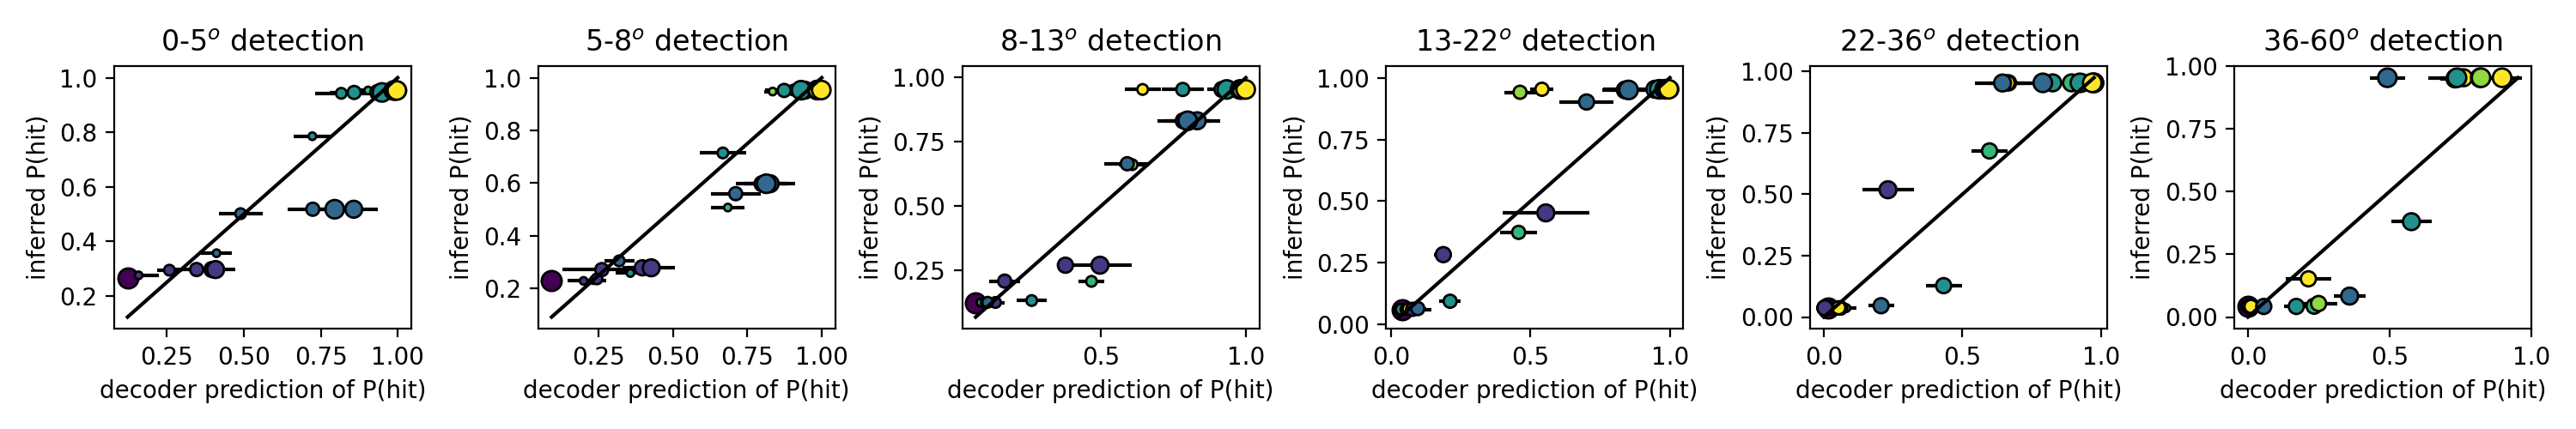

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/

In [245]:
# jsize = 0
# plt.figure()
# for jsize in range(5):
#     plt.subplot(2,3,jsize+1)
# #     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize]**(scale**2/(usize0[jsize+1]**2-usize0[jsize]**2)))
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])
# #     scaled_animal_hit = (1-detector_miss_interp)[np.newaxis]
#     scaled_animal_hit = (1-detector_miss_interp**((usize0[jsize+1]**2-usize0[jsize]**2)/scale**2))[np.newaxis]
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = np.nan
#     sca.scatter_size_contrast_errorbar(scaled_decoder_hit,scaled_animal_hit,equate_0=True)
#     plt.xlabel('decoder prediction')
#     plt.ylabel('inferred detection rate')
# plt.tight_layout()

# jsize = 0
# plt.figure()
# for jsize in range(5):
#     plt.subplot(2,3,jsize+1)
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])**(scale**2/(usize0[jsize+1]**2-usize0[jsize]**2))
# #     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])
#     scaled_animal_hit = (1-detector_miss_interp)[np.newaxis]
# #     scaled_animal_hit = (1-detector_miss_interp**((usize0[jsize+1]**2-usize0[jsize]**2)/scale**2))[np.newaxis]
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = np.nan
#     sca.scatter_size_contrast_errorbar(scaled_decoder_hit,scaled_animal_hit,equate_0=True)
#     plt.xlabel('decoder prediction')
#     plt.ylabel('inferred detection rate')
# plt.tight_layout()
Phit = np.load('../behavior/fit_detector_p_hit.npy')

delta = 0.05
jsize = 0
inferred_detector_smeared_corr = np.zeros((nexpt,6))
# plt.figure()
# for jsize in range(6):
#     plt.subplot(2,3,jsize+1)
plt.figure(figsize=(15,2.5))
for jsize in range(6):
    plt.subplot(1,6,jsize+1)
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize]**(scale**2/(usize0[jsize+1]**2-usize0[jsize]**2)))
#     scaled_decoder_hit = hit_mean_ind[:,jsize]
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])/(1-hit_mean_ind[:,jsize,:,0:1])
    scaled_decoder_hit = hit_mean_ind[:,jsize]
#     scaled_animal_hit = (1-detector_miss_interp)[np.newaxis]
#     lb,ub = [(1-arr**((usize0[jsize+1]**2-usize0[jsize]**2)/usize[:,np.newaxis]**2)) for arr in [detector_miss_interp_lb,detector_miss_interp_ub]]
#     lb,ub = [1-arr for arr in [detector_miss_interp_lb,detector_miss_interp_ub]]
#     lb,ub = [lick_rate_interp_lb,lick_rate_interp_ub]
#     lb,ub = [infer_hit(x,lick_rate_interp) for x in [lb,ub]]
#     lb,ub = [np.stack([x[jsize] for _ in range(nsize)]) for x in [lb,ub]]
#     scaled_animal_hit = np.concatenate((lb[np.newaxis],ub[np.newaxis]))
    scaled_animal_hit = all_ys[jsize:jsize+1]#Phit[jsize:jsize+1]
#     scaled_animal_hit = (1-detector_miss_interp**((usize0[jsize+1]**2-usize0[jsize]**2)/usize[jsize]**2))[np.newaxis]
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = np.nan
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = 0
    for iexpt in range(nexpt):
        ok = ~np.isnan(scaled_decoder_hit[iexpt].flatten()) & ~np.isnan(scaled_animal_hit[0].flatten())
        inferred_detector_smeared_corr[iexpt,jsize] = np.corrcoef(scaled_decoder_hit[iexpt].flatten()[ok],\
                                                    scaled_animal_hit[0].flatten()[ok])[0,1]
    
#     sca.scatter_size_contrast_errorbar(scaled_decoder_hit,1-synthetic_detector_miss_rate[jsize:jsize+1],equate_0=True)
    try:
        sca.scatter_size_contrast_errorbar(scaled_decoder_hit,scaled_animal_hit,equate_0=True)
    except:
        pass
    plt.xlabel('decoder prediction of P(hit)')
#     plt.ylabel('P(lick)')
    plt.ylabel('inferred P(hit)')
    plt.title('%d-%d$^o$ detection'%(usize0[jsize],usize0[jsize+1]))
#     plt.xlim((-delta,1+delta))
#     plt.ylim((-delta,1+delta))
plt.tight_layout()
if True:
    plt.savefig('figures/inferred_hit_rate_and_smeared_ind_detector.eps')


<IPython.core.display.Javascript object>


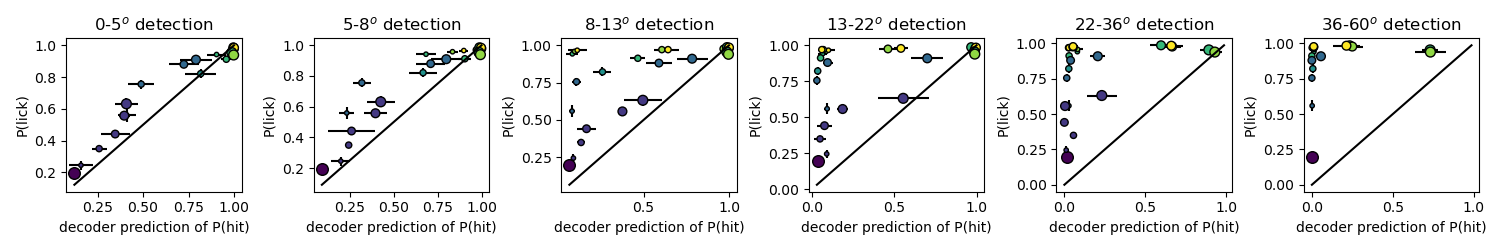

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/

In [220]:
# jsize = 0
# plt.figure()
# for jsize in range(5):
#     plt.subplot(2,3,jsize+1)
# #     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize]**(scale**2/(usize0[jsize+1]**2-usize0[jsize]**2)))
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])
# #     scaled_animal_hit = (1-detector_miss_interp)[np.newaxis]
#     scaled_animal_hit = (1-detector_miss_interp**((usize0[jsize+1]**2-usize0[jsize]**2)/scale**2))[np.newaxis]
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = np.nan
#     sca.scatter_size_contrast_errorbar(scaled_decoder_hit,scaled_animal_hit,equate_0=True)
#     plt.xlabel('decoder prediction')
#     plt.ylabel('inferred detection rate')
# plt.tight_layout()

# jsize = 0
# plt.figure()
# for jsize in range(5):
#     plt.subplot(2,3,jsize+1)
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])**(scale**2/(usize0[jsize+1]**2-usize0[jsize]**2))
# #     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])
#     scaled_animal_hit = (1-detector_miss_interp)[np.newaxis]
# #     scaled_animal_hit = (1-detector_miss_interp**((usize0[jsize+1]**2-usize0[jsize]**2)/scale**2))[np.newaxis]
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = np.nan
#     sca.scatter_size_contrast_errorbar(scaled_decoder_hit,scaled_animal_hit,equate_0=True)
#     plt.xlabel('decoder prediction')
#     plt.ylabel('inferred detection rate')
# plt.tight_layout()
lick_corr = np.zeros((nexpt,6))

Phit = np.load('../behavior/fit_detector_p_hit.npy')

delta = 0.05
jsize = 0
# plt.figure()
# for jsize in range(6):
#     plt.subplot(2,3,jsize+1)
plt.figure(figsize=(15,2.5))
for jsize in range(6):
    plt.subplot(1,6,jsize+1)
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize]**(scale**2/(usize0[jsize+1]**2-usize0[jsize]**2)))
#     scaled_decoder_hit = hit_mean_ind[:,jsize]
#     scaled_decoder_hit = 1-(1-hit_mean_ind[:,jsize])/(1-hit_mean_ind[:,jsize,:,0:1])
    scaled_decoder_hit = hit_mean_ind[:,jsize]
#     scaled_animal_hit = (1-detector_miss_interp)[np.newaxis]
#     lb,ub = [(1-arr**((usize0[jsize+1]**2-usize0[jsize]**2)/usize[:,np.newaxis]**2)) for arr in [detector_miss_interp_lb,detector_miss_interp_ub]]
#     lb,ub = [1-arr for arr in [detector_miss_interp_lb,detector_miss_interp_ub]]
    lb,ub = [lick_rate_interp_lb,lick_rate_interp_ub]
#     lb,ub = [infer_hit(x,lick_rate_interp) for x in [lb,ub]]
#     lb,ub = [np.stack([x[jsize] for _ in range(nsize)]) for x in [lb,ub]]
    scaled_animal_hit = np.concatenate((lb[np.newaxis],ub[np.newaxis]))
#     scaled_animal_hit = Phit[jsize:jsize+1]
#     scaled_animal_hit = (1-detector_miss_interp**((usize0[jsize+1]**2-usize0[jsize]**2)/usize[jsize]**2))[np.newaxis]
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = np.nan
#     scaled_animal_hit[:,jsize > np.arange(nsize),:] = 0

    for iexpt in range(nexpt):
        ok = ~np.isnan(scaled_decoder_hit[iexpt].flatten()) & ~np.isnan(lick_rate_interp.flatten())
        lick_corr[iexpt,jsize] = np.corrcoef(scaled_decoder_hit[iexpt].flatten()[ok],\
                                                    lick_rate_interp.flatten()[ok])[0,1]
    
#     sca.scatter_size_contrast_errorbar(scaled_decoder_hit,1-synthetic_detector_miss_rate[jsize:jsize+1],equate_0=True)
    try:
        sca.scatter_size_contrast_errorbar(scaled_decoder_hit,scaled_animal_hit,equate_0=True)
    except:
        pass
    plt.xlabel('decoder prediction of P(hit)')
    plt.ylabel('P(lick)')
#     plt.ylabel('inferred P(hit)')
    plt.title('%d-%d$^o$ detection'%(usize0[jsize],usize0[jsize+1]))
#     plt.xlim((-delta,1+delta))
#     plt.ylim((-delta,1+delta))
plt.tight_layout()
if save_fig:
    plt.savefig('figures/lick_rate_and_ind_detector.eps')


In [89]:
scaled_decoder_hit[iexpt].shape

NameError: name 'scaled_decoder_hit' is not defined

In [108]:
reload(nra)
c50s_decoder = np.nan*np.ones(hit_mean.shape[:2])
c50std_decoder = np.nan*np.ones(hit_mean.shape[:2])
for iexpt in range(hit_mean.shape[0]):
    slkat = np.sum(~np.isnan(hit_mean[iexpt]),1)>0
    clkat = np.sum(~np.isnan(hit_mean[iexpt]),0)>0
    if slkat.sum() and clkat.sum():
        x,cov = nra.fit_opt_params_weibull(100*ucontrast[clkat],hit_mean[iexpt][slkat,:][:,clkat])
        c50s_decoder[iexpt][slkat] = x[2*slkat.sum():3*slkat.sum()]
        c50std_decoder[iexpt][slkat] = np.sqrt(np.diag(cov[2*slkat.sum():3*slkat.sum(),2*slkat.sum():3*slkat.sum()]))
    

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6 but corresponding boolean dimension is 7

In [100]:
plt.figure()
plt.imshow(c50std_decoder,vmin=0,vmax=10)
plt.colorbar()

<IPython.core.display.Javascript object>

In [101]:
size_by_animal = [None for _ in range(int(animal_id.max()+1))]
c50s_animal = [None for _ in range(int(animal_id.max()+1))]
c50std_animal = [None for _ in range(int(animal_id.max()+1))]
for this_id in np.unique(animal_id).astype('int'):
    these_sizes = np.unique(size[animal_id==this_id])
    size_by_animal[this_id] = these_sizes
    c50s_animal[this_id] = np.nan*np.ones((len(these_sizes),))
    c50std_animal[this_id] = np.nan*np.ones((len(these_sizes),))
    for isize,this_size in enumerate(these_sizes):
        lkat = (animal_id==this_id) & (size==this_size)
        these_contrasts = contrast[lkat]
        these_licks = lick_rate[lkat]
        x,cov = nra.fit_opt_params_weibull(these_contrasts,lick_rate[np.newaxis,lkat])
        c50s_animal[this_id][isize] = x[2]
        c50std_animal[this_id][isize] = np.sqrt(cov[2,2])
c50s_animal = np.concatenate(c50s_animal)
c50std_animal = np.concatenate(c50std_animal)
size_by_animal = np.concatenate(size_by_animal)

In [104]:
usize.shape

(5,)

<IPython.core.display.Javascript object>


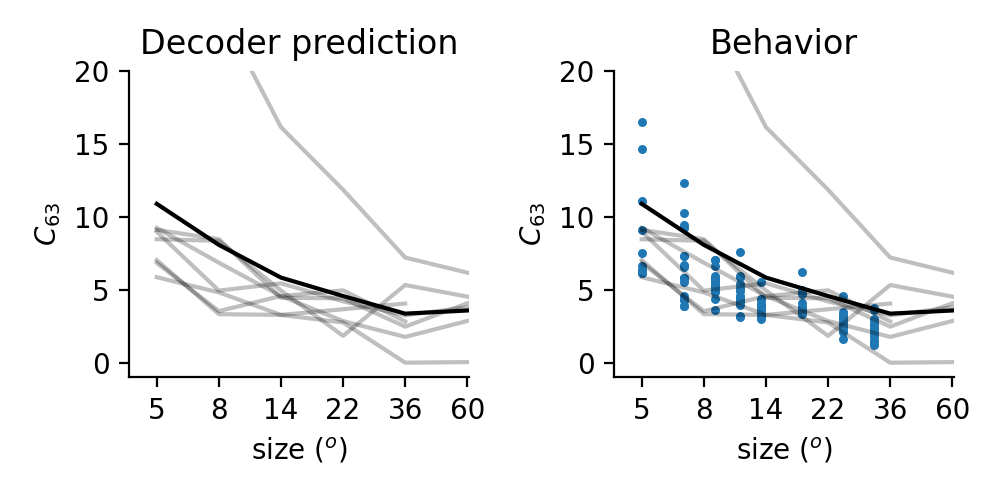

In [473]:
plt.figure(figsize=(5,2.5))
plt.subplot(1,2,1)
plt.plot(np.log10(usize),c50s_decoder.T,c='k',alpha=0.25)
# for iexpt in range(c50s.shape[0]):
#     plt.errorbar(np.log10(usize),c50s[iexpt],yerr=c50std[iexpt],c='k',alpha=0.25)
plt.plot(np.log10(usize),np.nanmean(c50s_decoder,0),c='k')
# plt.yticks((-1,0,1),(0.1,1,10))
# plt.scatter(np.log10(usize).flatten(),np.log10(c50s.T).flatten(),c='k',alpha=0.25)
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
plt.ylim((-1,20))
plt.xlim((np.log10(4),np.log10(61)))
ut.erase_top_right()
plt.xlabel('size ($^o$)')
plt.ylabel('$C_{63}$')
plt.title('Decoder prediction')
plt.subplot(1,2,2)
plt.scatter(np.log10(size_by_animal),c50s_animal,s=5)
plt.plot(np.log10(usize),c50s_decoder.T,c='k',alpha=0.25)
plt.plot(np.log10(usize),np.nanmean(c50s_decoder,0),c='k')#,linestyle='dashed')
ut.erase_top_right()
plt.ylim((-1,20))
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
plt.xlim((np.log10(4),np.log10(61)))
plt.xlabel('size ($^o$)')
plt.ylabel('$C_{63}$')
plt.title('Behavior')
plt.tight_layout()
# plt.savefig('figures/weibull_lambda_decoder_and_behavior.jpg',dpi=300)

<IPython.core.display.Javascript object>


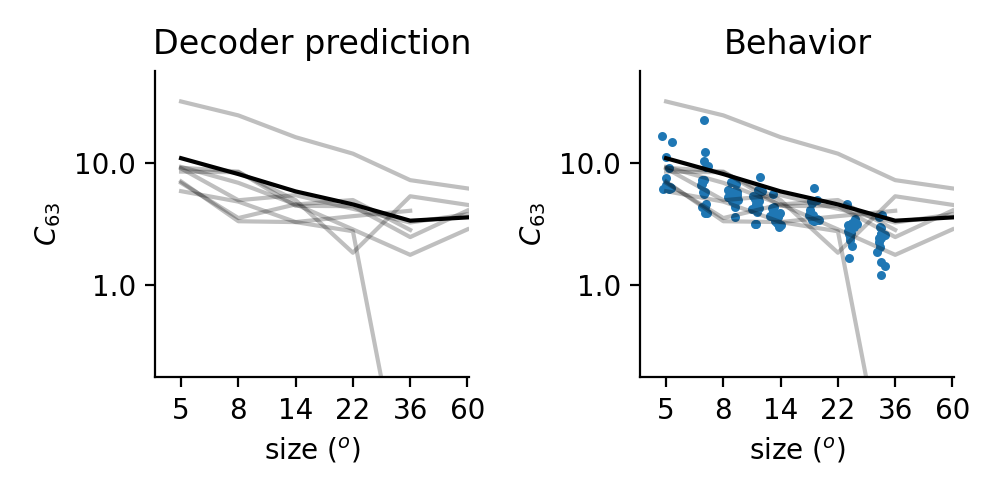

<IPython.core.display.Javascript object>


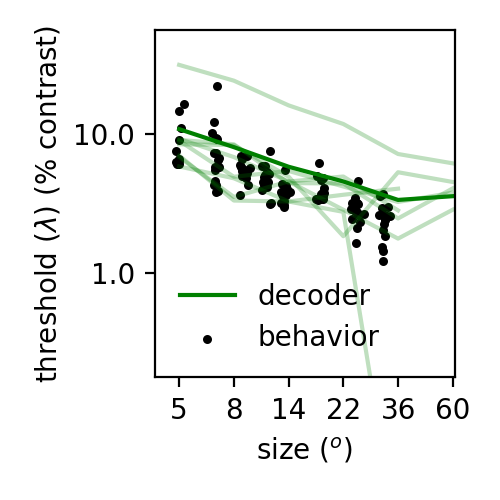

In [935]:
plt.figure(figsize=(5,2.5))
plt.subplot(1,2,1)
plt.plot(np.log10(usize),np.log10(c50s_decoder).T,c='k',alpha=0.25)
# for iexpt in range(c50s.shape[0]):
#     plt.errorbar(np.log10(usize),c50s[iexpt],yerr=c50std[iexpt],c='k',alpha=0.25)
plt.plot(np.log10(usize),np.log10(np.nanmean(c50s_decoder,0)),c='k')
# plt.yticks((-1,0,1),(0.1,1,10))
# plt.scatter(np.log10(usize).flatten(),np.log10(c50s.T).flatten(),c='k',alpha=0.25)
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
yticks = np.arange(-1,2).astype('float')
ytick_lbls = [10**yt for yt in yticks]
plt.yticks(yticks,ytick_lbls)
plt.ylim((-0.75,1.75))
plt.xlim((np.log10(4),np.log10(61)))
ut.erase_top_right()
plt.xlabel('size ($^o$)')
plt.ylabel('$C_{63}$')
plt.title('Decoder prediction')

plt.subplot(1,2,2)
plt.scatter(np.log10(size_by_animal)+0.01*np.random.randn(*(size_by_animal.shape)),np.log10(c50s_animal),s=5)
plt.plot(np.log10(usize),np.log10(c50s_decoder).T,c='k',alpha=0.25)
plt.plot(np.log10(usize),np.log10(np.nanmean(c50s_decoder,0)),c='k')
# plt.plot(np.log10(usize),np.nanmean(c50s,0),c='k')#,linestyle='dashed')
ut.erase_top_right()
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
yticks = np.arange(-1,2).astype('float')
ytick_lbls = [10**yt for yt in yticks]
plt.yticks(yticks,ytick_lbls)
plt.xlim((np.log10(4),np.log10(61)))
plt.xlabel('size ($^o$)')
plt.ylabel('$C_{63}$')
plt.title('Behavior')
plt.ylim((-0.75,1.75))
plt.tight_layout()
# plt.savefig('figures/weibull_lambda_decoder_and_behavior.jpg',dpi=300)

plt.figure(figsize=(2.5,2.5))
plt.scatter(np.log10(size_by_animal)+0.01*np.random.randn(*(size_by_animal.shape)),np.log10(c50s_animal),s=5,c='k',label='behavior')
plt.plot(np.log10(usize),np.log10(c50s_decoder).T,c=np.array((0,0.5,0)),alpha=0.25)
plt.plot(np.log10(usize),np.log10(np.nanmean(c50s_decoder,0)),c=np.array((0,0.5,0)),label='decoder')
# plt.plot(np.log10(usize),np.nanmean(c50s,0),c='k')#,linestyle='dashed')
# ut.erase_top_right()
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
yticks = np.arange(-1,2).astype('float')
ytick_lbls = [10**yt for yt in yticks]
plt.yticks(yticks,ytick_lbls)
plt.xlim((np.log10(4),np.log10(61)))
plt.legend(frameon=False)
plt.xlabel('size ($^o$)')
plt.ylabel('threshold ($\lambda$) (% contrast)')
# plt.title('Behavior')
plt.ylim((-0.75,1.75))
plt.tight_layout()
plt.savefig('figures/weibull_lambda_decoder_and_behavior_one_plot.jpg',dpi=300)

<IPython.core.display.Javascript object>


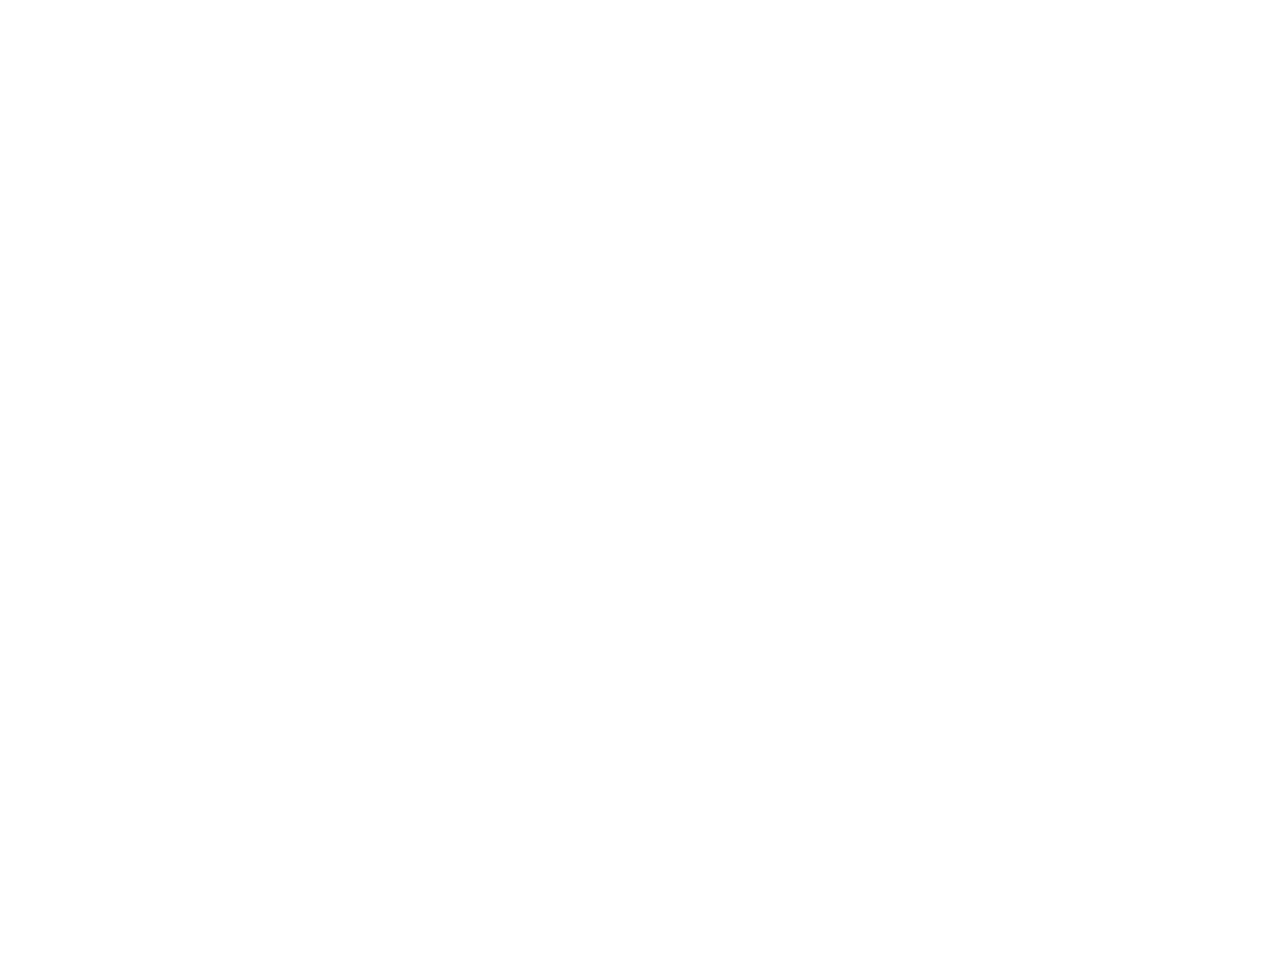

NameError: name 'c50s' is not defined

In [475]:
plt.figure()
plt.plot(np.log10(usize),np.log10(c50s.T),c='k',alpha=0.25)
for iexpt in range(c50s.shape[0]):
    plt.errorbar(np.log10(usize),np.log10(c50s[iexpt]),yerr=np.log10(c50std[iexpt]),c='k',alpha=0.25)
plt.plot(np.log10(usize),np.nanmean(np.log10(c50s),0),c='k')
plt.yticks((-1,0,1),(0.1,1,10))
# plt.scatter(np.log10(usize).flatten(),np.log10(c50s.T).flatten(),c='k',alpha=0.25)
plt.xticks(np.log10(usize),np.round(usize).astype('int'))
plt.ylim((-2,2))

<IPython.core.display.Javascript object>


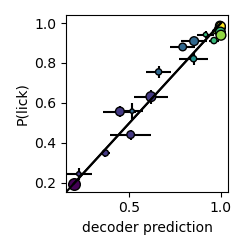

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: Mean of empty slice
  return f_raw(*args, **kwargs)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [225]:
save_fig = False
reload(sca)
plt.figure(figsize=(2.5,2.5))
sca.scatter_size_contrast_errorbar(hit_mean,np.concatenate((lick_rate_interp_lb[np.newaxis],lick_rate_interp_ub[np.newaxis])),equate_0=True,nsize=6,ncontrast=7)
plt.plot((0,1),(0,1),c='k')
# ut.erase_top_right()
plt.xlabel('decoder prediction')
plt.ylabel('P(lick)')
plt.tight_layout()
if save_fig:
    plt.savefig('figures/lick_rate_vs_decoder_size_contrast.eps')

In [224]:
all_detector_corr = np.zeros((nexpt,))
for iexpt in range(nexpt):
    ok = ~np.isnan(hit_mean[iexpt].flatten()) & ~np.isnan(lick_rate_interp.flatten())
    all_detector_corr[iexpt] = np.corrcoef(hit_mean[iexpt].flatten()[ok],lick_rate_interp.flatten()[ok])[0,1]

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


<IPython.core.display.Javascript object>


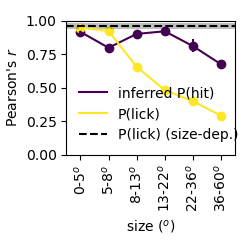

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.920815567132311
linewidth: 1
plotting
linewidth: 1
plotting


In [229]:
plt.figure(figsize=(2.5,2.5))
ut.plot_bootstrapped_errorbars_hillel(np.arange(6),
            np.concatenate((inferred_detector_corr[:,np.newaxis,:],lick_corr[:,np.newaxis,:]),axis=1),
                                      pct=(16,84))
plt.axhline(np.nanmean(all_detector_corr),linestyle='dashed',c='k')
lb,ub = ut.bootstrap(all_detector_corr,fn=np.nanmean,pct=(16,84))
plt.fill_between((-1,6),(lb,lb),(ub,ub),facecolor='k',alpha=0.25)
plt.xticks(np.arange(6),['%d-%d$^o$'%(x,y) for x,y in \
                         zip(np.round(usize0).astype('int')[:-1],np.round(usize0).astype('int')[1:])],rotation=90)
plt.xlabel('size ($^o$)')
plt.ylabel("Pearson's $r$")
plt.xlim((-0.5,5.5))
plt.ylim((0,1.0))
plt.legend(['inferred P(hit)','P(lick)','P(lick) (size-dep.)'],frameon=False)
plt.tight_layout()
if save_fig:
    plt.savefig('figures/ind_detection_r_by_size.jpg',dpi=450)

<IPython.core.display.Javascript object>


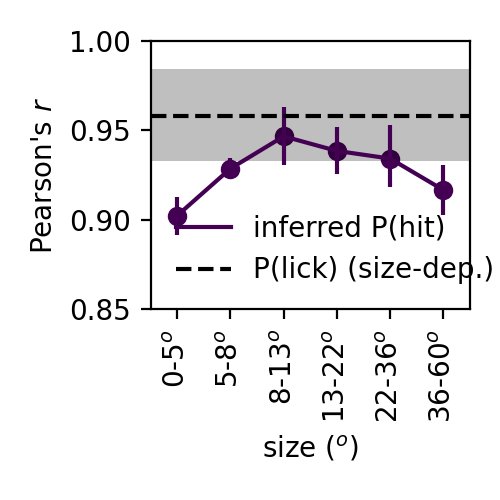

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


0.9307109239076018
linewidth: 1
plotting


In [242]:
plt.figure(figsize=(2.5,2.5))
# ut.plot_bootstrapped_errorbars_hillel(np.arange(6),
#             np.concatenate((inferred_detector_corr[:,np.newaxis,:],lick_corr[:,np.newaxis,:]),axis=1),
#                                       pct=(16,84))
ut.plot_bootstrapped_errorbars_hillel(np.arange(6),
            np.concatenate((inferred_detector_smeared_corr[:,np.newaxis,:],),axis=1),
                                      pct=(16,84)) #lick_corr[:,np.newaxis,:]
plt.axhline(np.nanmean(all_detector_corr),linestyle='dashed',c='k')
lb,ub = ut.bootstrap(all_detector_corr,fn=np.nanmean,pct=(16,84))
plt.fill_between((-1,6),(lb,lb),(ub,ub),facecolor='k',alpha=0.25)
plt.xticks(np.arange(6),['%d-%d$^o$'%(x,y) for x,y in \
                         zip(np.round(usize0).astype('int')[:-1],np.round(usize0).astype('int')[1:])],rotation=90)
plt.xlabel('size ($^o$)')
plt.ylabel("Pearson's $r$")
plt.xlim((-0.5,5.5))
plt.ylim((0.85,1.0))
plt.legend(['inferred P(hit)','P(lick) (size-dep.)'],frameon=False) #'P(lick)',
plt.tight_layout()
save_fig = True
if save_fig:
    plt.savefig('figures/smeared_ind_detection_r_by_size.jpg',dpi=450)
save_fig = False

<IPython.core.display.Javascript object>


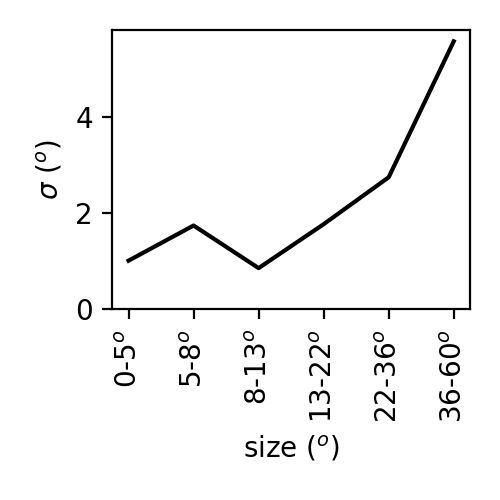

In [244]:
plt.figure(figsize=(2.5,2.5))
plt.plot(np.arange(6),all_sigma,c='k')
plt.gca().set_ylim(bottom=0)
plt.xticks(np.arange(6),['%d-%d$^o$'%(x,y) for x,y in \
                         zip(np.round(usize0).astype('int')[:-1],np.round(usize0).astype('int')[1:])],rotation=90)
plt.xlabel('size ($^o$)')
plt.ylabel('$\sigma$ ($^o$)')
plt.tight_layout()
if True:
    plt.savefig('figures/smearing_sigma_by_size.eps')

In [936]:
usize0

array([ 0.        ,  5.        ,  8.21865442, 13.50925609, 22.20558144,
       36.5       , 60.        ])

<IPython.core.display.Javascript object>


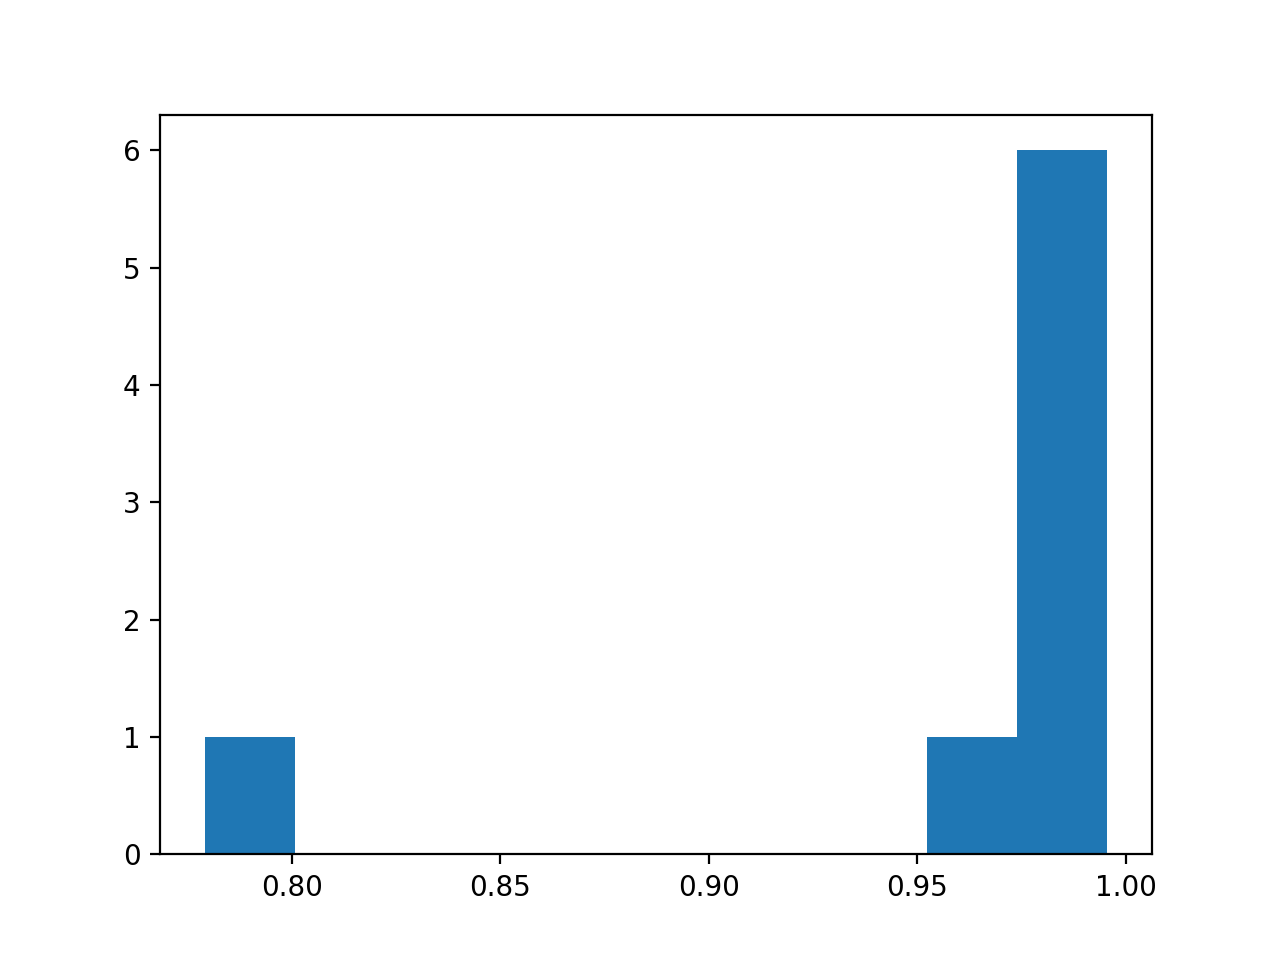

(array([1., 0., 0., 0., 0., 0., 0., 0., 1., 6.]),
 array([0.77922117, 0.80084822, 0.82247527, 0.84410232, 0.86572937,
        0.88735642, 0.90898347, 0.93061052, 0.95223757, 0.97386462,
        0.99549167]),
 <BarContainer object of 10 artists>)

In [912]:
plt.figure()
plt.hist(all_detector_corr)

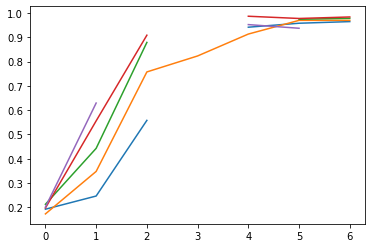

In [45]:
plt.figure()
plt.plot(lick_rate_interp.T)

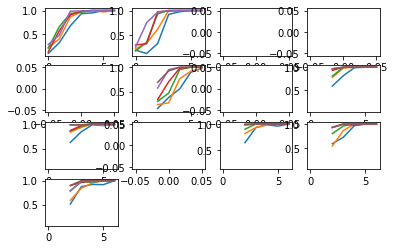

In [46]:
plt.figure()
for iexpt in range(hit_mean.shape[0]):
    plt.subplot(4,4,iexpt+1)
    plt.plot(hit_mean[iexpt].T)

In [943]:
ucontrast

array([0.  , 0.06, 0.12, 0.25, 0.5 , 1.  ])

<IPython.core.display.Javascript object>


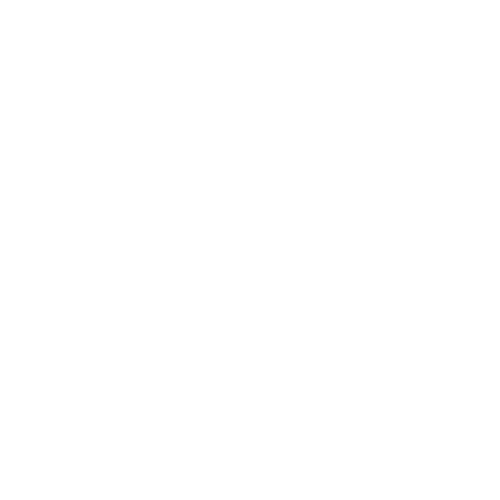

/Users/dan/Documents/code/adesnal/pyute.py:953: RuntimeWarning: Mean of empty slice
  mn_tgt = np.nanmean(arr,0)
/Users/dan/Documents/code/adesnal/pyute.py:141: RuntimeWarning: Mean of empty slice
  stat = fn(resamp,axis=axis)
/opt/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA

1.0
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting
linewidth: 1
plotting


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of ticklabels (6).

In [942]:
plt.figure(figsize=(2.5,2.5))
ut.plot_bootstrapped_errorbars_hillel(np.arange(7),hit_mean,pct=(16,84))
plt.xticks(np.arange(7),(100*ucontrast).astype('int'))
plt.legend([r'%d$^o$'%i for i in usize.astype('int')],frameon=False)
plt.ylabel('decoder prediction')
plt.xlabel('contrast (%)')
# ut.erase_top_right()
plt.tight_layout()
plt.savefig('figures/decoder_performance_size_contrast.eps')

In [101]:
with h5py.File(dsfile,mode='r') as f:
    ucontrast = f[keylist[-1]]['size_contrast_0']['stimulus_contrast'][:]
    usize = f[keylist[-1]]['size_contrast_0']['stimulus_size_deg'][:]
ncontrast = len(ucontrast)
nsize = len(usize)

In [946]:
ucontrast

array([0.  , 0.06, 0.12, 0.25, 0.5 , 1.  ])

In [945]:
usize,ucontrast = proc[-1]['usize'],proc[-1]['ucontrast']
modal_uparam = [usize,ucontrast]
nsize,ncontrast = len(usize),len(ucontrast)

TypeError: list indices must be integers or slices, not str

In [32]:
def show_auroc(auroc,label='Population decoder detection AUROC'):
    sca.show_size_contrast(auroc[:,1:],flipud=True,usize=usize,ucontrast=100*ucontrast[1:])
    plt.colorbar().set_label(label)
    plt.clim([0.5,1])

<IPython.core.display.Javascript object>


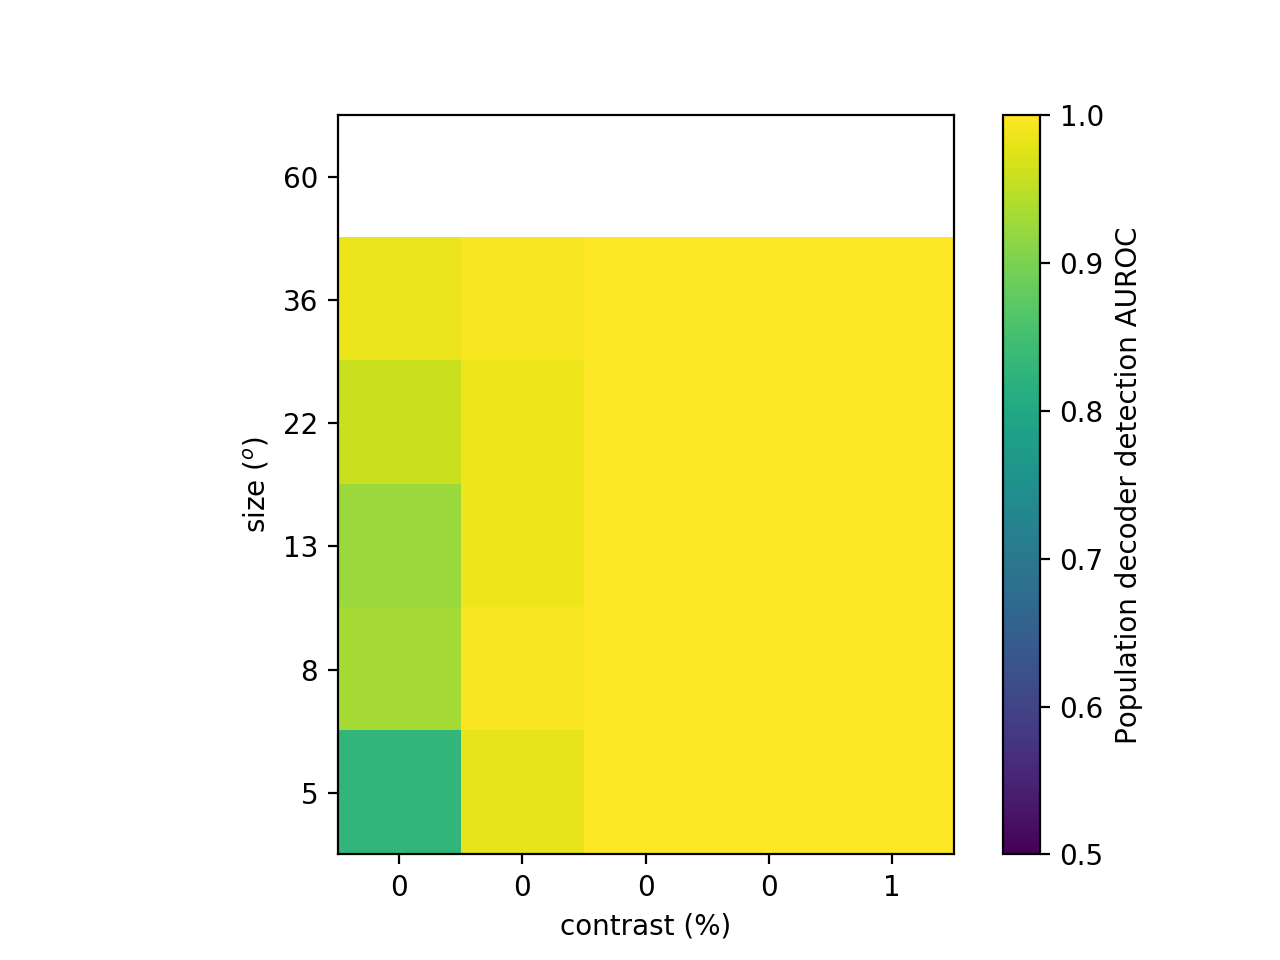

/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


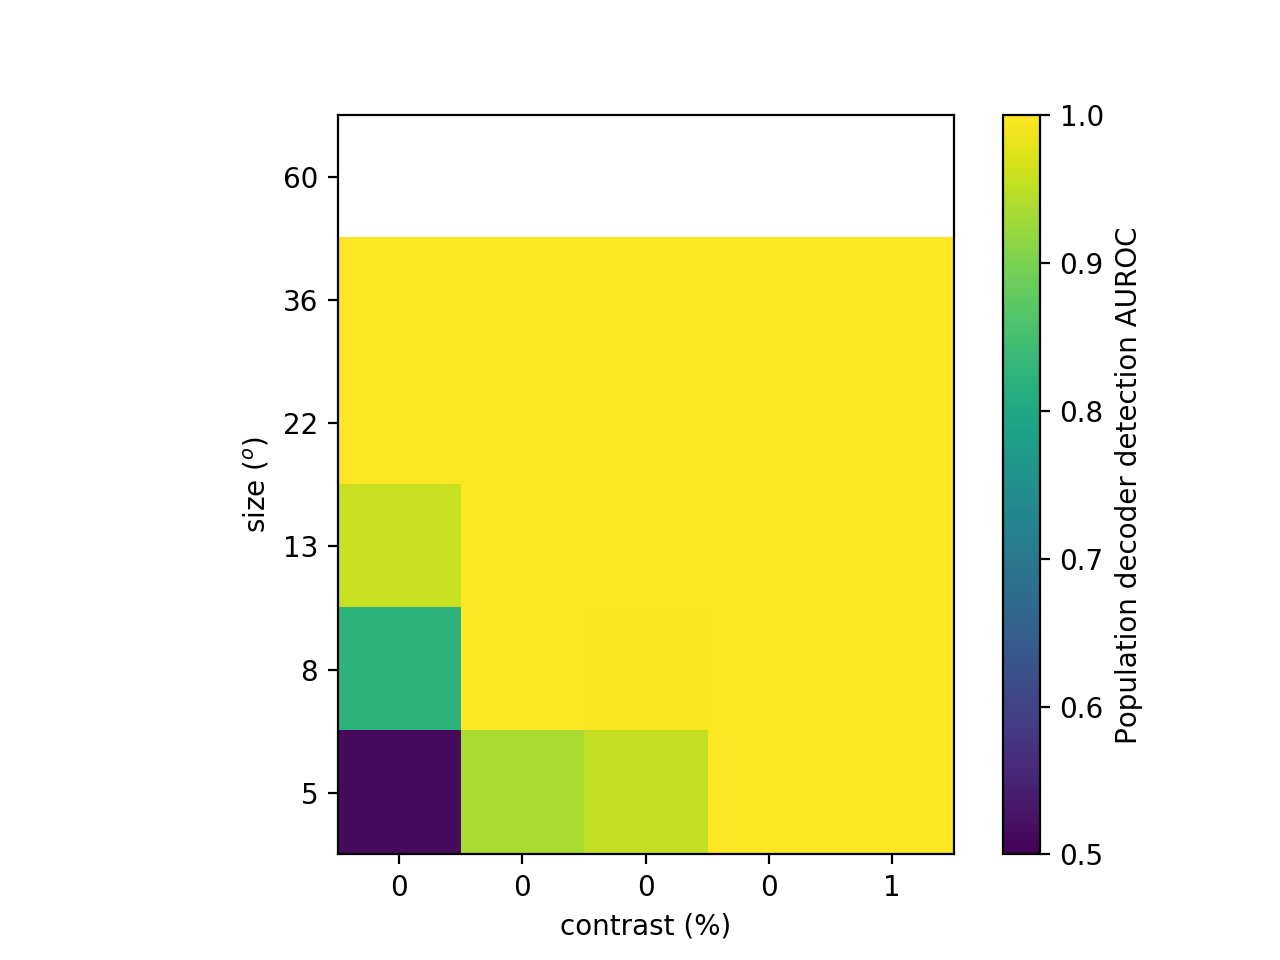

<IPython.core.display.Javascript object>


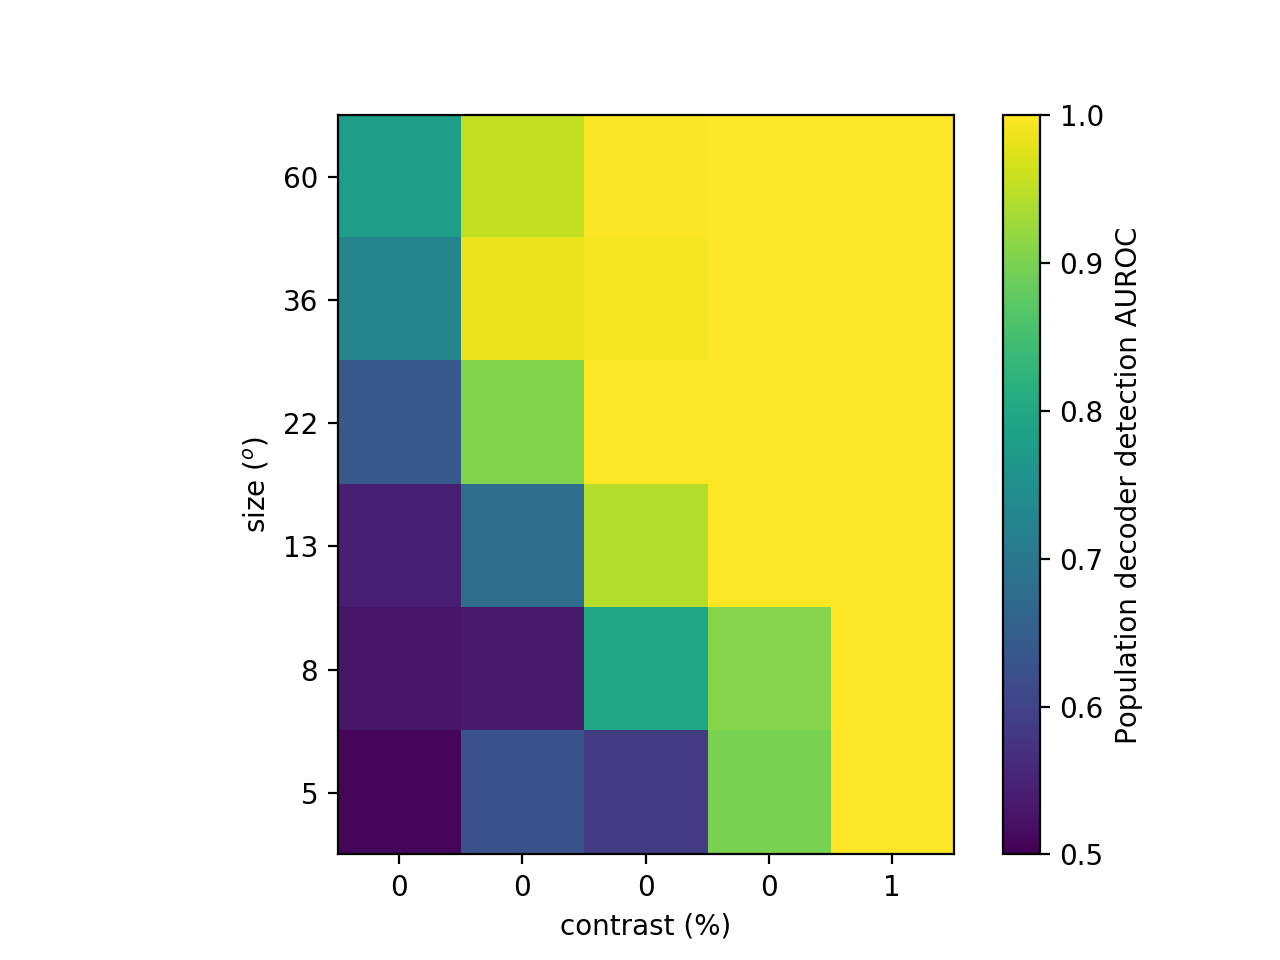

<IPython.core.display.Javascript object>


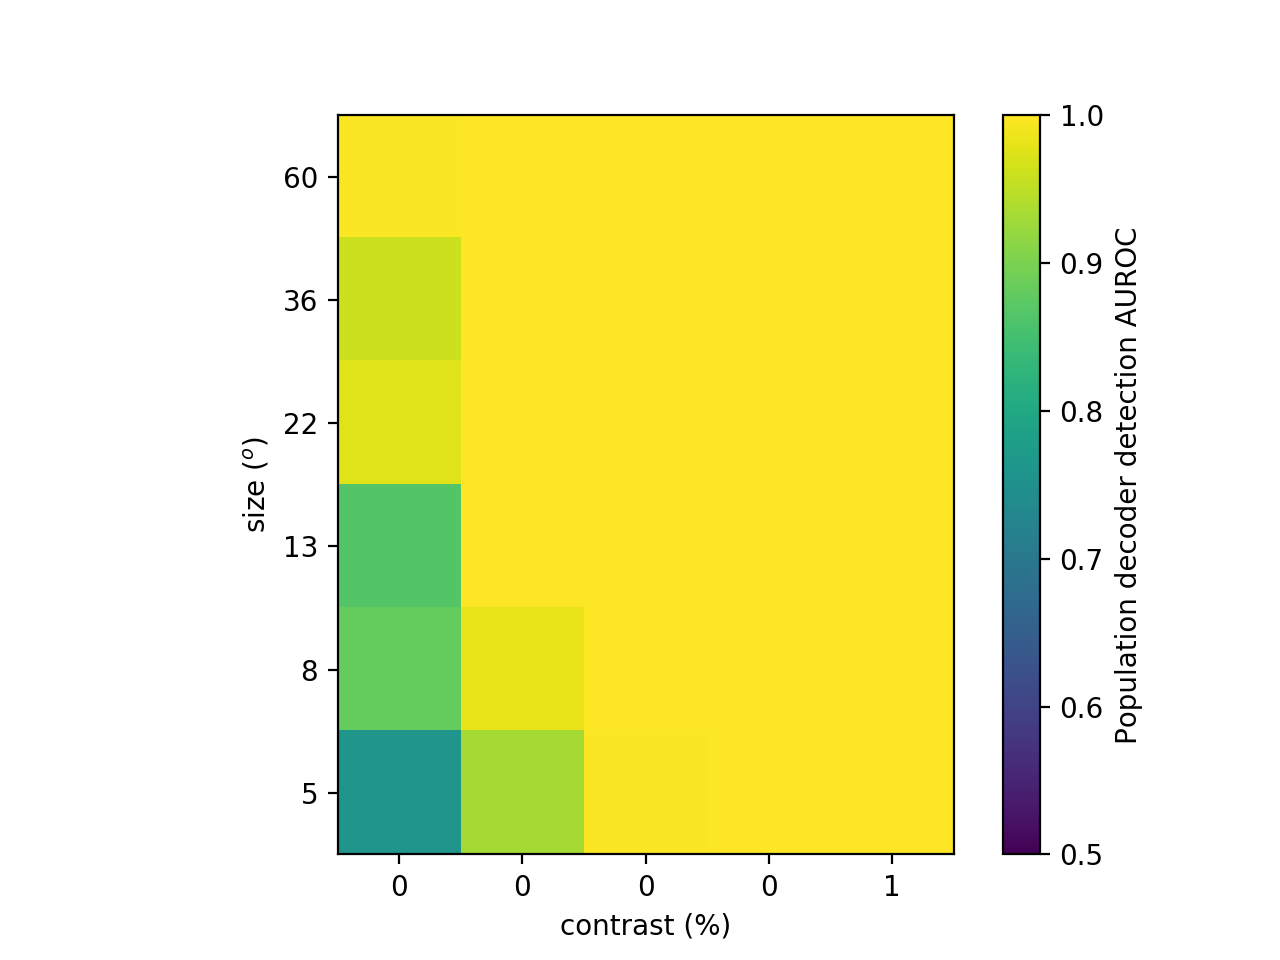

<IPython.core.display.Javascript object>


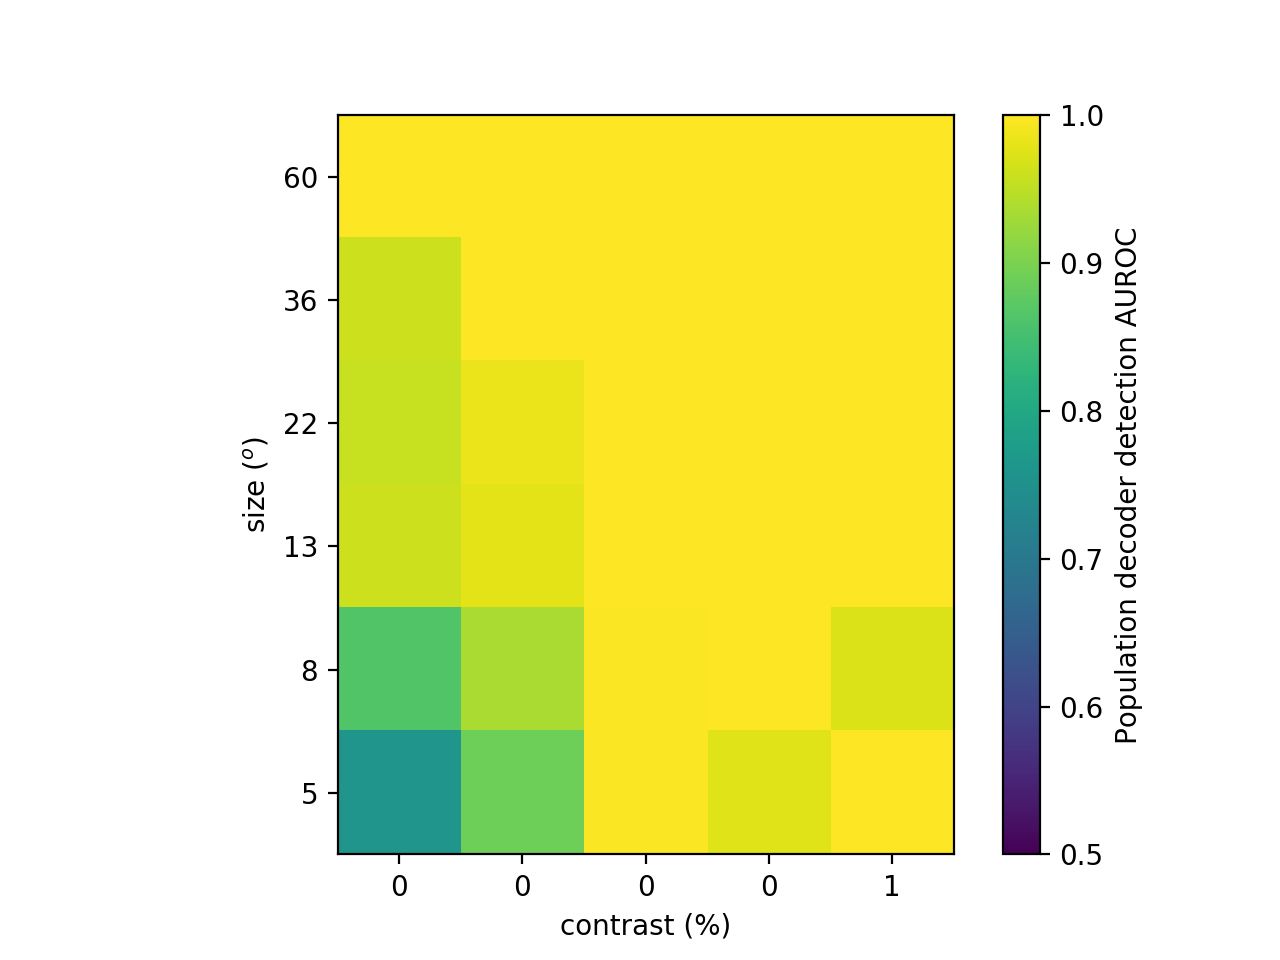

<IPython.core.display.Javascript object>


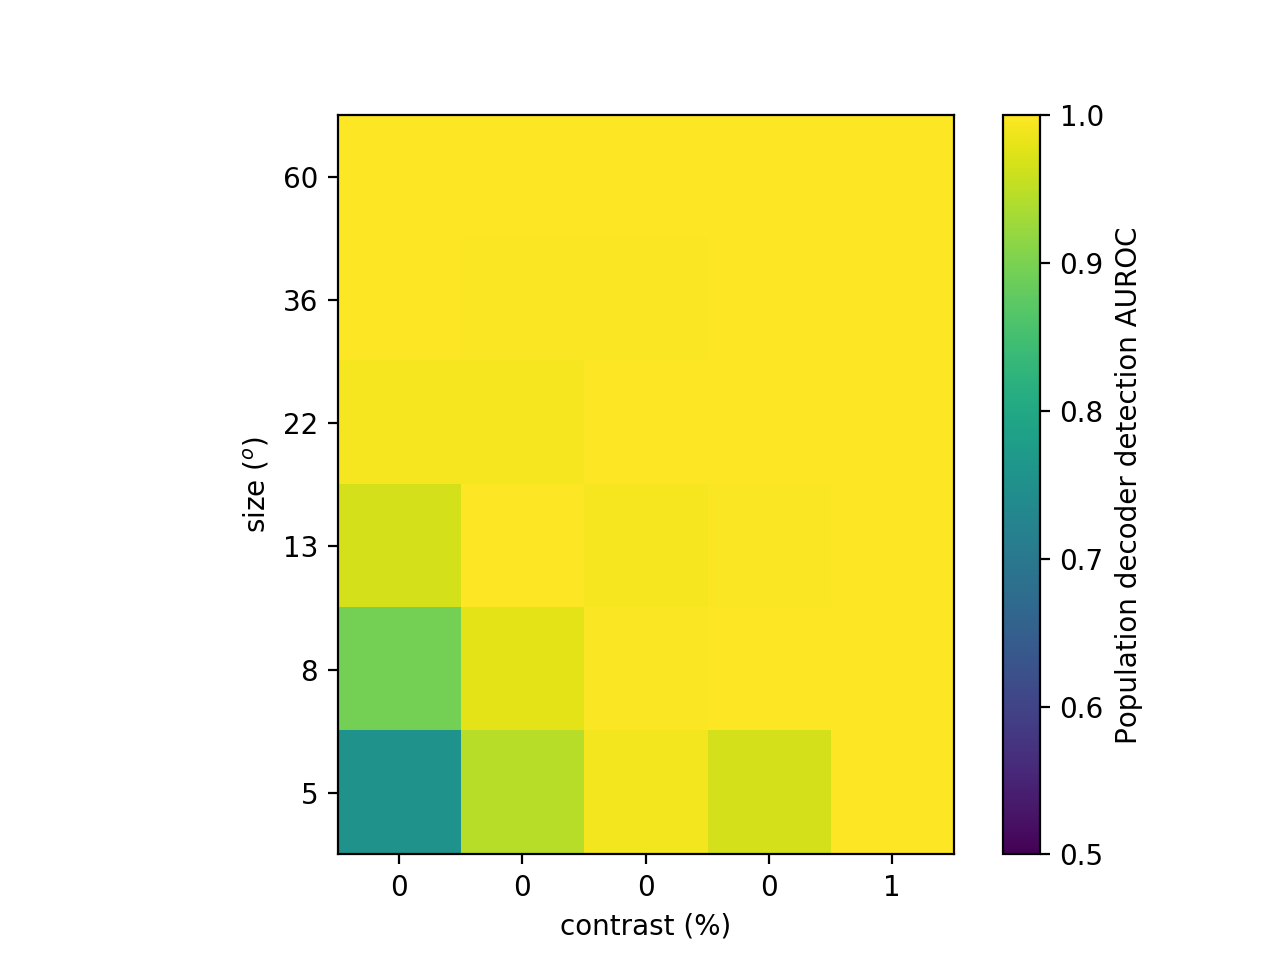

<IPython.core.display.Javascript object>


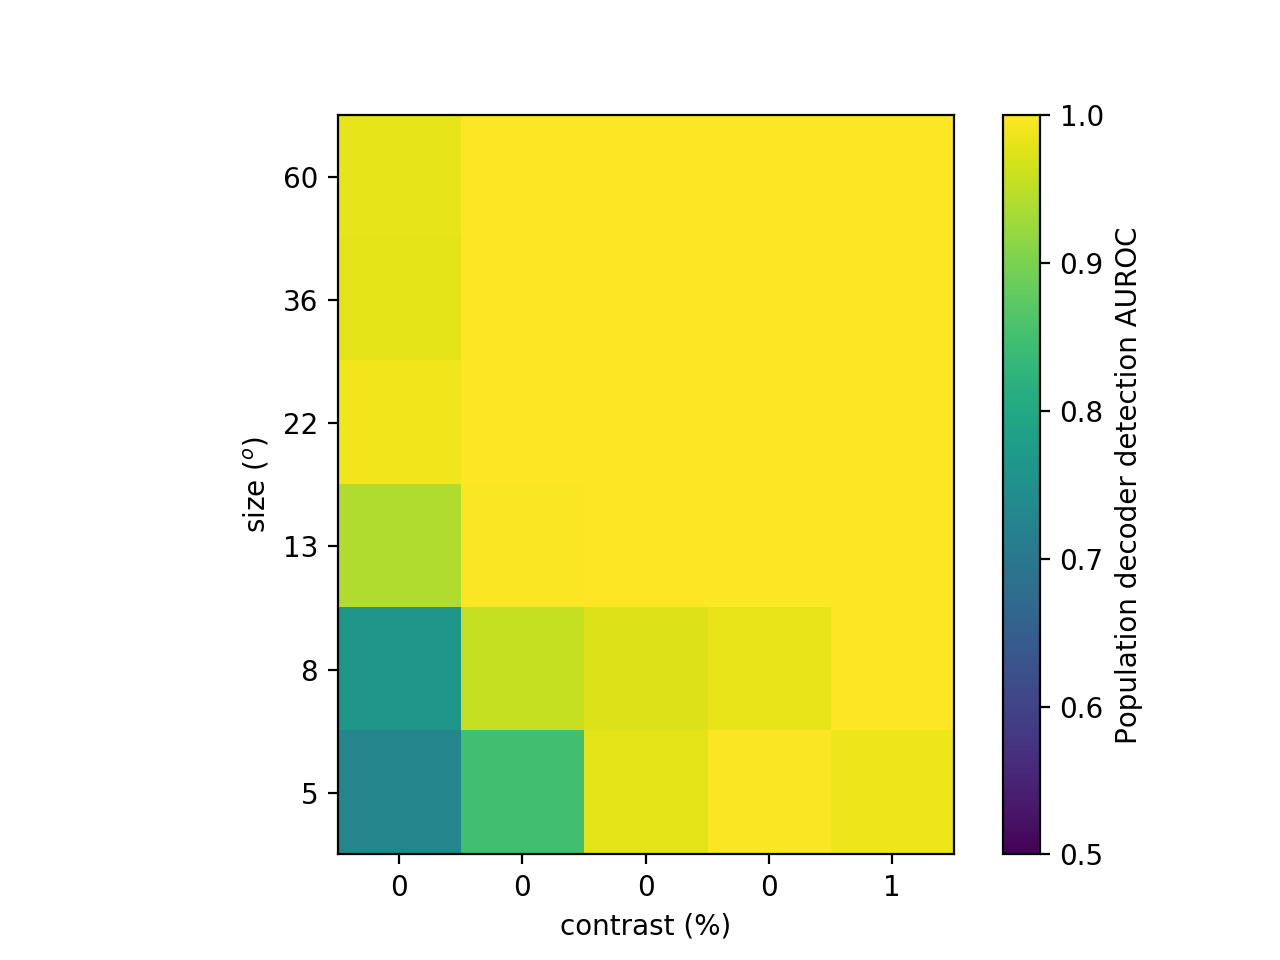

<IPython.core.display.Javascript object>


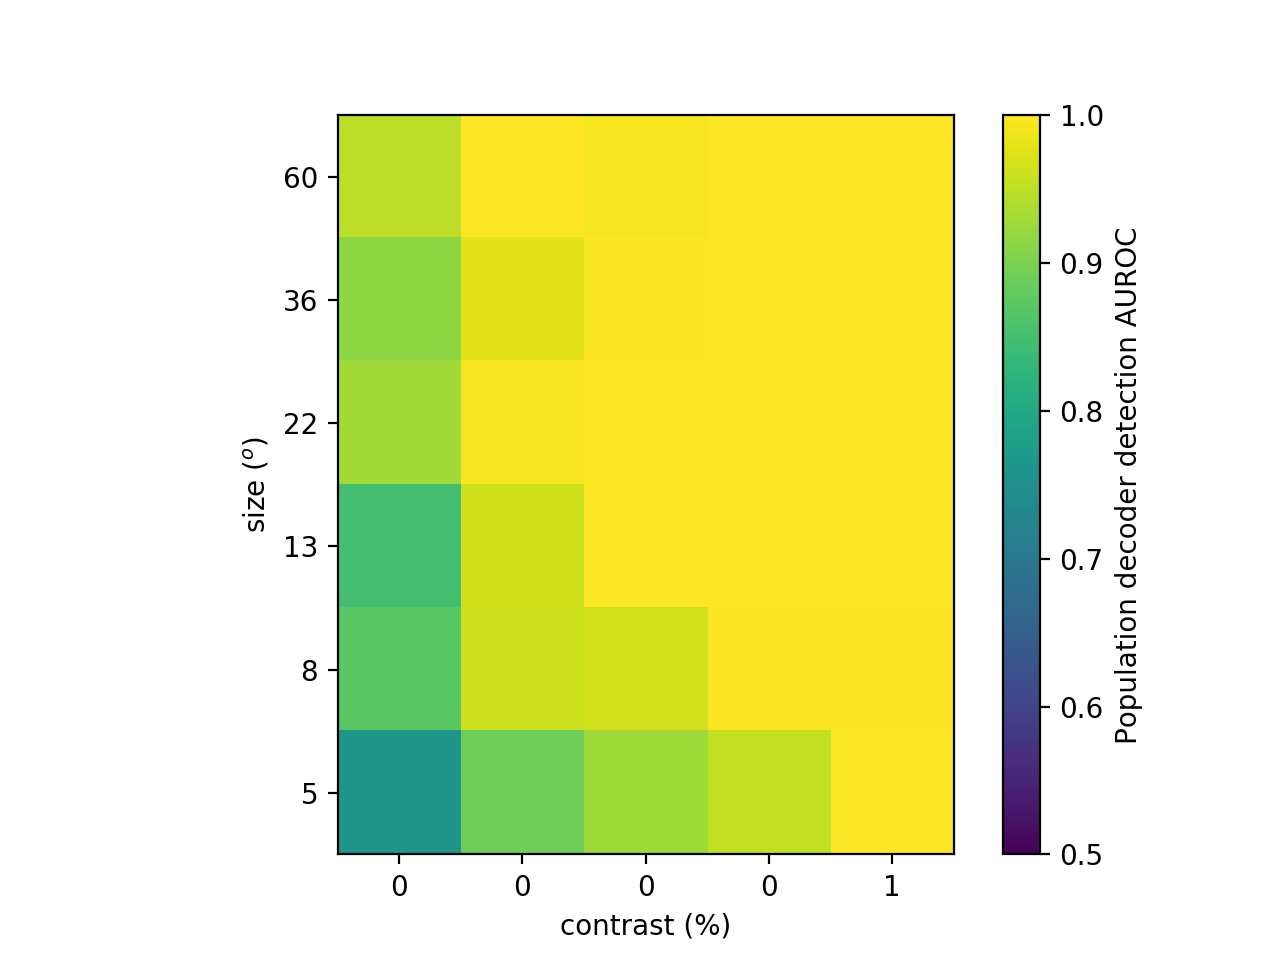

In [36]:
reload(ut)
reload(sca)
nexpt = len(proc)
# auroc_mean = [None for iexpt in range(nexpt)]
auroc_mean = np.nan*np.ones((nexpt,nsize,ncontrast))
for iexpt in range(len(proc)):
    if not auroc[0][iexpt] is None:
        plt.figure()
        this_data = np.nanmean(np.nanmean(np.concatenate([a[iexpt][np.newaxis] for a in auroc],axis=0),axis=0),-1)
        this_uparam = [proc[iexpt]['usize'],proc[iexpt]['ucontrast']]
        ut.assign_from_uparam(auroc_mean[iexpt],modal_uparam,this_data,this_uparam,ignore_first=0)
        sca.show_auroc(auroc_mean[iexpt],usize=usize,ucontrast=ucontrast)
#         sca.show_size_contrast(auroc_mean[iexpt][:,1:],flipud=True,usize=proc[iexpt]['usize'],ucontrast=100*proc[iexpt]['ucontrast'][1:])
#         plt.colorbar().set_label('Population decoder AUROC')
#         plt.clim([0.5,1])
        

<IPython.core.display.Javascript object>


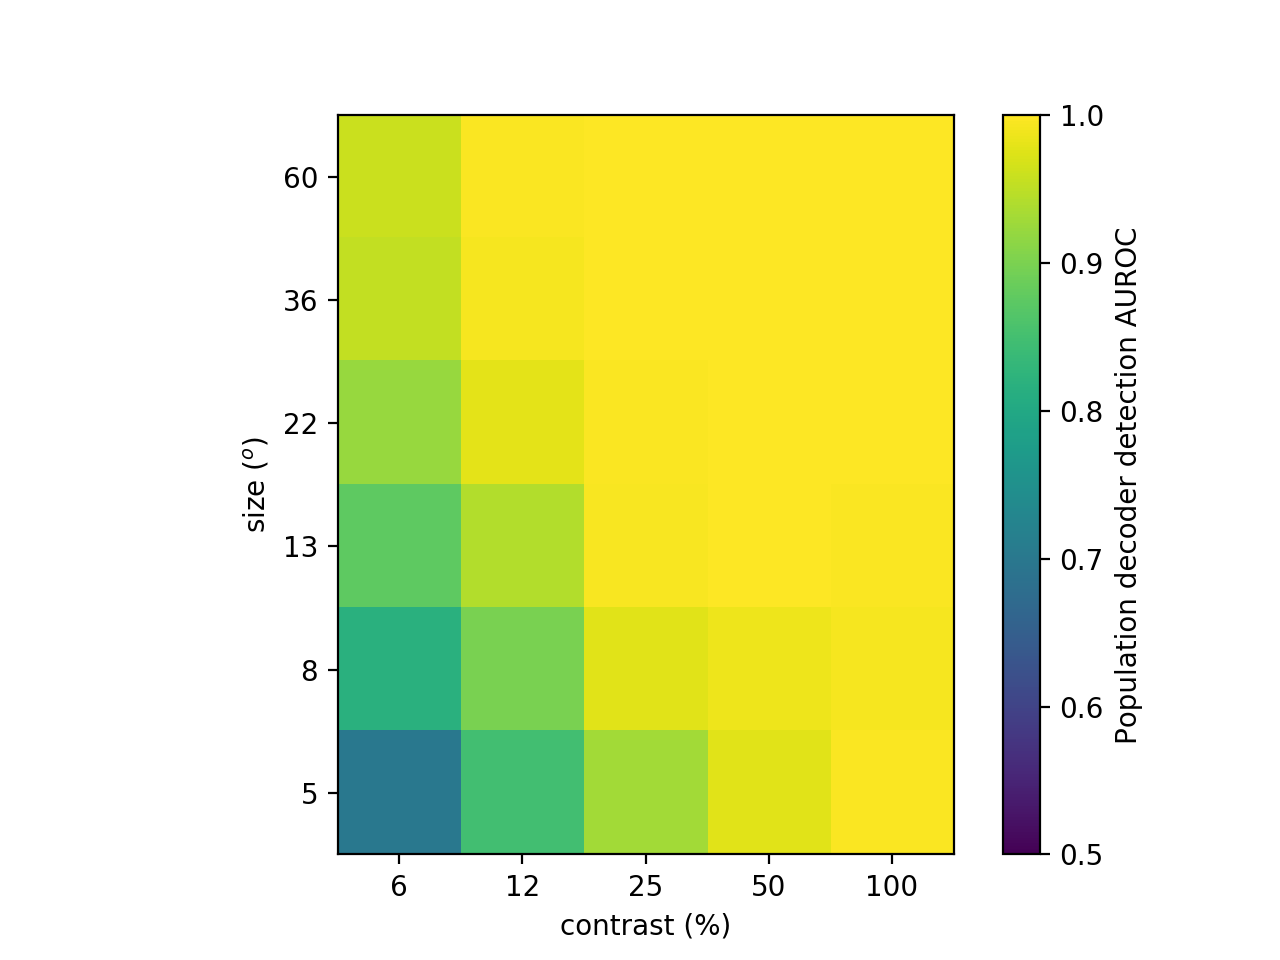

In [59]:
plt.figure()
ut.mkdir('figures')
show_auroc(np.nanmean(auroc_mean,0))
np.save('../shared_data/pyr_l23_population_detection_by_size_and_contrast_auroc.npy',auroc_mean)
plt.savefig('figures/pyr_l23_population_detection_by_size_and_contrast.jpg',dpi=300)

<IPython.core.display.Javascript object>


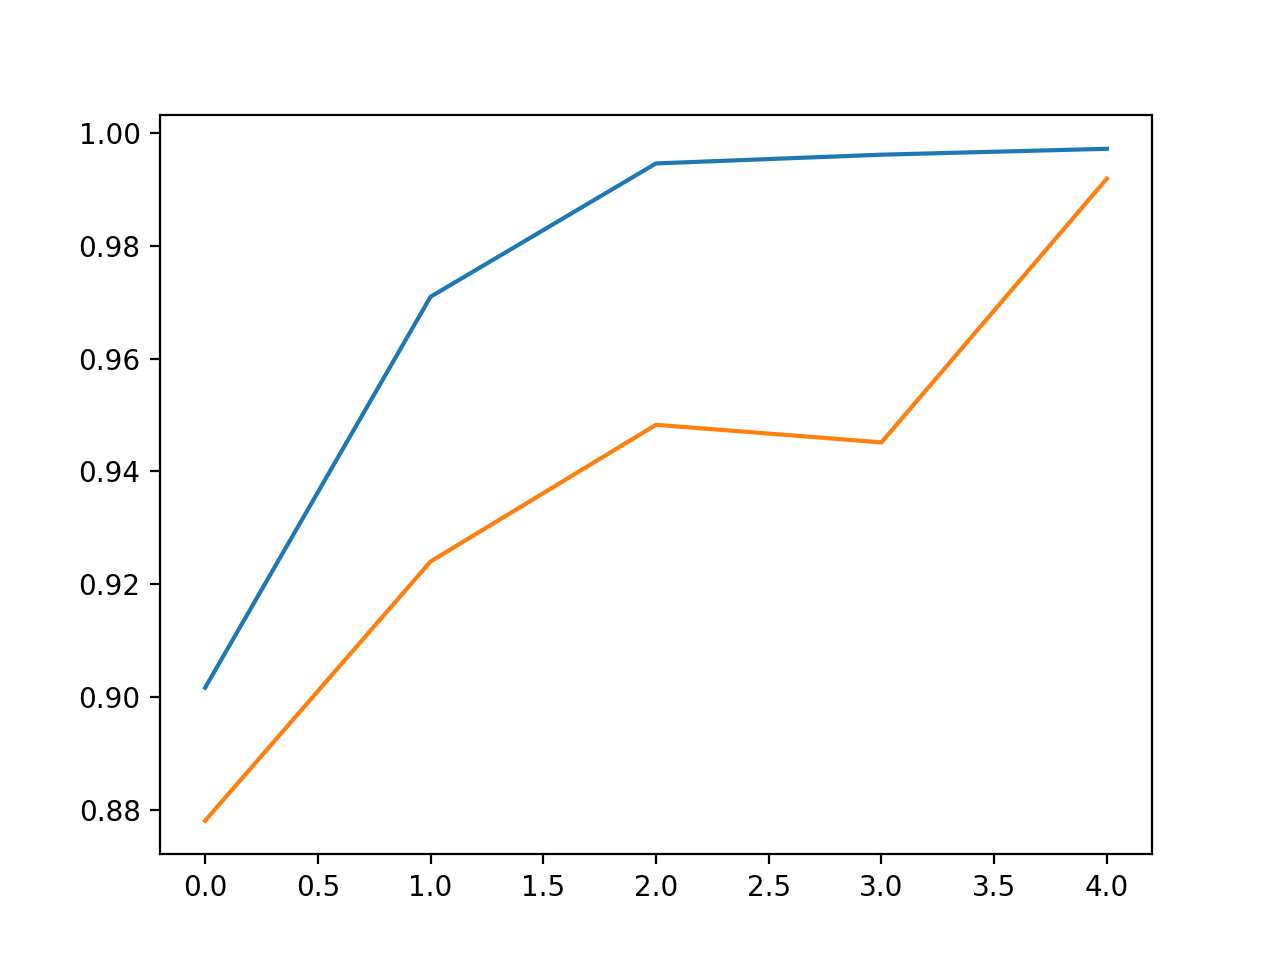

<IPython.core.display.Javascript object>


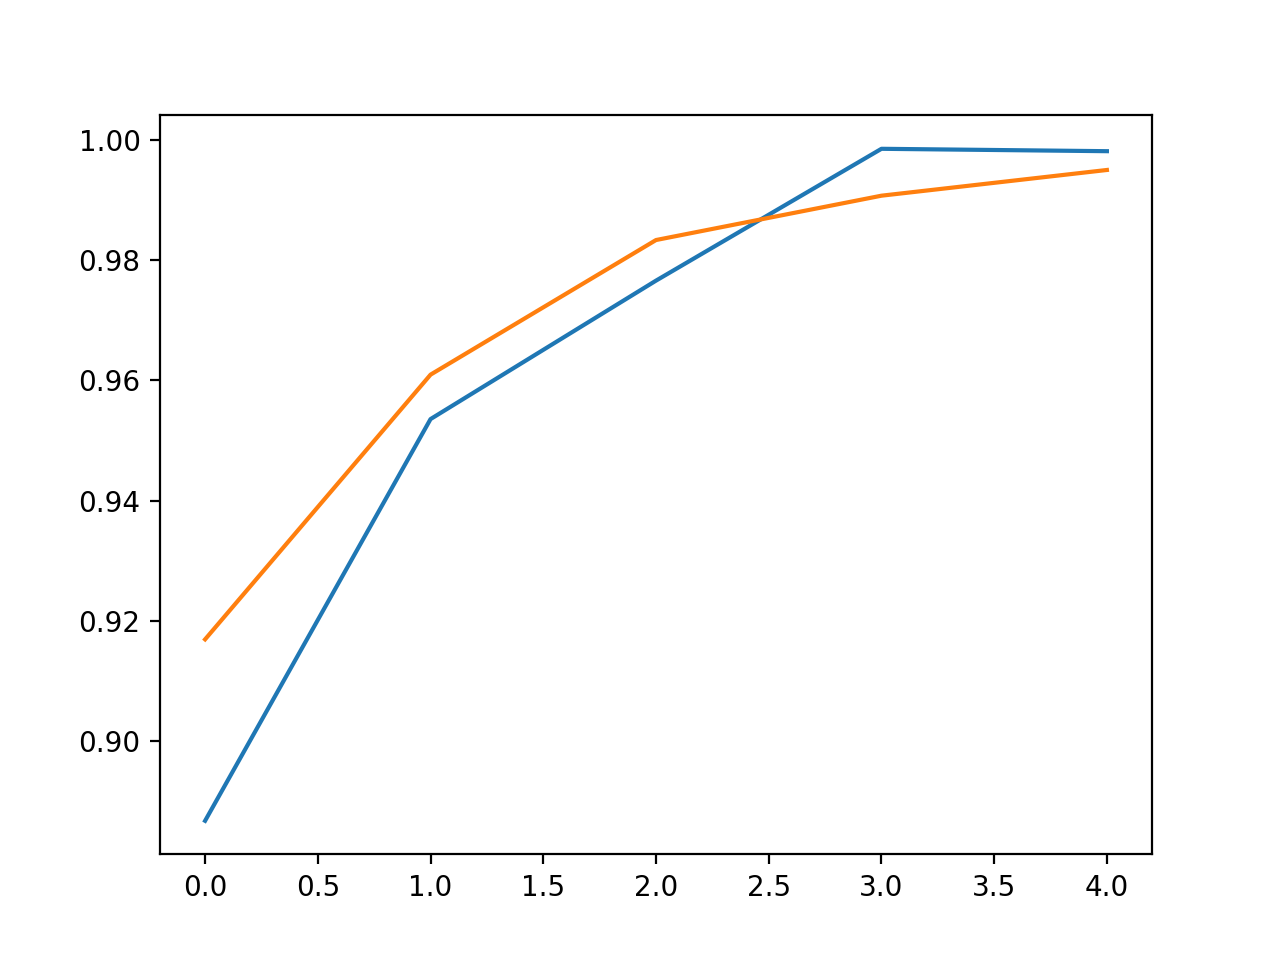

<IPython.core.display.Javascript object>


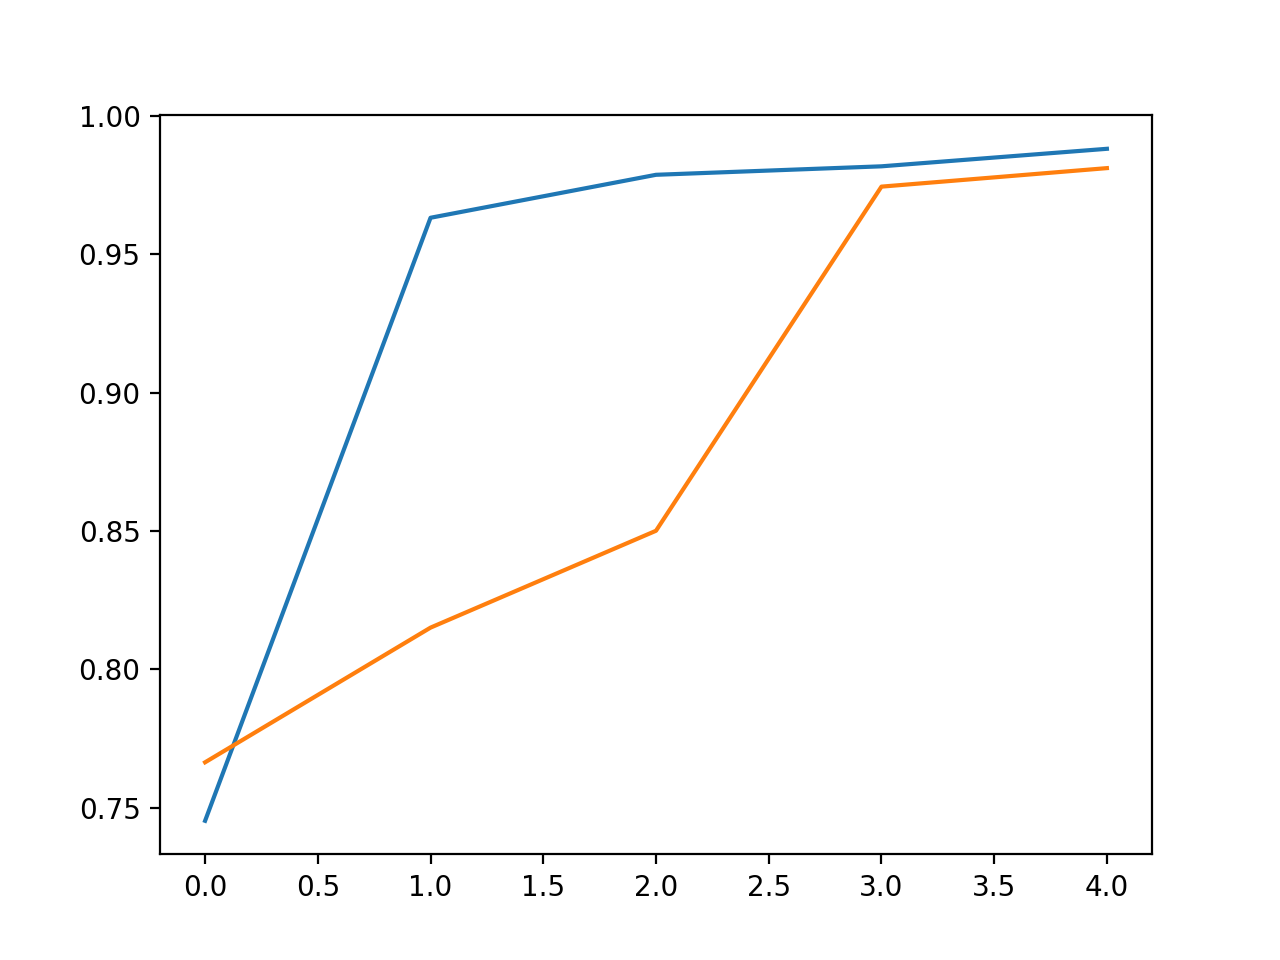

<IPython.core.display.Javascript object>


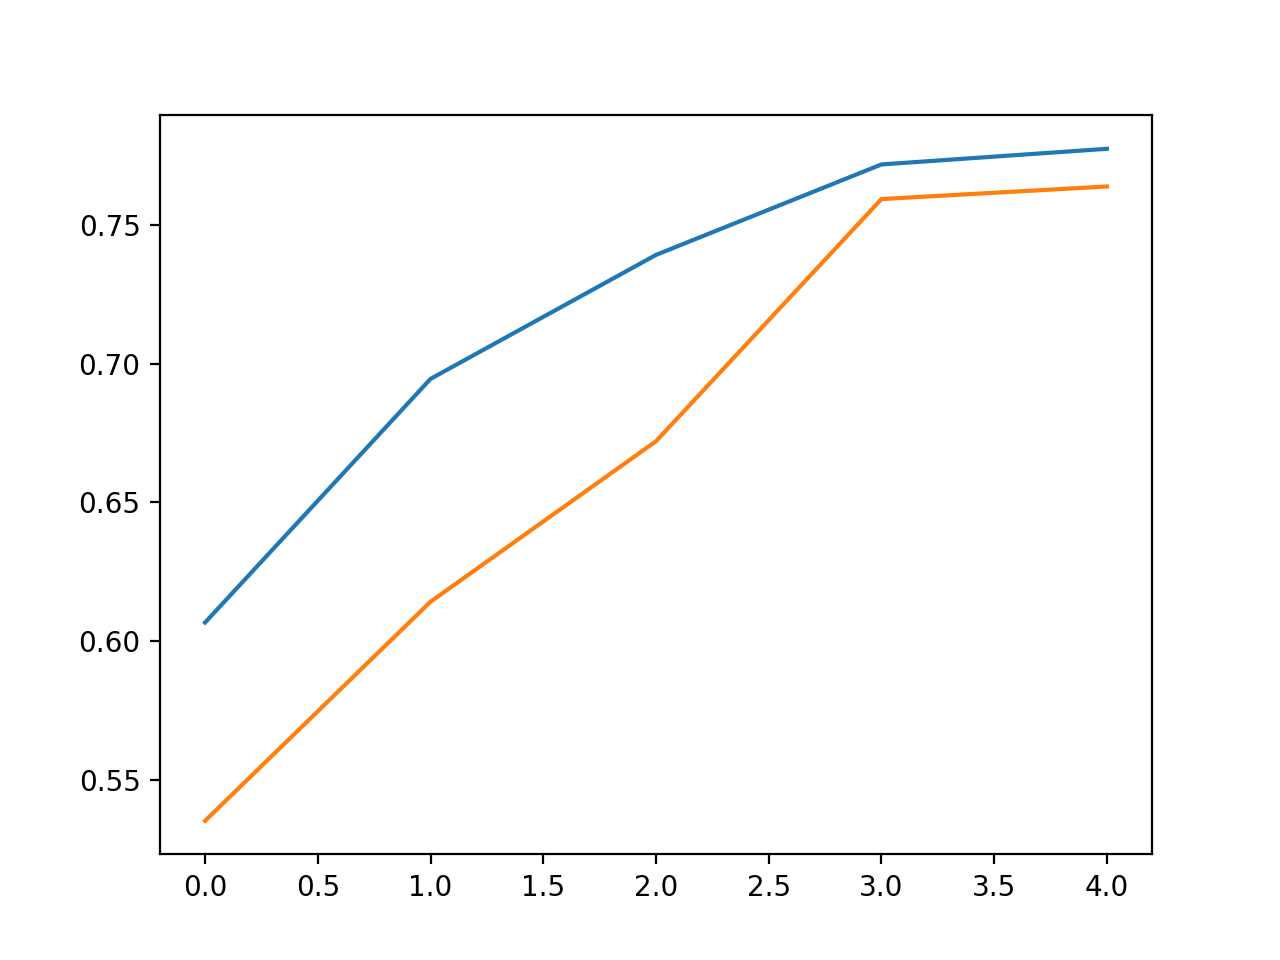

<IPython.core.display.Javascript object>


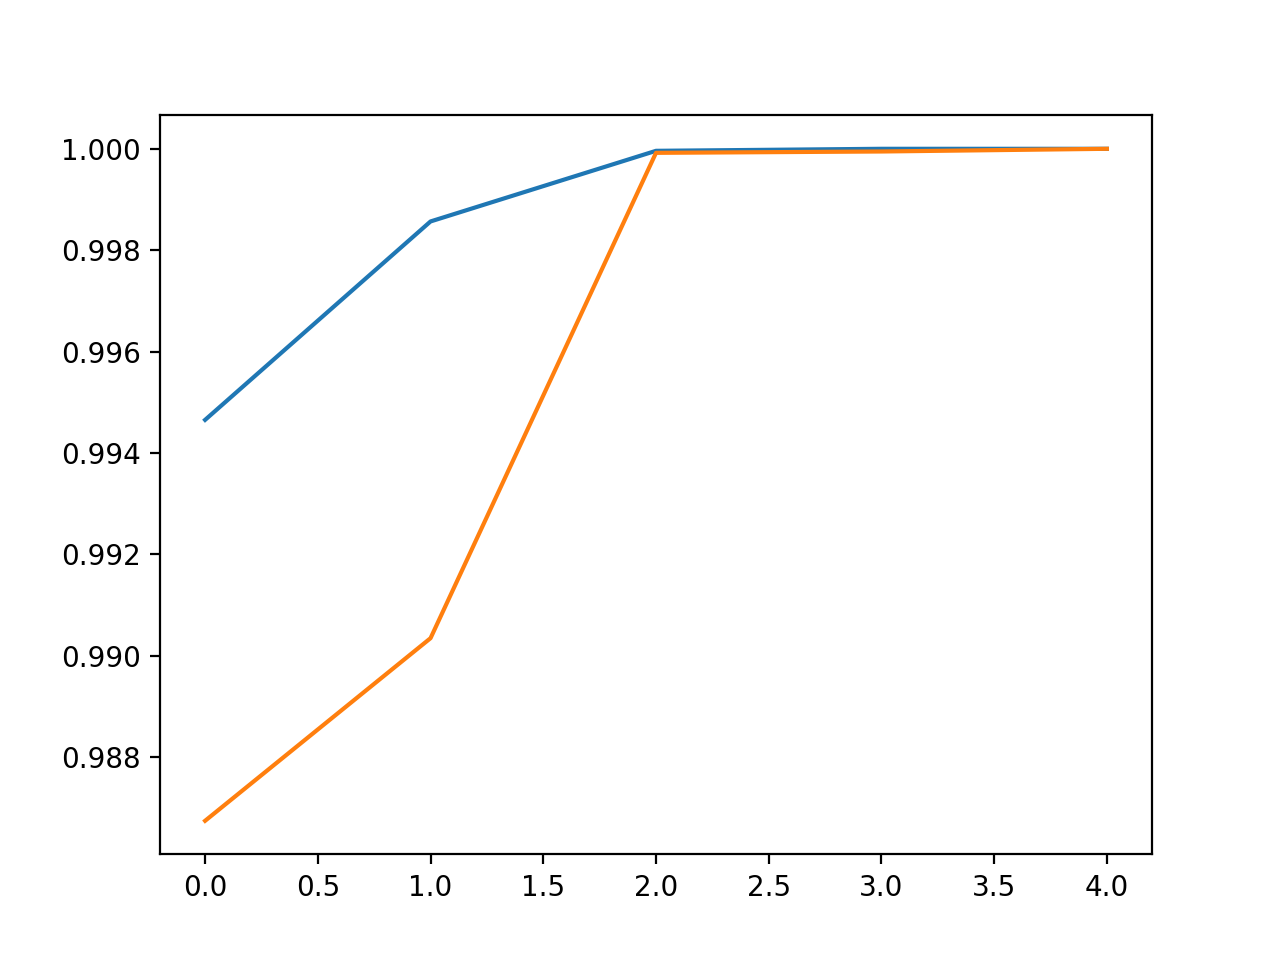

In [156]:
isize = 2
for iexpt in range(len(auroc)):
    if not auroc_mean[iexpt] is None:
        plt.figure()
#         plt.plot(np.nanmean(np.nanmean(np.nanmean(auroc[iexpt][:,:,1:],-1),-1),-1))
        plt.plot(np.nanmean(auroc_mean[iexpt][:,isize,1:],-1).T)

In [51]:
contrast_axis[0][0].shape

(5, 4, 1709)